In [ ]:
from scipy import integrate as spint
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from scipy import interpolate as spinterp
from scipy import optimize as spopt
from scipy import linalg as splinalg
from scipy.optimize import fsolve
from scipy.integrate import quad
from functools import partial
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve

In [ ]:
#REACTOR SPECIFICATIONS

Q = 1500.0E6 # Thermal power (W)
n_pin = 217 # Number of pin per assembly
n_ass = 180 # Number of assembly
p = 10.7E-3 # Pin pitch (m)
T_in = 400 # Coolant inlet temperature (°C)
m_pin = 22/(n_pin) # Coolant mass flow rate per pin (kg/s)
k = 1.3 # throttling factor in order to stay below the cladding temperature design limit
m = m_pin*k

#FUEL PIN SPECIFICATIONS

H_a = 1.1 # active length (m)
d = 9.70E-3 # Cladding outer diameter (m)
R_co = (9.70/2)*10**-3 # Cladding outer radius (m)
q_lin_max = 46.3E3 # Maximum linear heat rate (hot channel, hot pin) (W/m)
peak_factors = np.array([0.001, 0.005, 0.01, 0.03, 0.205, 0.38, 0.45, 0.51, 0.55, 0.57, 0.58, 0.315, 0.05, 0.04, 0.04, 0.05, 0.06, 0.08, 0.46, 0.84, 0.89, 0.94, 0.98, 1.0, 0.98, 0.92, 0.86, 0.81, 0.77, 0.71])
z = np.array([0.0, 130.0, 230.0, 290.0, 300.0, 310.0, 350.0, 400.0, 450.0, 490.0, 540.0, 550.0, 560.0, 590.0, 630.0, 670.0, 700.0, 740.0, 750.0, 760.0, 770.0, 790.0, 830.0, 880.0, 930.0, 980.0, 1020.0, 1050.0, 1070.0, 1100.0])*10**-3
T_fi_lim = 2400 # Maximum fuel temperature (°C)
T_ci_lim = 620 # Maximum cladding temp (°C)
R_fo = (8.46/2)*10**-3 # Fuel outer radius (m)
R_fi_fissile = (2.45/2)*10**-3 # Fissile fuel inner radius


# Functions

In [ ]:
#TEMPERATURE CONVERSION

def T_kelvin(T):
  return T + 273.15 # K

def T_far(T):
  return 32 + 9/5 * T #F

# Cold geometry

## Coolant

The average linear heat rate is: 34911.32523390588
The total temperature jump is: 184.8583622414952
The outlet temperature of the coolant is: 584.8583622414952
The average temperature for the coolant is: 492.4291811207476


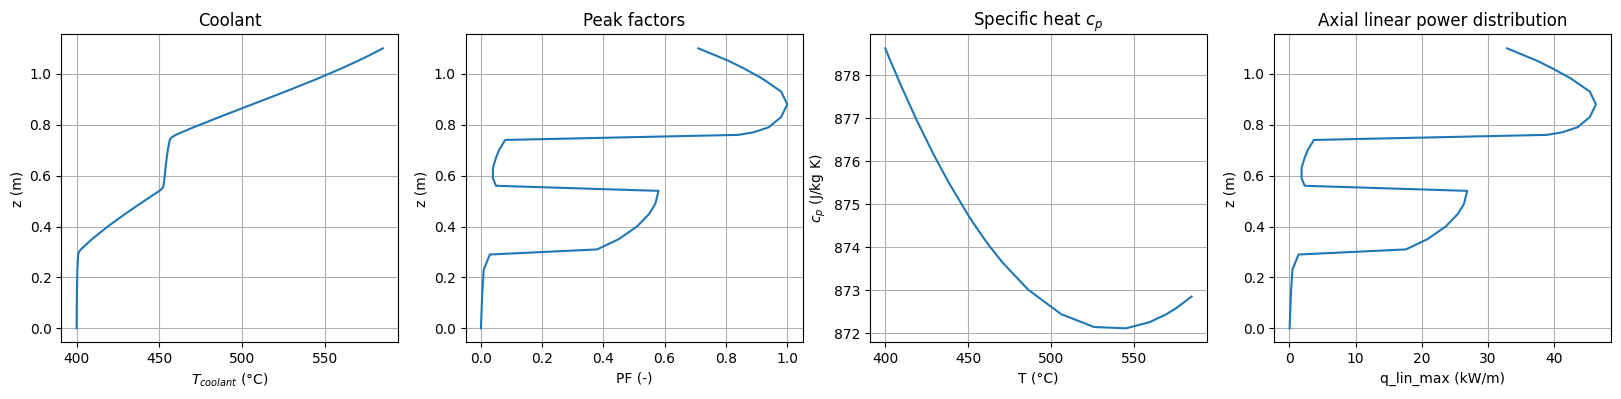

In [ ]:
#COOLANT

D_h = d*((2*np.sqrt(3)*(p)**2)/((np.pi)*(d)**2) -1) # Hydraulic diameter (m)
T_cool = np.zeros(len(peak_factors))
Delta_T = np.zeros(len(peak_factors))
q_lin = np.zeros(len(peak_factors))
q_pin = np.zeros(len(peak_factors))
T_cool[0] = T_in
q_lin_avg = Q/(n_ass*n_pin*H_a)
print('The average linear heat rate is:',q_lin_avg)

def cp(T):
  return 971.34 - 3.69*0.1*(T) + 3.43E-4*(T)**2

q_lin = q_lin_max*peak_factors

for i in range (z.size-1):
    q_pin[i] = (z[i+1]-z[i])*(q_lin[i+1]+q_lin[i])*0.5
    Delta_T[i] = q_pin[i]/(m*cp(T_cool[i]))
    T_cool[i+1] = T_cool[i]+Delta_T[i]

totDt = sum(Delta_T)
print('The total temperature jump is:', totDt)
T_out =  T_in + totDt
print('The outlet temperature of the coolant is:',T_out)
Tavg = (T_in+T_out)/2
print('The average temperature for the coolant is:', Tavg)

#Plotting
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.plot(T_cool,z)
plt.ylabel('z (m)')
plt.xlabel('$T_{coolant}$ (°C)')
plt.title('Coolant')
plt.grid()

plt.subplot(1, 4, 2)
plt.plot(peak_factors,z)
plt.ylabel('z (m)')
plt.xlabel('PF (-)')
plt.title('Peak factors')
plt.grid()

plt.subplot(1, 4, 3)
plt.plot(T_cool,cp(T_cool))
plt.xlabel('T (°C)')
plt.ylabel('$c_{p}$ (J/kg K)')
plt.title('Specific heat $c_{p}$')
plt.grid()

plt.subplot(1, 4, 4)
plt.plot(q_lin/1e3,z)
plt.xlabel('q_lin_max (kW/m)')
plt.ylabel('z (m)')
plt.title('Axial linear power distribution')
plt.grid()


The maximum outer cladding temperature is: 591.1624003249487


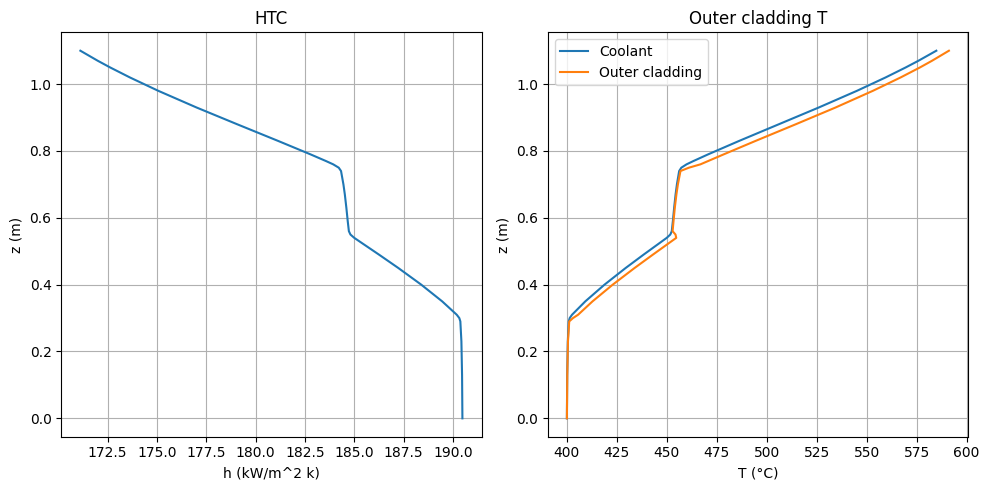

In [ ]:
# OUTER CLADDING

def k_cool(T): # Thermal conductivity of the coolant(W/m K)
  T_f = T_far(T)
  return 94 - 3.25E-2 * T_f + 3.62E-6 * T_f**2

def mu(T): # Viscosity (Pa s)
  T_k = T_kelvin(T)
  return 1.0E-3*np.exp(2.3*(0.5108+(220.65/T_k)-0.2139*np.log(T_k)))


def rho(T): # Density (kg/m^3)
  T_f = T_far(T)
  return 954.1579 + T_f*(T_f*(T_f*0.9667E-9 - 0.46E-5)-0.1273534)


Area = 2*((np.sqrt(3)/4)*p**2 - (np.pi * d**2)/8)
v = m/(Area*rho(T_cool)) # Velocity profile of the coolant (m/s)
Re = (rho(T_cool)*v*D_h)/mu(T_cool) #Reynolds profile of the coolant
Pr = (cp(T_cool)*mu(T_cool)/k_cool(T_cool)) #Prandlt profile of the coolant
Nu = 7 + 0.025*(Re*Pr)**0.8 #Nusselt profile of the coolant
h = Nu*(k_cool(T_cool)/D_h) # Heat transfer coefficient profile of the coolant (W/m^2 K)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(h/1e3,z)
plt.ylabel('z (m)')
plt.xlabel('h (kW/m^2 k)')
plt.title('HTC')
plt.grid()

DT = q_lin/(2*np.pi*R_co*h) #Temperature difference between the coolant and the outside of the claddig in each section
T_co = T_cool+DT
T_co_max = max(T_co)
print('The maximum outer cladding temperature is:',T_co_max)

plt.subplot(1, 2, 2)
plt.plot(T_cool,z,label='Coolant')
plt.plot(T_co,z,label='Outer cladding')
plt.ylabel('z (m)')
plt.xlabel('T (°C)')
plt.title('Outer cladding T')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## Cladding

In [ ]:
t_clad_max = R_co-R_fo
t_clad_max

0.0006199999999999999

The maximum inner cladding temperature is: 618.4699085273439


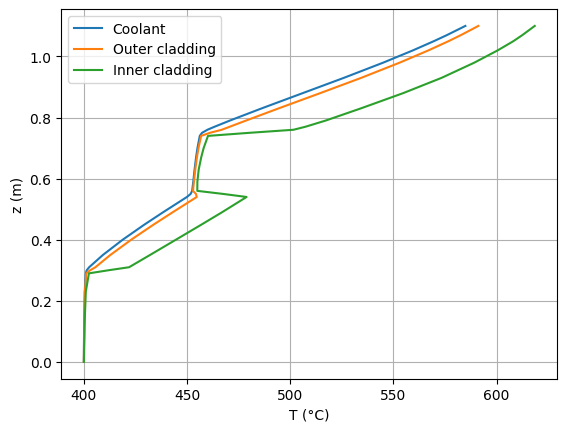

In [ ]:
#CLADDING

def cp_c(T):
  T_k = T_kelvin(T)
  return 431+0.77*T_k+8.72E-5*(T_k)**-2

def k_clad(T):
  return 13.95+0.01163*T # T in Celsius

T_co_max = max(T_co)
T_melt_clad = 1400 # Melting temperature of the cladding (°C)

t_clad = 0.50E-3 # m
R_ci = R_co-t_clad

DeltaT_clad = q_lin*t_clad/(2*np.pi*k_clad(T_co)*(R_ci +R_co)/2)
T_ci = T_co+DeltaT_clad

plt.figure()
plt.plot(T_cool,z,label='Coolant')
plt.plot(T_co,z,label='Outer cladding')
plt.plot(T_ci,z,label='Inner cladding')
plt.grid()
plt.legend()
plt.xlabel('T (°C)')
plt.ylabel('z (m)')

T_ci_max = max(T_ci)
print('The maximum inner cladding temperature is:',T_ci_max)

The maximum inner cladding temperature is: 620.0393055504701


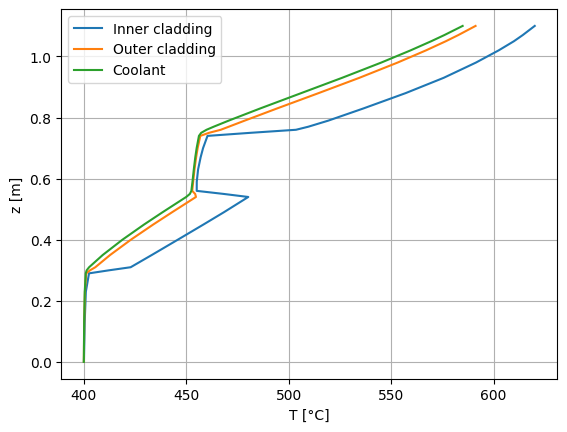

In [ ]:
#CLADDING

def cp_c(T):
  T_k = T_kelvin(T)
  return 431+0.77*T_k+8.72E-5*(T_k)**-2

def k_clad(T):
  return 13.95+0.01163*T # T in Celsius

T_co_max = max(T_co)
T_melt_clad = 1400 # Melting temperature of the cladding (°C)

t_clad = 0.50E-3 # m
R_ci = R_co-t_clad

DeltaT_clad = q_lin*t_clad/(2*np.pi*k_clad(T_co)*R_ci)
T_ci = T_co+DeltaT_clad

plt.figure()
plt.plot(T_ci,z,label='Inner cladding')
plt.plot(T_co,z,label='Outer cladding')
plt.plot(T_cool,z,label='Coolant')
plt.grid()
plt.legend()
plt.xlabel('T [°C]')
plt.ylabel('z [m]')

T_ci_max = np.max(T_ci)
print('The maximum inner cladding temperature is:',T_ci_max)

## Gap

The maximum outer fuel temperature is: 1086.9223450417255


Text(0, 0.5, 'z (m)')

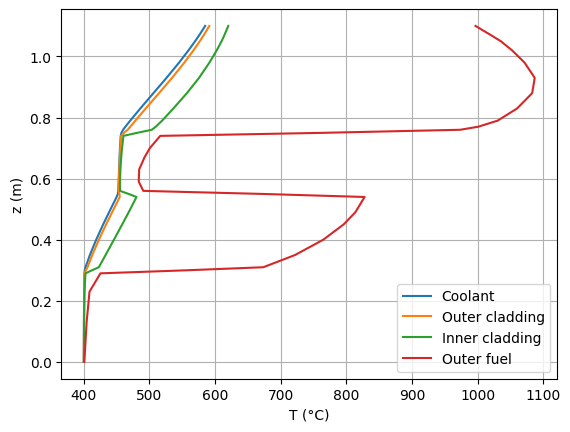

In [ ]:
#GAP - case with evaluation of conductivity using iterative process

def k_He(T) :
    T_k = T_kelvin(T)
    return 15.8E-4 *(T_k)**0.79

# thickness of the gap
t_gap = R_ci-R_fo


#Thermal resistance of the gap: since the conductivity of the gas is a function of its T we need an iterative process
#to evaluate the average temperature of the gas

T_av_gas=T_ci
T_fo=T_ci
err=100
i=0

while err>0.5:
  T_1=T_fo
  R_gap=t_gap/(2*np.pi*R_fo*k_He(T_av_gas))
  T_fo=T_ci+q_lin*R_gap
  T_2=T_fo
  T_av_gas=(T_ci+T_fo)/2
  err=np.max(np.abs(T_2-T_1))
  i=i+1

T_fo_max = np.max(T_fo)

print('The maximum outer fuel temperature is:',T_fo_max)

plt.figure()
plt.plot(T_cool,z,label='Coolant')
plt.plot(T_co,z,label='Outer cladding')
plt.plot(T_ci,z,label='Inner cladding')
plt.plot(T_fo,z,label='Outer fuel')
plt.grid()
plt.legend()
plt.xlabel('T (°C)')
plt.ylabel('z (m)')


## Fuel

The margin to melting of the fuel is: 553.7138105138338°C


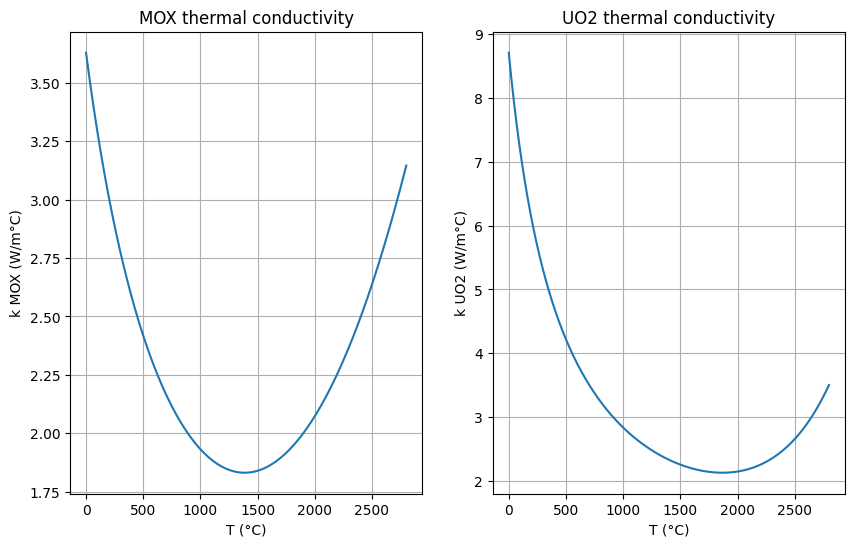

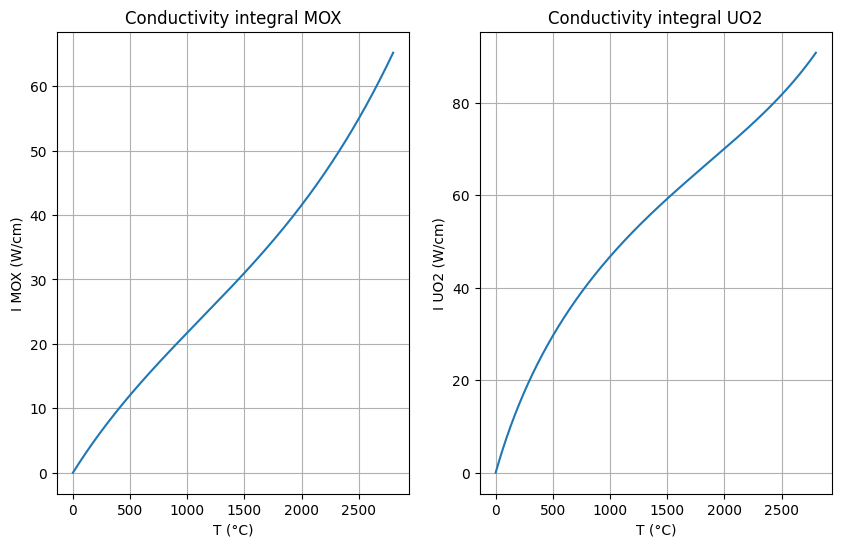

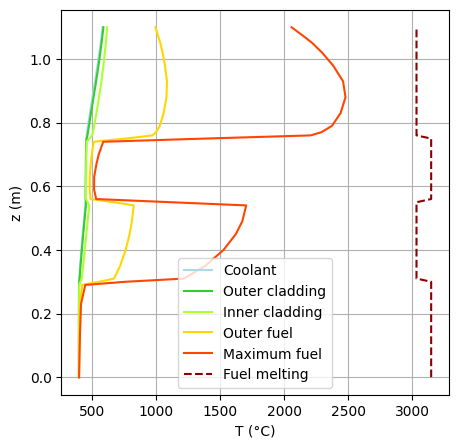

In [ ]:
#FUEL


#O/M
x_MOX=2-1.97
x_UO2 = 0

x_fuel=np.concatenate((
         np.ones(5)*x_UO2,
         np.ones(7)*x_MOX,
         np.ones(7)*x_UO2,
         np.ones(11)*x_MOX
         ))

# Burnup in GWd/tHM
bu = 0 # Replace None with the actual value
bu_fima = 0

#Porosity
po = (1-0.95)*np.ones(len(peak_factors))

#Pu concentration as Pu/(U+Pu) in %at
Pu_MOX=0.23
Pu_UO2=0

Pu_conc=np.concatenate((
         np.ones(5)*Pu_UO2,
         np.ones(7)*Pu_MOX,
         np.ones(7)*Pu_UO2,
         np.ones(11)*Pu_MOX
         ))

# Thermal Conductivity for U-Pu MOX (W m^-1 K^-1)
def k_MOX(T,Bu,x,po):
    T = T_kelvin(T)
    return (1/(1.528*np.sqrt(x+0.0093)-0.1055+0.44*Bu+ 2.885E-4*T)+76.4E-12*T**3)*1.16*((1-po)/(1+2*po))

# Thermal Conductivity for UO2-x (W m^-1 K^-1)
def k_UO2(T,Bu,po):
    return (1/(0.115+2.6E-3*Bu+2.475E-4*T)+1.216E-2*np.exp(1.867E-3*T))*((1-(2.58-5.8E-4*T)*po)/(1-(2.58-5.8E-4*T)*0.05))


# Reference temperatures for plots (°C)

T_ref_in=0
T_ref_fin=2800
Temperatures=np.linspace(T_ref_in, T_ref_fin, 2000)


# Plotting the thermal conductivities

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.plot(Temperatures,k_MOX(Temperatures,bu,x_MOX*np.ones(len(Temperatures)),po[0]*np.ones(len(Temperatures))))
plt.ylabel('k MOX (W/m°C)')
plt.xlabel('T (°C)')
plt.title('MOX thermal conductivity')
plt.grid()

plt.subplot(1,2,2)
plt.plot(Temperatures,k_UO2(Temperatures,bu,po[0]*np.ones(len(Temperatures))))
plt.ylabel('k UO2 (W/m°C)')
plt.xlabel('T (°C)')
plt.title('UO2 thermal conductivity')
plt.grid()
plt.show


# Conductivity integrals

# Conductivity integral for U-Pu MOX (W m^-1)
def I_MOX(T,Bu,x,po):

    Integ_MOX=np.zeros(len(T))
    for i in range(len(T)):
        Integ_MOX[i] = quad(k_MOX, T_kelvin(T_ref_in), T[i], args=(Bu,x[i],po[i]))[0]

    return Integ_MOX


# Conductivity integral for UO2 (W m^-1)
def I_UO2(T,Bu,po):

    Integ_UO2=np.zeros(len(T))
    for i in range(len(T)):
        Integ_UO2[i] = quad(k_UO2, T_ref_in, T[i], args=(Bu,po[i]))[0]

    return Integ_UO2


# Plotting the conductivity integrals

plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.plot(Temperatures,I_MOX(T_kelvin(Temperatures),bu,x_MOX*np.ones(len(Temperatures)),po[0]*np.ones(len(Temperatures)))*1e-2)
plt.ylabel('I MOX (W/cm)')
plt.xlabel('T (°C)')
plt.title('Conductivity integral MOX')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(Temperatures,I_UO2(Temperatures,bu,po[0]*np.ones(len(Temperatures)))*1e-2)
plt.ylabel('I UO2 (W/cm)')
plt.xlabel('T (°C)')
plt.title('Conductivity integral UO2')
plt.grid()


# Thermal resistances of fuel

# Void factor: the fissile pellets have an inner radius, while the fertile ones
#              don't have so we need to consider the void factor only on the
#              fissile ones, while the fertile ones have Fv=1

void_factor_fissile= 1-(np.log((R_fo/R_fi_fissile)**2))/((R_fo/R_fi_fissile)**2-1)
void_factor_fertile= 1

F_v=np.zeros(len(T_fo))
F_v=np.concatenate((np.ones(5)*void_factor_fertile, np.ones(7)*void_factor_fissile, np.ones(7)*void_factor_fertile, np.ones(11)*void_factor_fissile))


# Since the thermal resistance depends on the average K of the fuel and we know
# only T_fo and not T_max an iterative process is needed

T_max=T_fo+1000
err=100
i=0
def k_av_fuel(T_max,T_fo):

    k_av_fuel=np.concatenate((
            (I_UO2(T_max[0:5],bu,po[0:5])-I_UO2(T_fo[0:5],bu,po[0:5]))/(T_max[0:5]-T_fo[0:5]),          # fertile pellet nodes 1-5
            (I_MOX(T_max[5:12],bu,x_fuel[5:12],po[5:12])-I_MOX(T_fo[5:12],bu,x_fuel[5:12],po[5:12]))/(T_max[5:12]-T_fo[5:12]),    # fissile pellet nodes 6-12
            (I_UO2(T_max[12:19],bu,po[12:19])-I_UO2(T_fo[12:19],bu,po[12:19]))/(T_max[12:19]-T_fo[12:19]),    # fertile pellet nodes 13-19
            (I_MOX(T_max[19:30],bu,x_fuel[19:30],po[19:30])-I_MOX(T_fo[19:30],bu,x_fuel[19:30],po[19:30]))/(T_max[19:30]-T_fo[19:30])   # fissile pellet nodes 20-30
                  ))

    return k_av_fuel

while err>10:

    T_1=T_max
    R_fuel=(1/(4*np.pi*k_av_fuel(T_max,T_fo)))*F_v
    T_max=T_fo+(q_lin)*R_fuel
    T_2=T_max
    err=np.max(np.abs(T_2-T_1))
    i=i+1

# Melting Temperature in Kelvin
def T_melt(Pu,x,bu):
    return 2964.92 + ((3147 - 364.85*Pu - 1014.15*x) -2964.92) *np.exp(-bu/(40.43))

T_melting=T_melt(Pu_conc,x_fuel,bu)

plt.figure(figsize=(5,5))
plt.plot(T_cool,z,label='Coolant', color='lightblue')
plt.plot(T_co,z,label='Outer cladding', color='limegreen')
plt.plot(T_ci,z,label='Inner cladding', color='greenyellow')
plt.plot(T_fo,z,label='Outer fuel', color='gold')
plt.plot(T_max,z,label='Maximum fuel', color='orangered')
plt.plot(T_melting,z,label='Fuel melting', color='darkred', linestyle='--')
plt.grid()
plt.legend()
plt.xlabel('T (°C)')
plt.ylabel('z (m)')


# Margin to melting

melting_marg=np.min(T_melting-T_max)
print(f'The margin to melting of the fuel is: {melting_marg}°C')


## Summary

In [ ]:
#SUMMARY
print('The coolant temperature profile is:', T_cool)
print('The outer cladding temperature profile is:', T_co)
print('The inner cladding temperature profile is :', T_ci)
print('The fuel outer temperature is:', T_fo)
print('The fuel inner temperature is:', T_max)

The coolant temperature profile is: [400.         400.15593306 400.45580937 400.93562693 401.40547243
 402.57514652 409.21412102 418.81921252 429.43470621 438.4162883
 449.95242378 451.74957076 452.48257537 453.02482471 453.66751387
 454.39056999 455.05340296 456.17825908 457.26302054 459.87466374
 463.35072322 470.70622942 486.1470521  506.06560061 525.99718742
 545.1300152  559.47007053 569.55883601 575.92086562 584.85836224]
The outer cladding temperature profile is: [400.00797657 400.19581955 400.53559635 401.17505513 403.04201542
 405.61081705 412.82299298 422.93231424 433.89801057 443.06621754
 454.71587781 454.33933067 452.89382403 453.35392763 453.99674007
 454.80227617 455.54764123 456.83767547 461.05706157 466.81345934
 470.71743694 478.5201767  494.36693561 514.55067717 534.40897243
 553.11441647 566.99557936 576.68799445 582.7227357  591.16240032]
The inner cladding temperature profile is : [400.05350892 400.42345456 400.9907697  402.54002967 412.35847497
 422.85271358 433.

# Temperature's functions

In [ ]:
# TEMPERATURES AS FUNCTIONS OF RADIUS AND AXIAL NODES

def T_clad_out(r,m):
  return T_cool[m]+(q_lin[m])/(2*np.pi*r*h[m])

def T_clad_in(r_co,m):  # where r is radial position, m is axial position
  r_ci=r_co-t_clad
  return T_clad_out(r_co,m)+q_lin[m]*t_clad / (2*np.pi*k_clad(T_clad_out(r_co,m))*(r_ci+r_co)/2)

def T_fuel_out(r_fo,r_co,m): # where r is the fuel outer radius, r_co is the outer cladding radius
  r_ci=r_co-t_clad
  t_gap = r_ci-r_fo
  T_av_gas=T_clad_in(r_ci,m)
  T_fo=T_clad_in(r_ci,m)
  err=100
  i=0
  while err>5:
    T_1=T_fo
    R_gap=t_gap/(2*np.pi*r_fo*k_He(T_av_gas))
    T_fo=T_clad_in(r_ci,m)+(q_lin[m])*R_gap
    T_2=T_fo
    T_av_gas=(T_clad_in(r_ci,m)+T_fo)/2
    err=np.max(np.abs(T_2-T_1))
    i=i+1
  return T_fo

def F_va(r_fi,r_fo,m):
  if 0<=m<5 or 12<=m<19:
    return 1
  if 5<=m<12 or 19<=m<30:
    return 1-(np.log((r_fo/r_fi)**2)/((r_fo/r_fi)**2-1))


def T_fuel_in(r_fi,r_fo,r_co,m,bu,po):
# where bu is burnup, po is porosity, x is deviation from stechiometry (2-O/M)
    T_fo = T_fuel_out(r_fo,r_co,m)
    T_max= T_fo+1000
    err=100
    i=0
    while err>5:

        if 0<=m<5 or 12<=m<19:
            k_av_fuel = (I_UO2([T_max],bu,[po[m]])-I_UO2([T_fo],bu,[po[m]]))/(T_max-T_fo)
        if 5<=m<12 or 19<=m<30:
            k_av_fuel = (I_MOX([T_max],bu,[x_fuel[m]],[po[m]])-I_MOX([T_fo],bu,[x_fuel[m]],[po[m]]))/(T_max-T_fo)

        T_1=T_max
        R_fuel=(1/(4*np.pi*k_av_fuel))*F_va(r_fi,r_fo,m)
        T_max=T_fo+q_lin[m]*R_fuel
        T_2=T_max
        err=np.max(np.abs(T_2-T_1))
        i=i+1
    return T_max



# Radial profile Cold Geometry


24


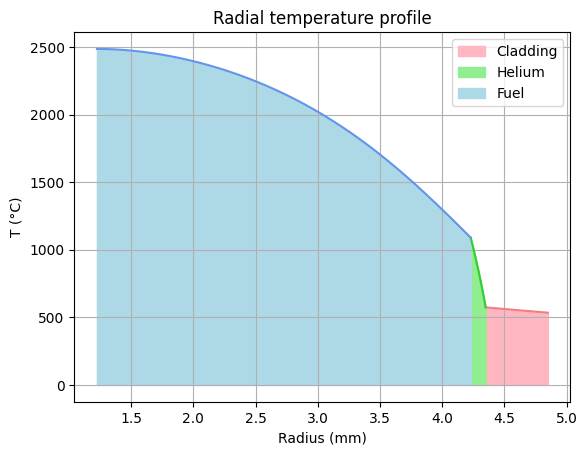

The most Inner cladding temperature is 573.7089162905929°C 
The most Outer fuel temperature is 1089.000132732618°C 
The most Inner fuel temperature is 2485.3718191964313°C 


In [ ]:
# @title Radial temperature profile @z_max (T_fo_max)

#RADIAL PROFILE of the cladding @[q_lin_max]---The whole profile is based on z coordinate where T_fo is at a maximum

max_index = np.argmax(T_fo) #Index where the Fuel outer temperature is at a maximum
print(max_index)

A = 13.95
B = 0.011643

# Equation that describes relationship between T_clad vs r: [°C]
def equation(T, r):
    return A*(T-T_co[max_index]) + B*(0.5*T**2 - 0.5*T_co[max_index]**2) + q_lin_max*np.log(r/R_co)/(2*np.pi)

r_clad_values = np.linspace(R_ci, R_co, 10000)
T_clad_values = []

# Solve for T for each r value
for r in r_clad_values:
    T_solution = fsolve(equation, 0, args=(r,))
    T_clad_values.append(T_solution[0])


#RADIAL PROFILE of the Helium gap
#(The thermal conductivity of Helium is a function of temperature therefore must be integrated)

A = 15.8*10**-4

# Equation that describes relationship between T_gap vs r:
def equation(T, r):
    return A*(T**1.79/1.79 - (273.15+T_clad_values[0])**1.79/1.79) + q_lin_max*np.log(r/R_ci)/(np.pi*2)

r_gap_values = np.linspace(R_fo, R_ci, 10000)
T_gap_values = []

# Solve T for each r value
for r in r_gap_values:
    T_solution = fsolve(equation, 0, args=(r,))
    T_gap_values.append(T_solution[0])


#RADIAL PROFILE of the Fuel

x_MOX=2-1.97
po = 1-0.95 #Defined as 100%(Ideal Density)- 95%(Real Density)
bu = 0
A = 1.528*np.sqrt(x_MOX+0.0093) - 0.1055 + 0.44*bu
B = 2.885*10**-4
C = 76.4*10**-12
D = 1.16*(1-po)/(1+2*po)


# Equation that describes relationship between T_fuel vs r:
def equation(T, r):
    q_vol = q_lin_max/(np.pi*(R_fo**2-R_fi_fissile**2))
    return (D/B)*np.log((A+B*T)/(A+B*(T_gap_values[0])))+(C*D)*(T**4 - (T_gap_values[0])**4)/4 + (q_vol/2)*(0.5*r**2 -0.5*R_fo**2)-q_vol*0.5*R_fi_fissile**2*np.log(r/R_fo)

r_fuel_values = np.linspace(R_fi_fissile, R_fo, 10000)
T_fuel_values = []

# Solve T for each r value
for r in r_fuel_values:
    T_solution = fsolve(equation, 0, args=(r,))
    T_fuel_values.append(T_solution[0])


T_fuel_values = T_fuel_values-273.15*np.ones(len(T_fuel_values)) #T_gap_values is in [°K] i convert into Celsius [°C]
T_gap_values = T_gap_values-273.15*np.ones(len(T_gap_values)) #T_gap_values is in [°K] i convert into Celsius [°C]

# Creating the plot


plt.plot(r_clad_values*1000, T_clad_values, color='lightcoral') #Cladding plot
plt.fill_between(r_clad_values*1000, T_clad_values, label='Cladding', color='lightpink')

plt.plot(r_gap_values*1000, T_gap_values, color='limegreen') #Helium gas plot
plt.fill_between(r_gap_values*1000, T_gap_values, label='Helium', color='lightGreen')

plt.plot(r_fuel_values*1000, T_fuel_values, color='cornflowerblue') #Fuel plot
plt.fill_between(r_fuel_values*1000, T_fuel_values, label='Fuel', color='lightblue')


plt.xlabel('Radius (mm)')
plt.ylabel('T (°C)')
plt.title('Radial temperature profile')
plt.legend()
plt.grid(True)
plt.show()

print(f'The most Inner cladding temperature is {T_clad_values[0]}°C ')
print(f'The most Outer fuel temperature is {T_gap_values[0]}°C ')
print(f'The most Inner fuel temperature is {T_fuel_values[0]}°C ')


# Hot geometry

## Thermal expansion

Text(0, 0.5, 'Axial length (m)')

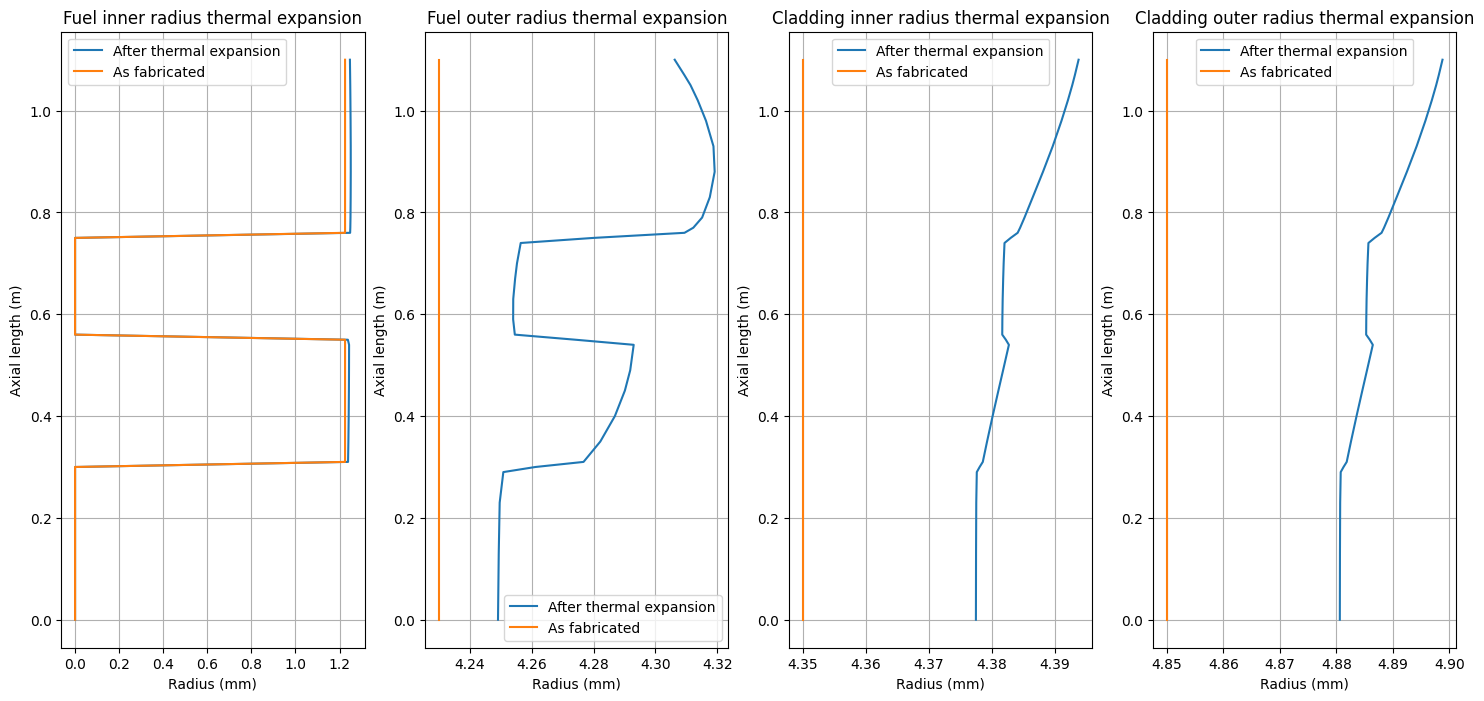

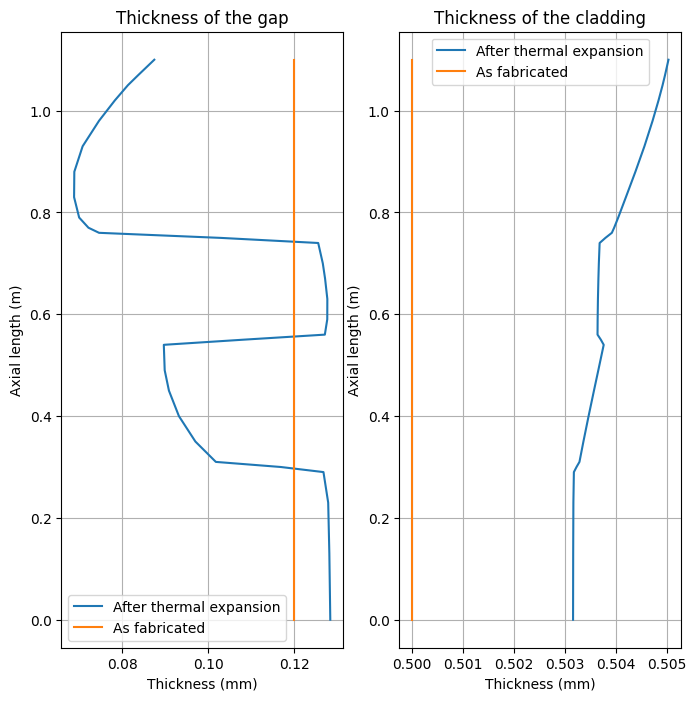

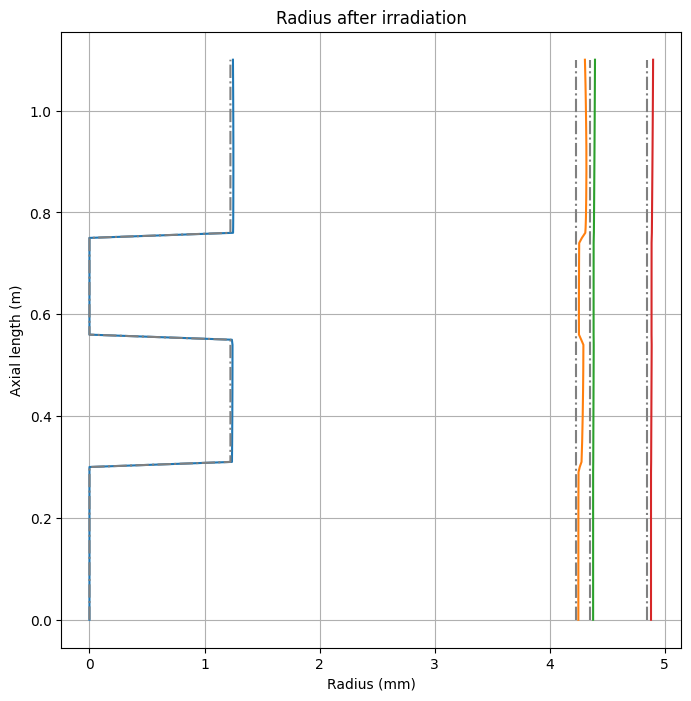

In [ ]:
# FUEL

# Linear Thermal Expansion Coefficient (°C^-1)
alpha_L = 1.2e-5
T_ref = 25 # °C

R_fi = np.concatenate((
    np.zeros(5),
    R_fi_fissile*np.ones(7),
    np.zeros(7),
    R_fi_fissile*np.ones(11)
))

# Integral mean value of temperature in fuel
po = (1-0.95)*np.ones(len(peak_factors))
T_mean_int_fuel=T_fo+(q_lin/(4*np.pi*k_av_fuel(T_max,T_fo)))*(1-(3/5)*(R_fo**5-R_fi**5)/((R_fo**3-R_fi**3)*R_fo**2))


R_fi_th = np.concatenate((
    np.zeros(5),
    R_fi_fissile + R_fi_fissile*alpha_L*((T_mean_int_fuel[5:12])-T_ref),
    np.zeros(7),
    R_fi_fissile + R_fi_fissile*alpha_L*((T_mean_int_fuel[19:30])-T_ref)
))

R_fo_th = R_fo + R_fo*alpha_L*(T_mean_int_fuel-T_ref)


# CLADDING

def eps_clad(T):
    return -3.101E-4 + 1.545E-5*T + 2.75E-9*T**2

R_ci_th = R_ci + R_ci*eps_clad((T_ci+T_co)/2)
R_co_th = R_co + R_co*eps_clad((T_ci+T_co)/2)
t_gap_th = R_ci_th-R_fo_th
t_clad_th = R_co_th-R_ci_th
deltat_th = t_clad_th-t_clad

Delta_th_fissile = R_fi_th[19:30]-R_fi_fissile

plt.figure(figsize=(18,8))

plt.subplot(1,4,1)
plt.plot(R_fi_th*1000,z,label='After thermal expansion')
plt.plot(R_fi*1000,z,label='As fabricated')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.title('Fuel inner radius thermal expansion')
plt.legend()

plt.subplot(1,4,2)
plt.plot(R_fo_th*1000,z,label='After thermal expansion')
plt.plot(R_fo*np.ones(z.size)*1000,z,label='As fabricated')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.title('Fuel outer radius thermal expansion')
plt.legend()

plt.subplot(1,4,3)
plt.plot(R_ci_th*1000,z,label='After thermal expansion')
plt.plot(R_ci*np.ones(z.size)*1000,z,label='As fabricated')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.legend()
plt.title('Cladding inner radius thermal expansion')

plt.subplot(1,4,4)
plt.plot(R_co_th*1000,z,label='After thermal expansion')
plt.plot(R_co*np.ones(z.size)*1000,z,label='As fabricated')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.legend()
plt.title('Cladding outer radius thermal expansion')

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot((R_ci_th-R_fo_th)*1000,z,label='After thermal expansion')
plt.plot(t_gap*np.ones(z.size)*1000,z,label='As fabricated')
plt.grid()
plt.legend()
plt.xlabel('Thickness (mm)')
plt.ylabel('Axial length (m)')
plt.title('Thickness of the gap')

plt.subplot(1,2,2)
plt.plot((R_co_th-R_ci_th)*1000,z,label='After thermal expansion')
plt.plot(t_clad*np.ones(z.size)*1000,z,label='As fabricated')
plt.grid()
plt.xlabel('Thickness (mm)')
plt.ylabel('Axial length (m)')
plt.legend()
plt.title('Thickness of the cladding')

plt.figure(figsize=(8,8))
plt.plot(R_fi_th*1000,z)
plt.plot(R_fi*1000,z,'-.',color='gray')
plt.plot(R_fo_th*1000,z)
plt.plot(R_fo*np.ones(z.size)*1000,z,'-.',color='gray')
plt.plot(R_ci_th*1000,z)
plt.plot(R_ci*np.ones(z.size)*1000,z,'-.',color='gray')
plt.plot(R_co_th*1000,z)
plt.plot(R_co*np.ones(z.size)*1000,z,'-.',color='gray')
plt.grid()
plt.title('Radius after irradiation')
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')

In [ ]:
#AXIAL TEMPERATURE PROFILE AFTER THERMAL EXPANSION

d_th = R_co_th*2 #outer cladding diameter after thermal expansion
D_h_th = d_th*((2*np.sqrt(3)*(p)**2)/((np.pi)*(d_th)**2) -1) # Hydraulic diameter (m)

A_th = 2*((np.sqrt(3)/4)*p**2 - (np.pi * d_th**2)/8)
v_th = m/(A_th*rho(T_cool)) # Velocity profile of the coolant (m/s)
Re_th = (rho(T_cool)*v_th*D_h_th)/mu(T_cool) #Reynolds profile of the coolant
Pr = (cp(T_cool)*mu(T_cool)/k_cool(T_cool)) #Prandlt profile of the coolant
Nu_th = 7 + 0.025*(Re_th*Pr)**0.8 #Nusselt profile of the coolant
h = Nu_th*(k_cool(T_cool)/D_h_th) # Heat transfer coefficient profile of the coolant (W/m^2 K) after thermal expansion

#CLADDING OUTER

DT_th = (q_lin)/(2*np.pi*R_co_th*h) #Temperature difference between the coolant and the outside of the claddig in each section
T_co_th = T_cool+DT_th
T_co_max_th = max(T_co_th)
print('The maximum outer cladding temperature is:',T_co_max_th)

'''
#CLADDING INNER
DeltaT_clad_th = q_lin*t_clad/(2*np.pi*k_clad(T_co_th)*(R_ci_th +R_co_th)/2)
T_ci_th = T_co_th+DeltaT_clad_th
T_ci_max_th = np.max(T_ci_th)
print('The maximum inner cladding temperature is:',T_ci_max_th)

#GAP-FUEL OUTER
T_av_gas_th=T_ci_th
T_fo_th=T_ci_th
err=100
i=0

while err>5:
  T_1=T_fo_th
  R_gap=t_gap_th/(2*np.pi*R_fo_th*k_He(T_av_gas_th))
  T_fo_th=T_ci_th+(q_lin)*R_gap
  T_2=T_fo_th
  T_av_gas_th=(T_ci_th+T_fo_th)/2
  err=np.max(np.abs(T_2-T_1))
  i=i+1

T_fo_max_th = np.max(T_fo_th)
print('The maximum outer fuel temperature is:',T_fo_max_th)

#FUEL INNER
'''

T_ci_th = np.zeros(z.size)
T_fo_th = np.zeros(z.size)
T_fi_th = np.zeros(z.size)

for i in range (z.size):
  T_ci_th[i] = T_clad_in(R_co_th[i],i)
  T_fo_th[i] = T_fuel_out(R_fo_th[i],R_co_th[i],i)
  T_fi_th[i] = T_fuel_in(R_fi_th[i],R_fo_th[i],R_co_th[i],i,bu,po)



'''
T_max_th=T_fo_th+1000
err=100
i=0

while err>10:

    T_1=T_max_th

    R_fuel=(1/(4*np.pi*k_av_fuel(T_max_th,T_fo_th)))*F_v_th
    T_max_th=T_fo_th+(q_lin_max*peak_factors)*R_fuel
    T_2=T_max_th
    err=np.max(np.abs(T_2-T_1))
    i=i+1
'''
print('The maximum inner cladding temperature is:',max(T_ci_th))
print('The maximum outer fuel temperature is:',max(T_fo_th))
print('The maximum fuel inner temperature is:', max(T_fi_th))



The maximum outer cladding temperature is: 590.6823837601798
The maximum inner cladding temperature is: 617.7106746095934
The maximum outer fuel temperature is: 924.626072553795
The maximum fuel inner temperature is: 2336.202221710057


### Radial profile

24


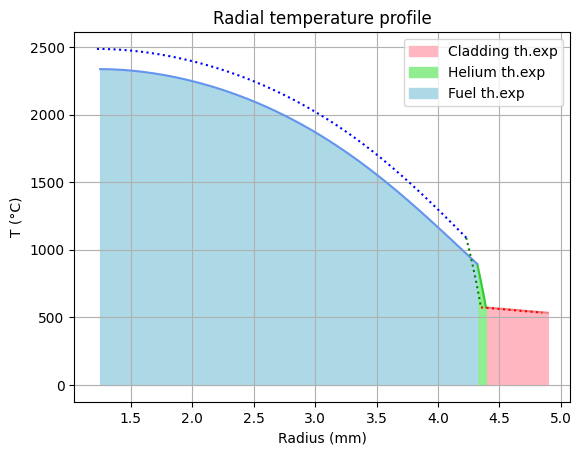

After thermal expansion the most Inner cladding temperature is 573.1403557490008°C
After thermal expansion the most Outer fuel temperature is 895.2080698683425°C
After thermal expansion the most Inner fuel temperature is 2335.8030285221294°C


In [ ]:
#RADIAL TEMPERATURE PROFILE AFTER THERMAL EXPANSION

max_index = np.argmax(T_fo) #Index where the Fuel outer temperature is at a maximum before thermal expansion, so that we compare how much the Temperatures have decreased
print(max_index)

A = 13.95
B = 0.011643

# Equation that describes relationship between T_clad vs r: [°C]
def equation_th(T, r):
    return A*(T-T_co_th[max_index]) + B*(0.5*T**2 - 0.5*T_co_th[max_index]**2) + q_lin_max*np.log(r/R_co_th[max_index])/(2*np.pi)

r_clad_values_th = np.linspace(R_ci_th[max_index], R_co_th[max_index], 10000)
T_clad_values_th = []

# Solve for T for each r value
for r in r_clad_values_th:
    T_solution_th = fsolve(equation_th, 0, args=(r,))
    T_clad_values_th.append(T_solution_th[0])


#RADIAL PROFILE of the Helium gap
#(The thermal conductivity of Helium is a function of temperature therefore must be integrated)

A = 15.8*10**-4

# Equation that describes relationship between T_gap vs r:
def equation_th(T, r):
    return A*(T**1.79/1.79 - (273.15+T_clad_values_th[0])**1.79/1.79) + q_lin_max*np.log(r/R_ci_th[max_index])/(np.pi*2)

r_gap_values_th = np.linspace(R_fo_th[max_index], R_ci_th[max_index], 10000)
T_gap_values_th = []

# Solve T for each r value
for r in r_gap_values_th:
    T_solution_th = fsolve(equation_th, 0, args=(r,))
    T_gap_values_th.append(T_solution_th[0])


#RADIAL PROFILE of the Fuel

x_MOX=2-1.97
po = 1-0.95 #Defined as 100%(Ideal Density)- 95%(Real Density)
bu = 0
A = 1.528*np.sqrt(x_MOX+0.0093) - 0.1055 + 0.44*bu
B = 2.885*10**-4
C = 76.4*10**-12
D = 1.16*(1-po)/(1+2*po)


# Equation that describes relationship between T_fuel vs r:
def equation_th(T, r):
    q_vol = q_lin_max/(np.pi*(R_fo_th[max_index]**2-R_fi_th[max_index]**2))
    return (D/B)*np.log((A+B*T)/(A+B*(T_gap_values_th[0])))+(C*D)*(T**4 - (T_gap_values_th[0])**4)/4 + (q_vol/2)*(0.5*r**2 -0.5*R_fo_th[max_index]**2)-q_vol*0.5*R_fi_th[max_index]**2*np.log(r/R_fo_th[max_index])

r_fuel_values_th = np.linspace(R_fi_th[max_index], R_fo_th[max_index], 10000)
T_fuel_values_th = []

# Solve T for each r value
for r in r_fuel_values_th:
    T_solution_th = fsolve(equation_th, 0, args=(r,))
    T_fuel_values_th.append(T_solution_th[0])


T_fuel_values_th = T_fuel_values_th-273.15*np.ones(len(T_fuel_values_th)) #T_gap_values is in [°K] i convert into Celsius [°C]
T_gap_values_th = T_gap_values_th-273.15*np.ones(len(T_gap_values_th)) #T_gap_values is in [°K] i convert into Celsius [°C]

# Creating the plot


plt.plot(r_clad_values_th*1000, T_clad_values_th, color='lightcoral') #Cladding plot
plt.fill_between(r_clad_values_th*1000, T_clad_values_th, label='Cladding th.exp', color='lightpink')

plt.plot(r_gap_values_th*1000, T_gap_values_th, color='limegreen') #Helium gas plot
plt.fill_between(r_gap_values_th*1000, T_gap_values_th, label='Helium th.exp', color='lightGreen')

plt.plot(r_fuel_values_th*1000, T_fuel_values_th, color='cornflowerblue') #Fuel plot
plt.fill_between(r_fuel_values_th*1000, T_fuel_values_th, label='Fuel th.exp', color='lightblue')

plt.plot(r_clad_values*1000, T_clad_values,':', color='red') #Cladding plot
plt.plot(r_gap_values*1000, T_gap_values,':', color='green') #Helium gas plot
plt.plot(r_fuel_values*1000, T_fuel_values,':', color='blue') #Fuel plot


plt.xlabel('Radius (mm)')
plt.ylabel('T (°C)')
plt.title('Radial temperature profile')
plt.legend()
plt.grid(True)
plt.show()

print(f'After thermal expansion the most Inner cladding temperature is {T_clad_values_th[0]}°C' )
print(f'After thermal expansion the most Outer fuel temperature is {T_gap_values_th[0]}°C')
print(f'After thermal expansion the most Inner fuel temperature is {T_fuel_values_th[0]}°C')


## Restructuring

The equiaxed grains region has radius:
 [0.00326081 0.00335334 0.00343857 0.00351165 0.00356134 0.00356498
 0.00351781 0.00345411 0.00338821 0.00332418 0.00320945]


The columnar grains region has radius:
 [0.00288887 0.003014   0.00312666 0.00321958 0.00327954 0.00327753
 0.00320649 0.00311342 0.00301762 0.00292477 0.00275601]


The void region has radius:
 [0.0014445  0.00146449 0.00148382 0.00150074 0.00151209 0.00151159
 0.00149825 0.0014819  0.00146614 0.00145173 0.00142748]


The new maximum temperature for the fuel is:
 [ 401.60993524  408.21944052  416.61759134  449.84562045  763.71312433
 1219.43473568 1384.9902801  1527.74731139 1624.06675952 1674.22250279
 1704.57383476 1117.9989771   534.88619048  518.64326115  519.2886681
  536.8048857   554.4202966   589.93599385 1378.33060042 2071.32767746
 2124.82955202 2178.95268232 2226.07297534 2255.41076615 2246.45185614
 2197.72442243 2144.6301516  2097.943414   2058.76426948 1998.5834265 ]




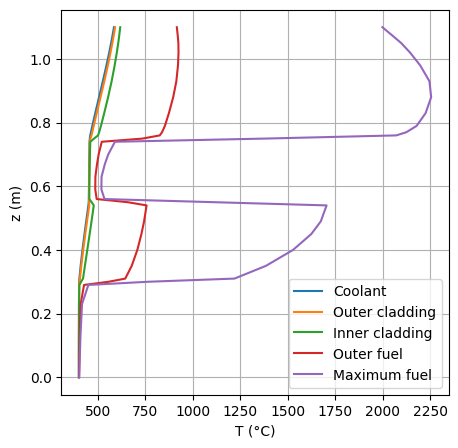

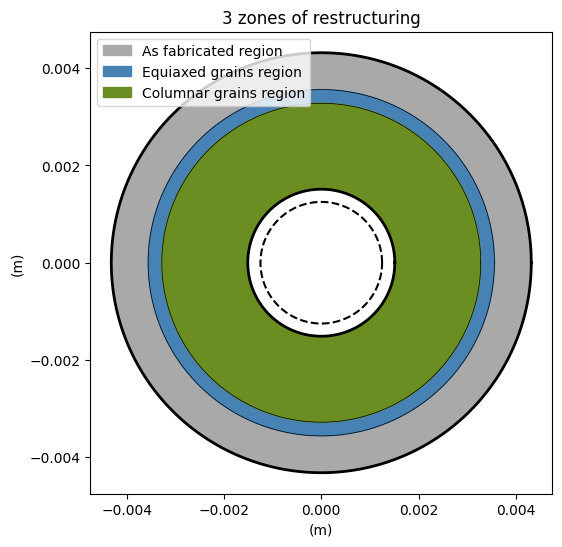

In [ ]:
# FUEL RESTRUCTURING - only on the second(from the bottom) fissile pellet (11 nodes)
#                      because is the only one in which the temperature goes
#                      above 1800°C, so the only one in which there is the
#                      formation of the central void

# Data

rho_0=0.95*np.ones(11) #units of TD
rho_eqax=0.95*np.ones(11) #units of TD
rho_clmn=0.98*np.ones(11) #units of TD

po_eqax=1-rho_eqax
po_clmn=1-rho_clmn

T_fo_th_second_fissile=T_fo_th[19:30]
q_lin_second_fissile=q_lin_max*peak_factors[19:30]
x_fuel_restruct=x_fuel[19:30]
T_eqax=np.ones(11)*1600 # °C
T_clmn=np.ones(11)*1800 # °C
R_fo_th_second_fissile=R_fo_th[19:30]
R_fi_th_second_fissile=R_fi_th[19:30]
R_fo_second_fissile=R_fo*np.ones(11)
R_fi_second_fissile=R_fi_fissile*np.ones(11)


# density as fabricated zone after thermal expansion

rho_as_fabricated=rho_0*(R_fo_second_fissile**2-R_fi_second_fissile**2)/(R_fo_th_second_fissile**2-R_fi_th_second_fissile**2)

# porosity as fabricated after thermal expansion

po_as_fabricated=1-rho_as_fabricated

# As fabricated region: find R equiaxed region

R_eqax=R_fo_th_second_fissile*(np.sqrt(1-(4*np.pi*(I_MOX(T_eqax,bu,x_fuel_restruct,po_as_fabricated)-I_MOX(T_fo_th_second_fissile,bu,x_fuel_restruct,po_as_fabricated)))/q_lin_second_fissile))

print(f'The equiaxed grains region has radius:\n {R_eqax}\n\n')

# Equiaxed grains region: find R columnar region

def equiaxed_equation(R_clmn):

    return I_MOX(T_clmn,bu,x_fuel_restruct,po_eqax)-I_MOX(T_eqax,bu,x_fuel_restruct,po_eqax)-((q_lin_second_fissile/(4*np.pi))*(rho_eqax/rho_as_fabricated)*((R_eqax/R_fo_th_second_fissile)**2)*(1-((R_clmn/R_eqax)**2)-(1-rho_as_fabricated/rho_eqax)*np.log((R_eqax/R_clmn)**2)))

R_clmn=fsolve(equiaxed_equation, R_eqax)

print(f'The columnar grains region has radius:\n {R_clmn}\n\n')

# Mass balance(3 regions model): find R of the void

R_void=np.sqrt(((rho_eqax-rho_as_fabricated)*R_eqax**2+(rho_clmn-rho_eqax)*R_clmn**2+rho_as_fabricated*R_fi_th_second_fissile**2)/rho_clmn)

print(f'The void region has radius:\n {R_void}\n\n')


# Columnar grains region: find T max fuel

Conductivity_int_Tmax_restruct=I_MOX(T_clmn,bu,x_fuel_restruct,po_clmn)+(q_lin_second_fissile/(4*np.pi))*(rho_clmn/rho_as_fabricated)*((R_clmn/R_fo_th_second_fissile)**2)*(1-((R_void/R_clmn)**2)-((R_void/R_clmn)**2)*np.log((R_clmn/R_void)**2))

def columnar_equation(T_max):

    return I_MOX(T_max,bu,x_fuel_restruct,po_clmn)-Conductivity_int_Tmax_restruct

T_max_restruct=fsolve(columnar_equation, T_max[19:30])

T_max_restruct=np.concatenate(( T_max[0:19],
                                T_max_restruct
                                ))

print(f'The new maximum temperature for the fuel is:\n {T_max_restruct}\n\n')

# plot of the new temperature profiles (thermal expansion+restructuring)

plt.figure(figsize=(5,5))
plt.plot(T_cool,z,label='Coolant')
plt.plot(T_co_th,z,label='Outer cladding')
plt.plot(T_ci_th,z,label='Inner cladding')
plt.plot(T_fo_th,z,label='Outer fuel')
plt.plot(T_max_restruct,z,label='Maximum fuel')
plt.grid()
plt.legend()
plt.xlabel('T (°C)')
plt.ylabel('z (m)')

### Plot of the fuel regions

# Generate theta values for the circles

theta = np.linspace(0, 2*np.pi, 5000)

# Radius in correspondence of the maximum axial temperature

axial_position=np.argmax(T_max_restruct)-19

# x,y coordinates fuel out

x_fo=R_fo_th_second_fissile[axial_position]*np.cos(theta)
y_fo=R_fo_th_second_fissile[axial_position]*np.sin(theta)

# x,y coordinates equiaxed grains boundary

x_eqax=R_eqax[axial_position]*np.cos(theta)
y_eqax=R_eqax[axial_position]*np.sin(theta)

# x,y coordinates columnar grains boundary

x_clmn=R_clmn[axial_position]*np.cos(theta)
y_clmn=R_clmn[axial_position]*np.sin(theta)

# x,y coordinates void boundary

x_void=R_void[axial_position]*np.cos(theta)
y_void=R_void[axial_position]*np.sin(theta)

# x,y coordinates initial central hole

x_fi=R_fi_th_second_fissile[axial_position]*np.cos(theta)
y_fi=R_fi_th_second_fissile[axial_position]*np.sin(theta)

# Plot

plt.figure(figsize=(6,6))

plt.plot(x_fo, y_fo, color='k', linewidth=2)
plt.plot(x_eqax, y_eqax, color='k', linewidth=0.5)
plt.plot(x_clmn, y_clmn, color='k', linewidth=0.5)
plt.plot(x_void, y_void, color='k', linewidth=2)
plt.plot(x_fi, y_fi, color='k', linestyle='--')


# Create the boundary and fill regions
x_as_fabricated_boundary = np.concatenate((x_eqax, x_fo[::-1]))
y_as_fabricated_boundary = np.concatenate((y_eqax, y_fo[::-1]))

plt.fill(x_as_fabricated_boundary, y_as_fabricated_boundary, color='darkgray', alpha=1)

x_eqax_boundary = np.concatenate((x_clmn, x_eqax[::-1]))
y_eqax_boundary = np.concatenate((y_clmn, y_eqax[::-1]))

plt.fill(x_eqax_boundary, y_eqax_boundary, color='steelblue', alpha=1)

x_clmn_boundary = np.concatenate((x_void, x_clmn[::-1]))
y_clmn_boundary = np.concatenate((y_void, y_clmn[::-1]))

plt.fill(x_clmn_boundary, y_clmn_boundary, color='olivedrab', alpha=1)


# Set aspect of the plot to be equal, so the circles look like circles
plt.gca().set_aspect('equal', adjustable='box')

# Set labels and title

plt.title('3 zones of restructuring')
plt.xlabel('(m)')
plt.ylabel('(m)')
as_fabricated_patch = mpatches.Patch(color='darkgray', alpha=1, label='As fabricated region')
eqax_patch = mpatches.Patch(color='steelblue', alpha=1, label='Equiaxed grains region')
clmn_patch = mpatches.Patch(color='olivedrab', alpha=1, label='Columnar grains region')
plt.legend(handles=[as_fabricated_patch, eqax_patch, clmn_patch], loc='best')



## Thermal expansion after restructuring

Text(0, 0.5, 'Axial length (m)')

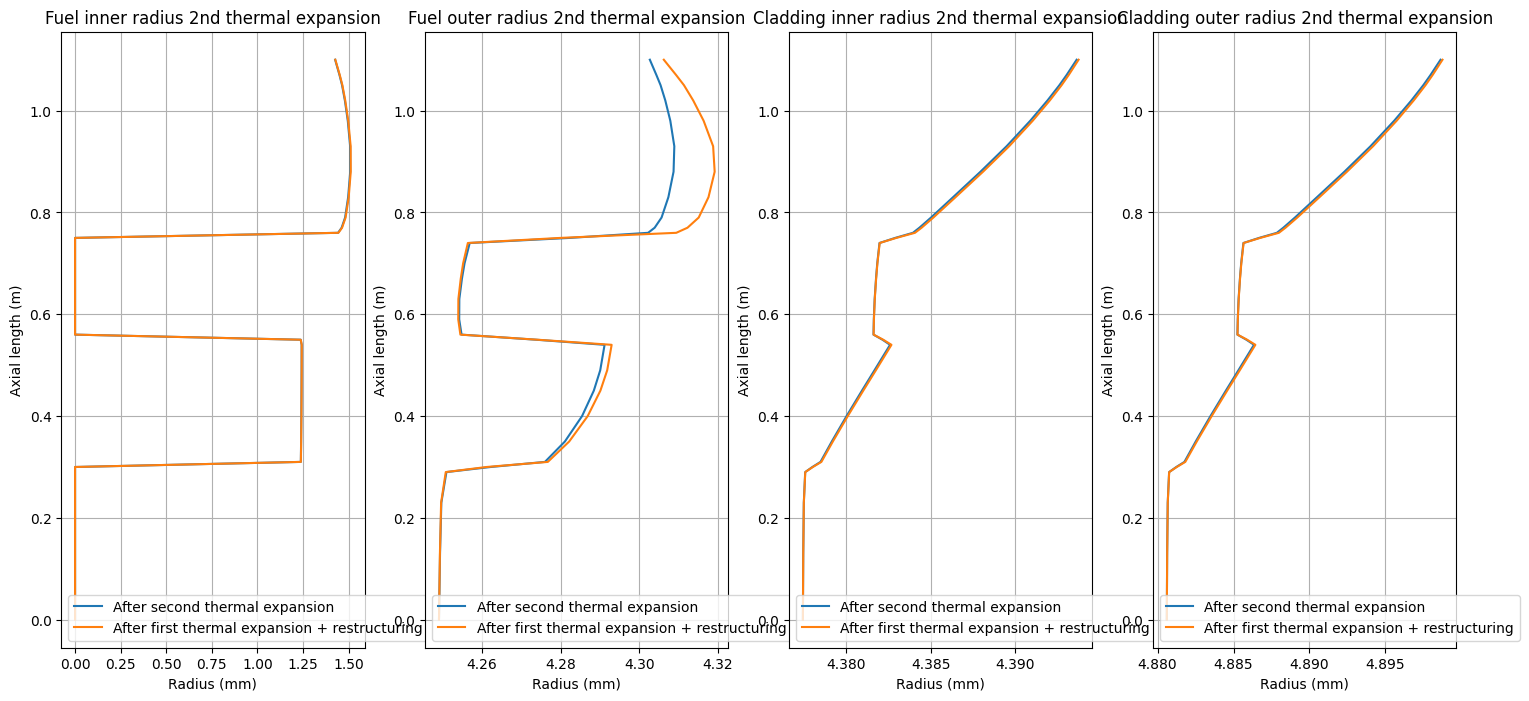

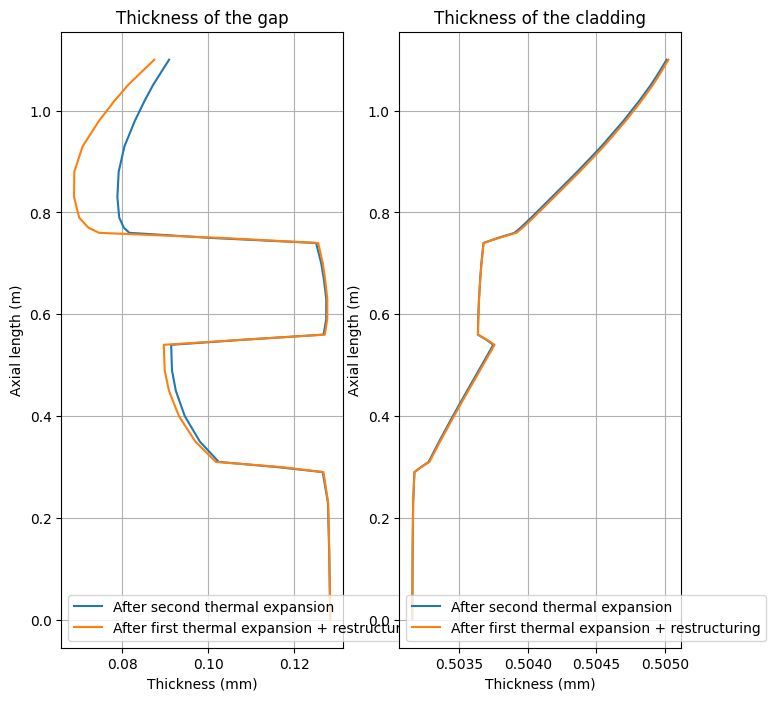

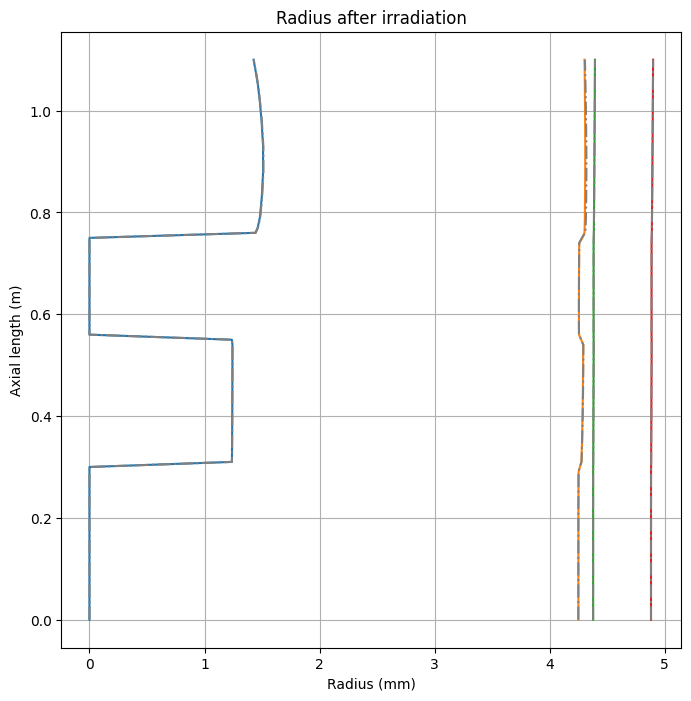

In [ ]:
# THERMAL EXPANSION after restructuring since the themperatures mainly of the fuel change significally after restructuring process
# FUEL

# Linear Thermal Expansion Coefficient (°C^-1)
alpha_L = 1.2e-5
T_ref = 25 # °C

# Mean value of temperature in fuel
T_mean_int_fuel_th2 = (T_fo_th + T_max_restruct)/2

R_fi_restr = np.concatenate((
    np.zeros(5),
    R_fi_th[5:12],
    np.zeros(7),
    R_void
))

R_fi_th2 = np.concatenate((
    np.zeros(5),
    R_fi_fissile + R_fi_fissile*alpha_L*((T_mean_int_fuel_th2[5:12])-T_ref),
    np.zeros(7),
    R_fi_fissile + R_fi_fissile*alpha_L*((T_mean_int_fuel_th2[19:30])-T_ref)
))

DeltaR_restr = np.concatenate((
    np.zeros(5),
    np.zeros(7),
    np.zeros(7),
    R_void - R_fi_th[19:30]
))

R_fi_th2 = R_fi_th2 + DeltaR_restr

R_fo_th2 = R_fo + R_fo*alpha_L*(T_mean_int_fuel_th2-T_ref)


# CLADDING

def eps_clad(T):
    return -3.101E-4 + 1.545E-5*T + 2.75E-9*T**2

R_ci_th2 = R_ci + R_ci*eps_clad((T_ci_th+T_co_th)/2)
R_co_th2 = R_co + R_co*eps_clad((T_ci_th+T_co_th)/2)
t_gap_th2 = R_ci_th2-R_fo_th2
t_clad_th2 = R_co_th2-R_ci_th2
deltat_th2 = t_clad_th2-t_clad_th

plt.figure(figsize=(18,8))

plt.subplot(1,4,1)
plt.plot(R_fi_th2*1000,z,label='After second thermal expansion')
plt.plot(R_fi_restr*1000,z,label='After first thermal expansion + restructuring')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.title('Fuel inner radius 2nd thermal expansion')
plt.legend()

plt.subplot(1,4,2)
plt.plot(R_fo_th2*1000,z,label='After second thermal expansion')
plt.plot(R_fo_th*1000,z,label='After first thermal expansion + restructuring')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.title('Fuel outer radius 2nd thermal expansion')
plt.legend()

plt.subplot(1,4,3)
plt.plot(R_ci_th2*1000,z,label='After second thermal expansion')
plt.plot(R_ci_th*1000,z,label='After first thermal expansion + restructuring')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.legend()
plt.title('Cladding inner radius 2nd thermal expansion')

plt.subplot(1,4,4)
plt.plot(R_co_th2*1000,z,label='After second thermal expansion')
plt.plot(R_co_th*1000,z,label='After first thermal expansion + restructuring')
plt.grid()
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')
plt.legend()
plt.title('Cladding outer radius 2nd thermal expansion')

plt.figure(figsize=(8,8))

plt.subplot(1,2,1)
plt.plot((R_ci_th2-R_fo_th2)*1000,z,label='After second thermal expansion')
plt.plot(t_gap_th*1000,z,label='After first thermal expansion + restructuring')
plt.grid()
plt.legend()
plt.xlabel('Thickness (mm)')
plt.ylabel('Axial length (m)')
plt.title('Thickness of the gap')

plt.subplot(1,2,2)
plt.plot((R_co_th2-R_ci_th2)*1000,z,label='After second thermal expansion')
plt.plot(t_clad_th*1000,z,label='After first thermal expansion + restructuring')
plt.grid()
plt.xlabel('Thickness (mm)')
plt.ylabel('Axial length (m)')
plt.legend()
plt.title('Thickness of the cladding')

plt.figure(figsize=(8,8))
plt.plot(R_fi_th2*1000,z)
plt.plot(R_fi_restr*1000,z,'-.',color='gray')
plt.plot(R_fo_th2*1000,z)
plt.plot(R_fo_th*1000,z,'-.',color='gray')
plt.plot(R_ci_th2*1000,z)
plt.plot(R_ci_th*1000,z,'-.',color='gray')
plt.plot(R_co_th2*1000,z)
plt.plot(R_co_th*1000,z,'-.',color='gray')
plt.grid()
plt.title('Radius after irradiation')
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')

The maximum outer cladding temperature is: 590.6836259067079
The maximum inner cladding temperature is: 617.9984374115904
The maximum outer fuel temperature is: 932.0498109198352
The maximum fuel inner temperature is: 2250.3429036355406


Text(0, 0.5, 'z (m)')

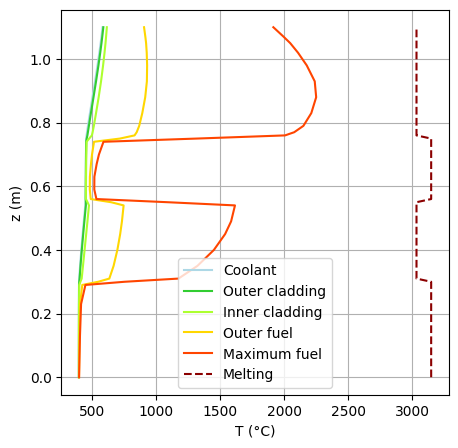

In [ ]:
#AXIAL TEMPERATURE PROFILE AFTER 2nd THERMAL EXPANSION

d_th2 = R_co_th2*2 #outer cladding diameter after thermal expansion
D_h_th2 = d_th2*((2*np.sqrt(3)*(p)**2)/((np.pi)*(d_th2)**2) -1) # Hydraulic diameter (m)

A_th2 = 2*((np.sqrt(3)/4)*p**2 - (np.pi * d_th2**2)/8)
v_th2 = m/(A_th2*rho(T_cool)) # Velocity profile of the coolant (m/s)
Re_th2 = (rho(T_cool)*v_th2*D_h_th2)/mu(T_cool) #Reynolds profile of the coolant
Pr = (cp(T_cool)*mu(T_cool)/k_cool(T_cool)) #Prandlt profile of the coolant
Nu_th2 = 7 + 0.025*(Re_th2*Pr)**0.8 #Nusselt profile of the coolant
h = Nu_th2*(k_cool(T_cool)/D_h_th2) # Heat transfer coefficient profile of the coolant (W/m^2 K) after thermal expansion

#CLADDING OUTER

DT_th2 = (q_lin)/(2*np.pi*R_co_th2*h) #Temperature difference between the coolant and the outside of the claddig in each section
T_co_th2 = T_cool+DT_th2
T_co_max_th2 = max(T_co_th2)
print('The maximum outer cladding temperature is:',T_co_max_th2)


#CLADDING INNER
DeltaT_clad_th2 = q_lin*(R_co_th2-R_ci_th2)/(2*np.pi*k_clad(T_co_th2)*(R_ci_th2 +R_co_th2)/2)
T_ci_th2 = T_co_th2 + DeltaT_clad_th2
T_ci_max_th2 = np.max(T_ci_th2)

#GAP-FUEL OUTER
T_av_gas_th2=T_ci_th2
T_fo_th2=T_ci_th2
err=100
i=0

while err>5:
  T_1=T_fo_th2
  R_gap=t_gap_th2/(2*np.pi*R_fo_th2*k_He(T_av_gas_th2))
  T_fo_th2=T_ci_th2+(q_lin)*R_gap
  T_2=T_fo_th2
  T_av_gas_th2=(T_ci_th2+T_fo_th2)/2
  err=np.max(np.abs(T_2-T_1))
  i=i+1

#FUEL INNER

F_v_th2 = np.ones(z.size)
po = po*np.ones(z.size)

for i in range (z.size):
  F_v_th2[i] = F_va(R_fi_th2[i],R_fo_th2[i],i)

T_max_th2=T_fo_th2+1000
err=100
i=0

while err>10:

    T_1=T_max_th2
    R_fuel=(1/(4*np.pi*k_av_fuel(T_max_th2,T_fo_th2)))*F_v_th2
    T_max_th2=T_fo_th2+q_lin*R_fuel
    T_2=T_max_th2
    err=np.max(np.abs(T_2-T_1))
    i=i+1

print('The maximum inner cladding temperature is:',max(T_ci_th2))
print('The maximum outer fuel temperature is:',max(T_fo_th2))
print('The maximum fuel inner temperature is:', max(T_max_th2))

# Melting Temperature in Kelvin
def T_melt(Pu,x,bu):
    return 2964.92 + ((3147 - 364.85*Pu - 1014.15*x) -2964.92) *np.exp(-bu/(40.43))

T_melting_th2 = T_melt(Pu_conc,x_fuel,bu)

plt.figure(figsize=(5,5))
plt.plot(T_cool,z,label='Coolant', color='lightblue')
plt.plot(T_co_th2,z,label='Outer cladding', color='limegreen')
plt.plot(T_ci_th2,z,label='Inner cladding', color='greenyellow')
plt.plot(T_fo_th2,z,label='Outer fuel', color='gold')
plt.plot(T_max_th2,z,label='Maximum fuel', color='orangered')
plt.plot(T_melting_th2,z,label='Melting', color='darkred', linestyle='--')
plt.grid()
plt.legend()
plt.xlabel('T (°C)')
plt.ylabel('z (m)')


# Radial profile Hot geometry

23


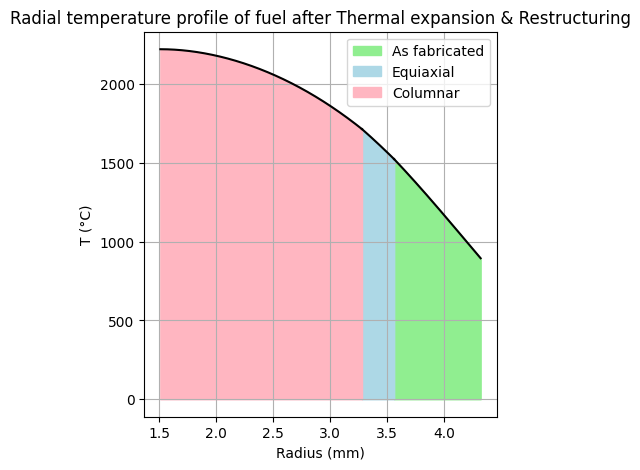

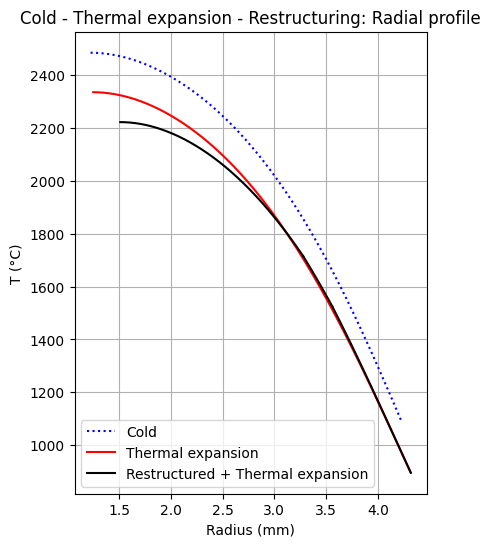

After thermal expansion and restructuring the maximum temperature in the as fabricated region is 1524.4380735095729°C
After thermal expansion and restructuring the maximum temperature in the equiaxial region is 1715.2035896158686°C
After thermal expansion and restructuring the maximum temperature in the columnar region is 2222.611726724586°C


In [ ]:
#RADIAL TEMPERATURE PROFILE AFTER THERMAL EXPANSION + RESTRUCTURING OF THE FUEL

max_index = np.argmax(T_max_restruct) #Index where the Fuel outer temperature is at a maximum after thermal expansion and restructuring
print(max_index)
#Regarding index 4 in R_as_fab, R_eqax, R_clmn:
#Because the restructuring has been counted only for pins from [19:30], index 23 corresponds to index 4 of this list

#Data
x_MOX=2-1.97
po = 1-0.95 #Defined as 100%(Ideal Density)- 95%(Real Density)
bu = 0
A = 1.528*np.sqrt(x_MOX+0.0093) - 0.1055 + 0.44*bu
B = 2.885*10**-4
C = 76.4*10**-12
D = 1.16*(1-po)/(1+2*po)
T_fo_th_max_index = T_gap_values_th[0]



#As fabricated-Equiaxial----> Zone 3

# Equation that describes relationship between T vs r:
def equation_as_fab(T,r):
    return (D/B)*np.log((A+B*T)/(A+B*(T_fo_th_max_index+273.15))) + (C*D/4)*(T**4 - (T_fo_th_max_index+273.15)**4) + q_lin_max/(np.pi*4*R_fo_th[max_index]**2)*(r**2 - R_fo_th[max_index]**2)

r_as_fab_values_th = np.linspace(R_eqax[4], R_fo_th[max_index], 10000)
T_as_fab_values_th=[]

# Solve T for each r value
for r in r_as_fab_values_th:
    T_solution_th = fsolve(equation_as_fab, 0, args=(r,))
    T_as_fab_values_th.append(T_solution_th[0])




#Equiaxial-Columnar----> Zone 2

def equation_eqax(T,r):
  q_eqax_3= (rho_eqax[4]/rho_clmn[4])*(q_lin_max/(np.pi*R_fo_th[max_index]**2)) #Volumetric equiaxial power flux [W/m3]
  q_clmn_3 = (rho_clmn[4]/rho_as_fabricated[4])*(q_lin_max/(np.pi*R_fo_th[max_index]**2)) #Volumetric columnar power flux [W/m3]
  q_as_fab_3 = q_lin_max/(np.pi*R_fo_th[max_index]**2) #Volumetric as fabricated power flux [W/m3]
  return (D/B)*np.log((A+B*T)/(A+B*(T_as_fab_values_th[0]))) + (C*D/4)*(T**4 - (T_as_fab_values_th[0])**4) + (q_eqax_3/4)*(r**2-R_eqax[4]**2) + (R_eqax[4]**2/2)*(-q_as_fab_3+q_eqax_3)*np.log(r/R_eqax[4])

r_eqax_values_th = np.linspace(R_clmn[4], R_eqax[4], 10000)
T_eqax_values_th=[]

# Solve T for each r value
for r in r_eqax_values_th:
    T_solution_th = fsolve(equation_eqax, 0, args=(r,))
    T_eqax_values_th.append(T_solution_th[0])



#Columnar-Void----> Zone 1


def equation_eqax(T,r):
  q_clmn_3 = (rho_clmn[4]/rho_as_fabricated[4])*(q_lin_max/(np.pi*R_fo_th[max_index]**2)) #Volumetric columnar power flux [W/m3]
  return (D/B)*np.log((A+B*T)/(A+B*(T_eqax_values_th[0]))) + (C*D/4)*(T**4 - (T_eqax_values_th[0])**4) - (q_clmn_3/4)*(-r**2+R_clmn[4]**2) - (R_void[4]**2)*(q_clmn_3/2)*np.log(r/R_clmn[4])

r_clmn_values_th = np.linspace(R_void[4], R_clmn[4], 10000)
T_clmn_values_th=[]

# Solve T for each r value
for r in r_clmn_values_th:
    T_solution_th = fsolve(equation_eqax, 0, args=(r,))
    T_clmn_values_th.append(T_solution_th[0])



T_as_fab_values_th = T_as_fab_values_th-273.15*np.ones(len(T_as_fab_values_th)) #Temperature is in [°K] i convert it into [°C]
T_eqax_values_th = T_eqax_values_th-273.15*np.ones(len(T_eqax_values_th)) #Temperature is in [°K] i convert it into [°C]
T_clmn_values_th = T_clmn_values_th-273.15*np.ones(len(T_clmn_values_th)) #Temperature is in [°K] i convert it into [°C]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(r_as_fab_values_th*1000, T_as_fab_values_th, color='black') #As fabricated plot
plt.fill_between(r_as_fab_values_th*1000, T_as_fab_values_th, label='As fabricated', color='lightGreen')

plt.plot(r_eqax_values_th*1000, T_eqax_values_th, color='black') #Equiaxial plot
plt.fill_between(r_eqax_values_th*1000, T_eqax_values_th, label='Equiaxial', color='lightblue')

plt.plot(r_clmn_values_th*1000, T_clmn_values_th, color='black') #Columnar plot
plt.fill_between(r_clmn_values_th*1000, T_clmn_values_th, label='Columnar', color='lightPink')


plt.xlabel('Radius (mm)')
plt.ylabel('T (°C)')
plt.title('Radial temperature profile of fuel after Thermal expansion & Restructuring')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.subplot(1,2,2)
plt.plot(r_fuel_values*1000, T_fuel_values,':',label='Cold', color='blue') #Fuel plot
plt.plot(r_fuel_values_th*1000, T_fuel_values_th,label='Thermal expansion', color='red') #Fuel plot
plt.plot(r_as_fab_values_th*1000, T_as_fab_values_th,label='Restructured + Thermal expansion', color='black') #As fabricated plot
plt.plot(r_eqax_values_th*1000, T_eqax_values_th,color='black') #Equiaxial plot
plt.plot(r_clmn_values_th*1000, T_clmn_values_th,color='black') #Columnar plot


plt.xlabel('Radius (mm)')
plt.ylabel('T (°C)')
plt.title('Cold - Thermal expansion - Restructuring: Radial profile')
plt.legend()
plt.grid(True)
plt.show()

print(f'After thermal expansion and restructuring the maximum temperature in the as fabricated region is {T_as_fab_values_th[0]}°C' )
print(f'After thermal expansion and restructuring the maximum temperature in the equiaxial region is {T_eqax_values_th[0]}°C')
print(f'After thermal expansion and restructuring the maximum temperature in the columnar region is {T_clmn_values_th[0]}°C')


# Mechanical analysis BOL


##Definition of quantities

In [ ]:
# QUANTITIES FOR MECHANICAL ANALYSYS

### Material properties

# Linear thermal expansion coefficient

# writing the quadratic correlation of eps_clad as eps=alpha(T)*(T_Tref) with alpha(T)=a+b*T we find
def alpha_clad(T):
  return 1.55e-5+2.75e-9*T

# Thermal expansion coefficient (radial mean value)
def alpha_clad_mean(i):
   return (alpha_clad(T_ci_th[i])+alpha_clad(T_co_th[i]))/2 # use arithmetic mean because alpha_clad is a linear function

# Young's modulus (radial mean value)
def E_clad(T):
  return (202.7-(81.67e-3)*T)*1e9 # in Pa

def E_clad_mean(i):
  return (E_clad(T_ci_th[i])+E_clad(T_co_th[i]))/2 # use arithmetic mean because E_clad is a linear function

# Poisson ratio (radial mean value)
def nu_clad(T):
  return 0.277+(6e-5)*T

def nu_clad_mean(i):
  return (nu_clad(T_ci_th[i])+nu_clad(T_co_th[i]))/2 # use arithmetic mean because E_clad is a linear function


### Mesh

N_radial = 30
Points = np.zeros((z.size, N_radial))

for i in range(z.size):
  Points[i][:] = np.linspace(R_ci_th[i], R_co_th[i], N_radial)


### Inner and outer pressure cladding

P_He_cold = 0.1e6 #Pa
T_He_cold = 293 #K

T_He_hot = np.max((T_fo_th2+T_ci_th)/2)+273 #consider worst case in which all the He is at the highest possible T

#since the heating up of the pin is an isochoric process P1/T1 = P2/T2
P_He_hot = P_He_cold*(T_He_hot/T_He_cold)

P_coolant = 0.3e6 #Pa     # not considering pressure losses and gravity

P_in = P_He_hot
P_out = P_coolant
P = P_in - P_out

print(f'\nInner pressure = {np.round(P_in,-3)} Pa\n')
print(f'\nOuter pressure = {np.round(P_out,-3)} Pa\n')


### axial point where to evaluate stress

# the axial coordinate in which makes sense evaluating the stress is the one
# in which the cladding suffers the highest temperature jump
deltaT_clad = T_ci_th-T_co_th
index=np.argmax(deltaT_clad)

print(f'\nRadial profiles evaluated in axial node {index}\n')




Inner pressure = 354000.0 Pa


Outer pressure = 300000.0 Pa


Radial profiles evaluated in axial node 23



## Cladding thermal stress

In [ ]:
# CLADDING THERMAL STRESS (NO MECHANICAL LOAD)


# Radial temperature profile in cladding as function of axial node i and position r
def T_clad_rad(i,r):
  m = (T_ci_th[i]-T_co_th[i])/(R_ci_th[i]-R_co_th[i])
  return T_co_th[i]+m*(r-R_co_th[i])

# Thermal stress matrices

sigma_r_th_BOL = np.zeros((z.size, N_radial))
sigma_theta_th_BOL = np.zeros((z.size, N_radial))
sigma_z_th_BOL = np.zeros((z.size, N_radial))

integral_1 = np.zeros(z.size)
integral_2 = np.zeros((z.size,N_radial))

for k in range(z.size):

  integral_1[k] = quad(lambda r: T_clad_rad(k,r)*r, R_ci_th[k], R_co_th[k])[0]

  for j in range(N_radial):

    integral_2[k][j] = quad(lambda r: T_clad_rad(k,r)*r, R_ci_th[k], Points[k][j])[0]

    sigma_r_th_BOL[k][j] = (alpha_clad_mean(k)*E_clad_mean(k))/((1-nu_clad_mean(k))*Points[k][j]**2)*((Points[k][j]**2-R_ci_th[k]**2)/(R_co_th[k]**2-R_ci_th[k]**2)*integral_1[k]-integral_2[k][j])
    sigma_theta_th_BOL[k][j] = (alpha_clad_mean(k)*E_clad_mean(k))/((1-nu_clad_mean(k))*Points[k][j]**2)*((Points[k][j]**2+R_ci_th[k]**2)/(R_co_th[k]**2-R_ci_th[k]**2)*integral_1[k]+integral_2[k][j]-T_clad_rad(k,Points[k][j])*Points[k][j]**2)
    sigma_z_th_BOL[k][j] = sigma_r_th_BOL[k][j]+sigma_theta_th_BOL[k][j]




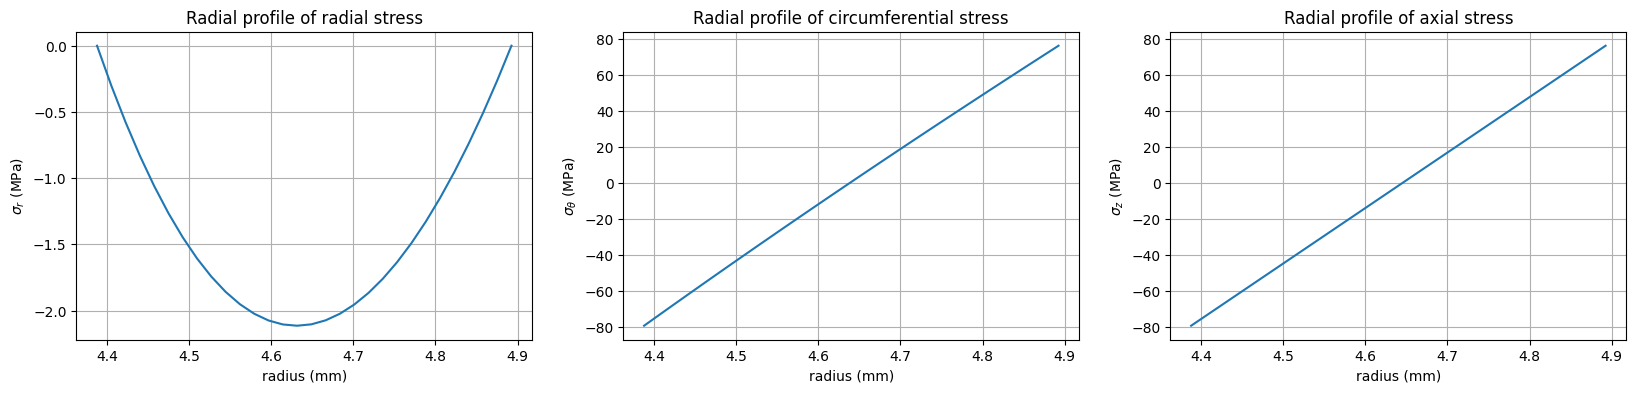

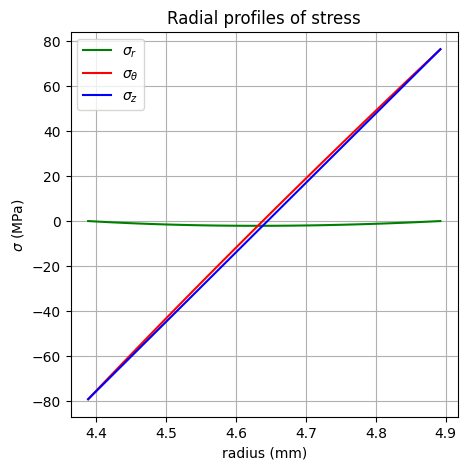

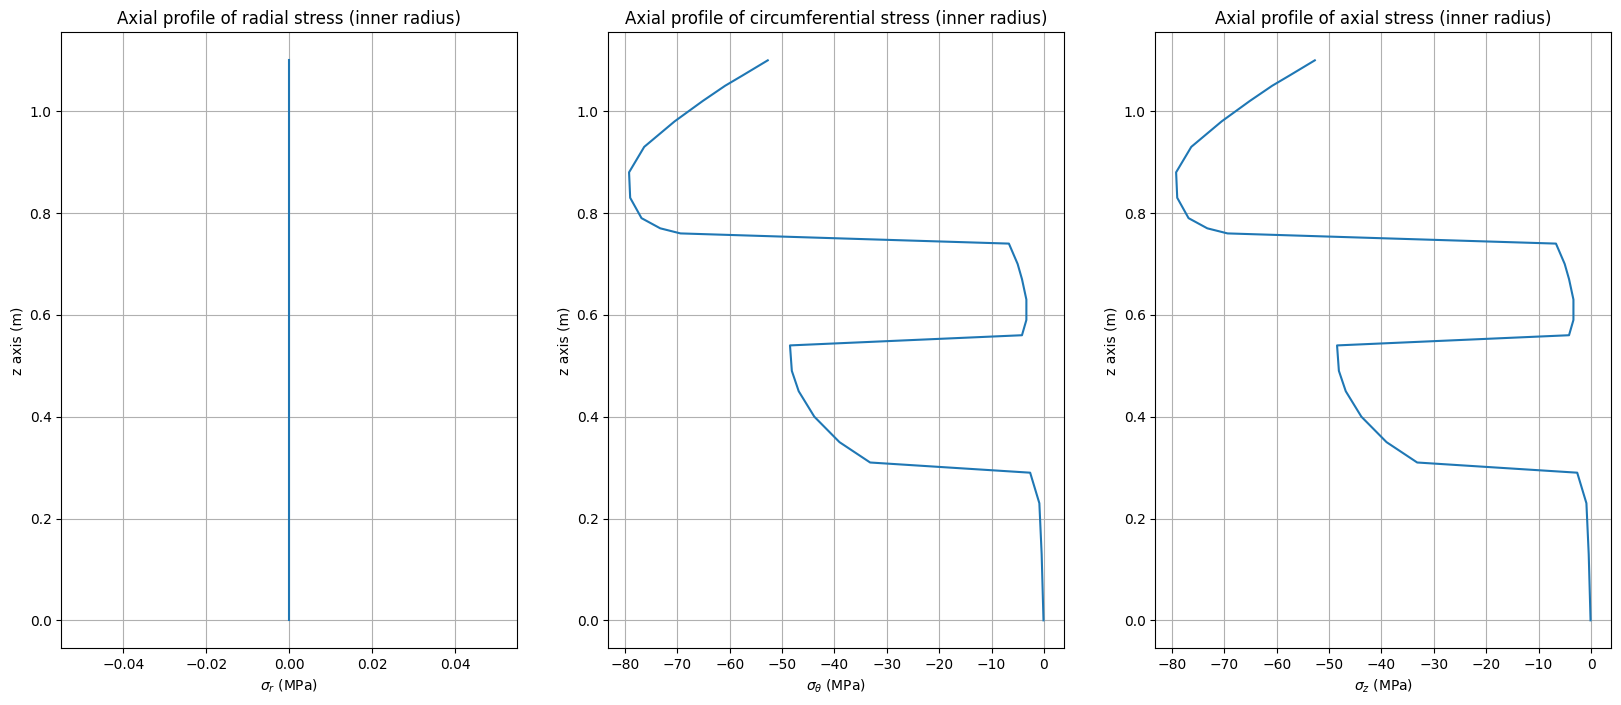

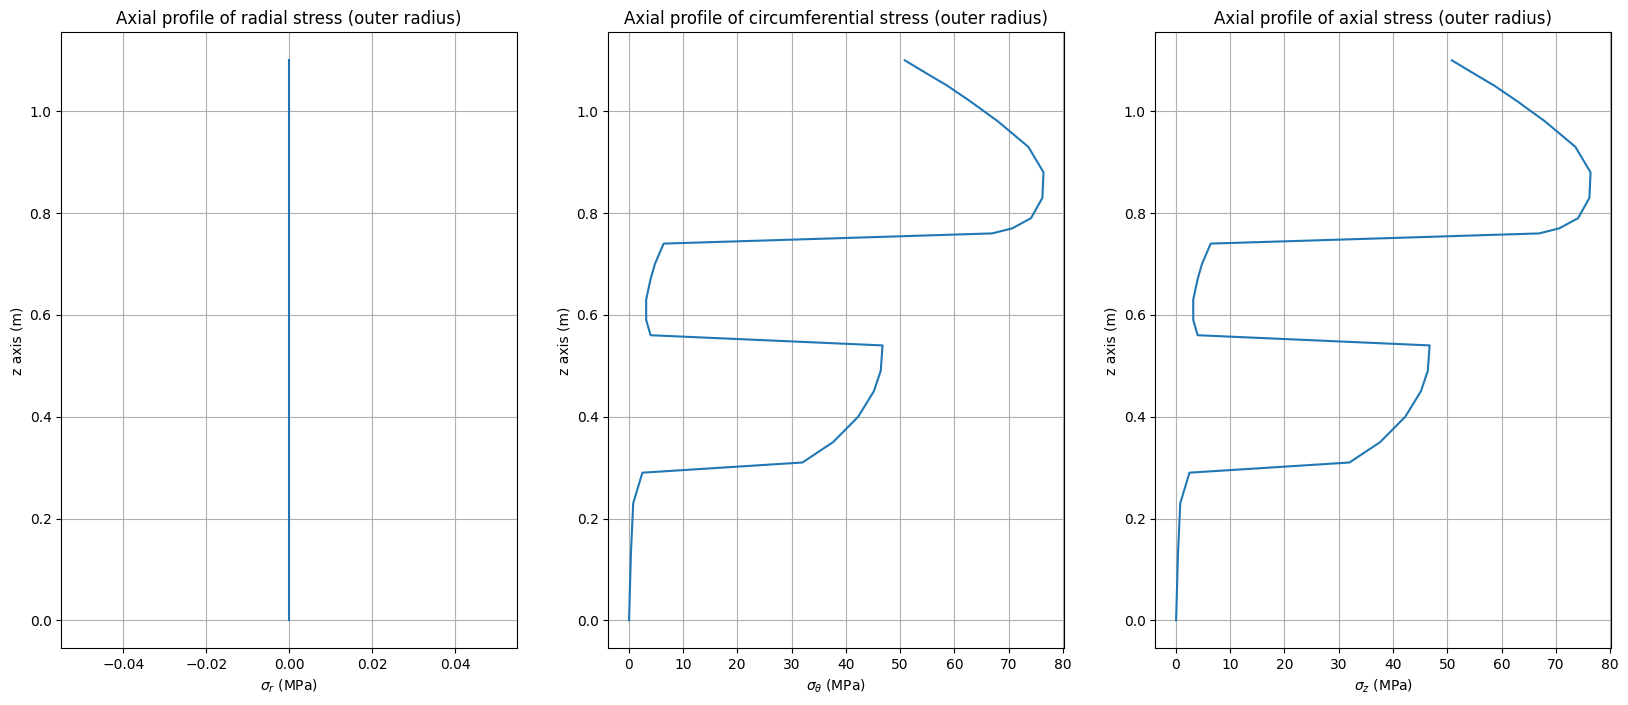

In [ ]:
# Plots

# radial plots

plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot(Points[index,:]*1e3, sigma_r_th_BOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{r}$ (MPa)')
plt.title('Radial profile of radial stress')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Points[index,:]*1e3, sigma_theta_th_BOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Radial profile of circumferential stress')
plt.grid()

plt.subplot(1,3,3)
plt.plot(Points[index,:]*1e3, sigma_z_th_BOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{z}$ (MPa)')
plt.title('Radial profile of axial stress')
plt.grid()

plt.figure(figsize=(5,5))

plt.plot(Points[index,:]*1e3, sigma_r_th_BOL[index,:]*1e-6, color='g', label='$\sigma_{r}$')
plt.plot(Points[index,:]*1e3, sigma_theta_th_BOL[index,:]*1e-6, color='r', label='$\sigma_{\\theta}$')
plt.plot(Points[index,:]*1e3, sigma_z_th_BOL[index,:]*1e-6, color='b', label='$\sigma_{z}$')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma$ (MPa)')
plt.title('Radial profiles of stress')
plt.legend()
plt.grid()


# axial plots


# inner radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_th_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (inner radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_th_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (inner radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_th_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (inner radius)')
plt.grid()

# outer radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_th_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (outer radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_th_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (outer radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_th_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (outer radius)')
plt.grid()


## Cladding mechanical stress


In [ ]:
# CLADDING MECHANICAL LOAD (NO TEMPERATURE GRADIENT)


# Mechanical stress matrices with Lamè profiles

sigma_r_mec_BOL = np.zeros((z.size, N_radial))
sigma_theta_mec_BOL = np.zeros((z.size, N_radial))
sigma_z_mec_BOL = np.zeros((z.size, N_radial))

C1 = np.zeros(z.size)
C2 = np.zeros(z.size)

for k in range(z.size):

  C1[k] = P*(R_co_th[k]**2*R_ci_th[k]**2)/(R_co_th[k]**2-R_ci_th[k]**2)
  C2[k]=  P*(R_ci_th[k]**2)/(R_co_th[k]**2-R_ci_th[k]**2)

  for j in range(N_radial):

    sigma_r_mec_BOL[k][j] = -C1[k]/Points[k][j]**2+C2[k]-P_out
    sigma_theta_mec_BOL[k][j] = C1[k]/Points[k][j]**2+C2[k]-P_out
    sigma_z_mec_BOL[k][j] = nu_clad_mean(k)*2*(C2[k]-P_out)  # hypothesis of plane strain eps_z=0


# Mechanical stress matrices with Mariotte profiles

sigma_r_mec_Mar_BOL = np.zeros((z.size, N_radial))
sigma_theta_mec_Mar_BOL = np.zeros((z.size, N_radial))
sigma_z_mec_Mar_BOL = np.zeros((z.size, N_radial))

R = np.zeros(z.size)
t = np.zeros(z.size)

for k in range(z.size):

  R[k] = (R_co_th[k]+R_ci_th[k])/2
  t[k] = R_co_th[k]-R_ci_th[k]

  for j in range(N_radial):

    sigma_r_mec_Mar_BOL[k][j] = -P/2-P_out
    sigma_theta_mec_Mar_BOL[k][j] = P*R[k]/t[k]-P_out
    sigma_z_mec_Mar_BOL[k][j] = P*R[k]/(2*t[k])-P_out

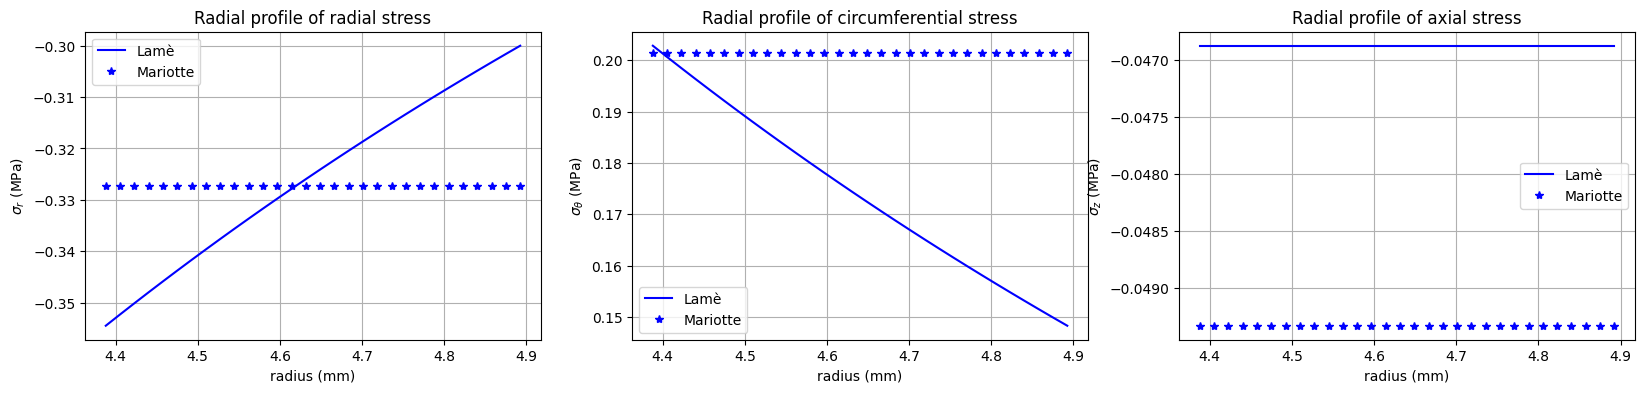

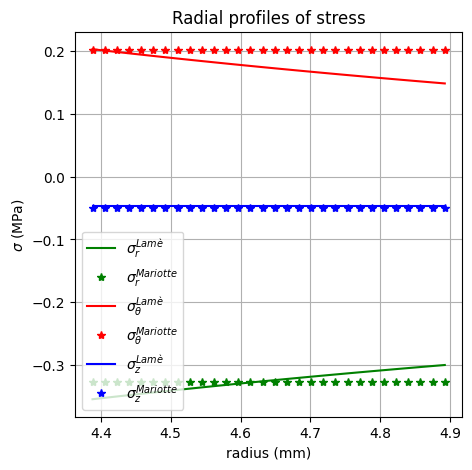

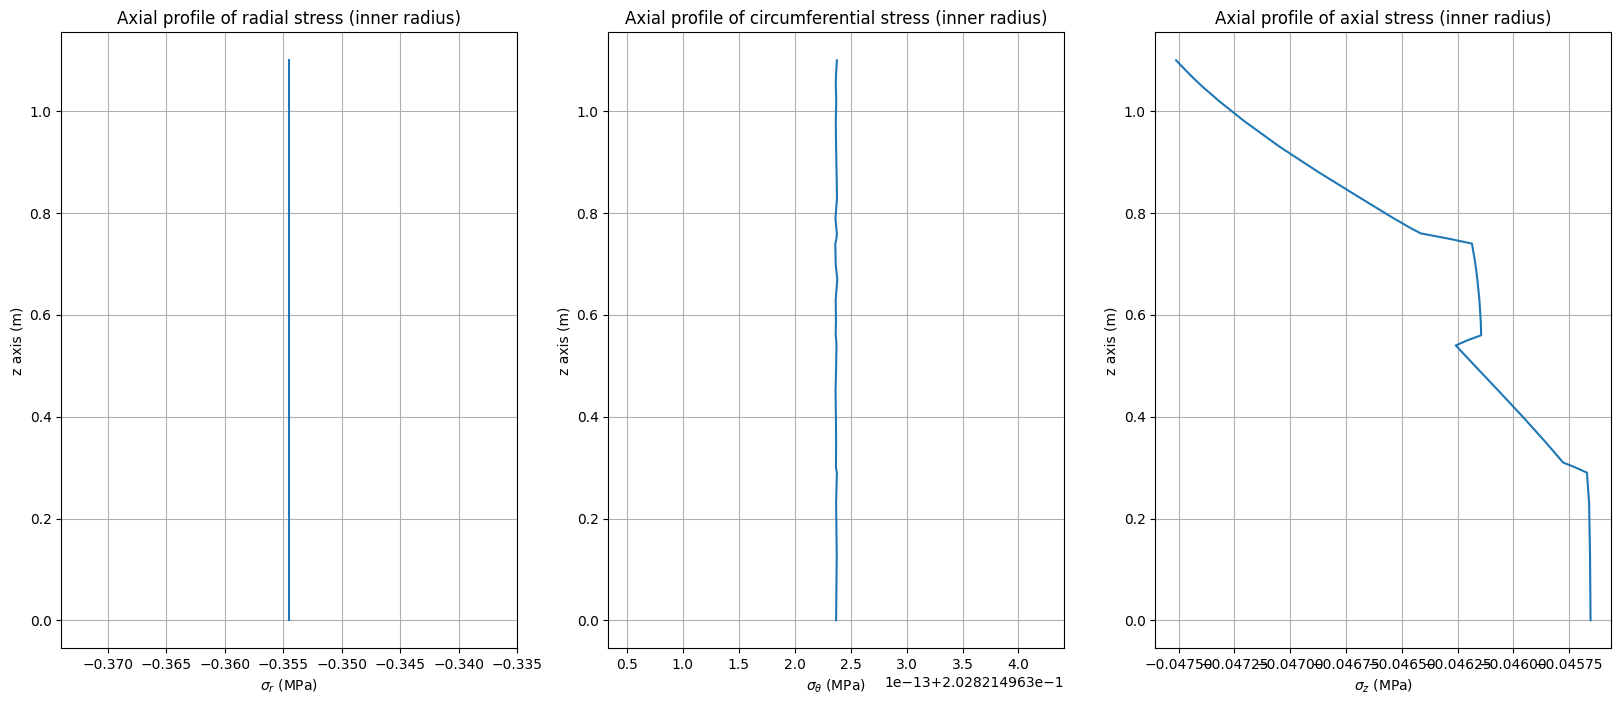

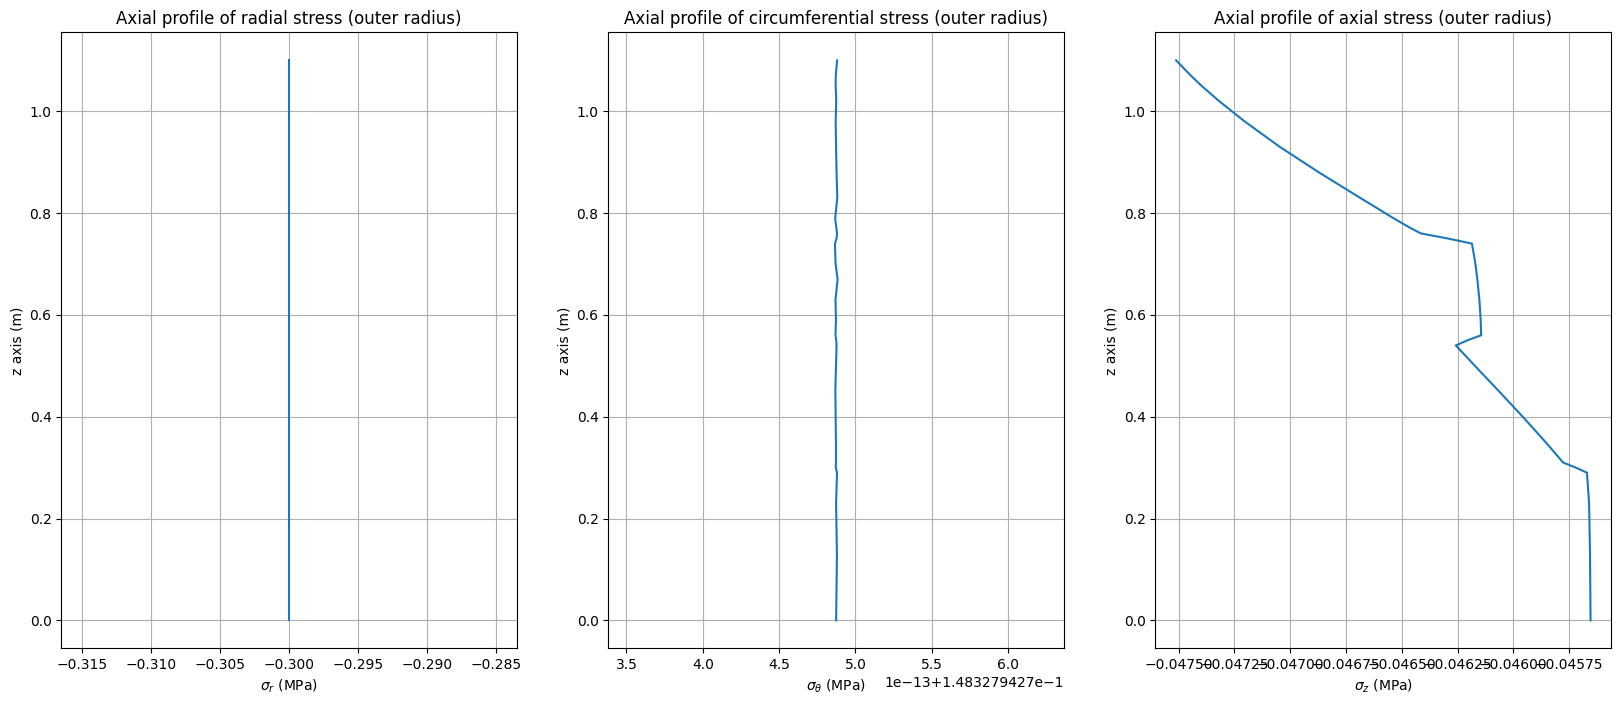

In [ ]:
# Plots

# radial plots

plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot(Points[index,:]*1e3, sigma_r_mec_BOL[index,:]*1e-6, 'b-',  label='Lamè')
plt.plot(Points[index,:]*1e3, sigma_r_mec_Mar_BOL[index,:]*1e-6, 'b*',  label='Mariotte')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{r}$ (MPa)')
plt.title('Radial profile of radial stress')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(Points[index,:]*1e3, sigma_theta_mec_BOL[index,:]*1e-6, 'b-',  label='Lamè')
plt.plot(Points[index,:]*1e3, sigma_theta_mec_Mar_BOL[index,:]*1e-6, 'b*',  label='Mariotte')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Radial profile of circumferential stress')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(Points[index,:]*1e3, sigma_z_mec_BOL[index,:]*1e-6, 'b-',  label='Lamè')
plt.plot(Points[index,:]*1e3, sigma_z_mec_Mar_BOL[index,:]*1e-6, 'b*',  label='Mariotte')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{z}$ (MPa)')
plt.title('Radial profile of axial stress')
plt.legend()
plt.grid()

plt.figure(figsize=(5,5))

plt.plot(Points[index,:]*1e3, sigma_r_mec_BOL[index,:]*1e-6, color='g', label='$\sigma_{r}^{Lamè}$')
plt.plot(Points[index,:]*1e3, sigma_r_mec_Mar_BOL[index,:]*1e-6, 'g*',  label='$\sigma_{r}^{Mariotte}$')
plt.plot(Points[index,:]*1e3, sigma_theta_mec_BOL[index,:]*1e-6, color='r', label='$\sigma_{\\theta}^{Lamè}$')
plt.plot(Points[index,:]*1e3, sigma_theta_mec_Mar_BOL[index,:]*1e-6, 'r*',  label='$\sigma_{\\theta}^{Mariotte}$')
plt.plot(Points[index,:]*1e3, sigma_z_mec_BOL[index,:]*1e-6, color='b', label='$\sigma_{z}^{Lamè}$')
plt.plot(Points[index,:]*1e3, sigma_z_mec_Mar_BOL[index,:]*1e-6, 'b*',  label='$\sigma_{z}^{Mariotte}$')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma$ (MPa)')
plt.title('Radial profiles of stress')
plt.legend()
plt.grid()


# axial plots


# inner radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_mec_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (inner radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_mec_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (inner radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_mec_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (inner radius)')
plt.grid()

# outer radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_mec_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (outer radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_mec_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (outer radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_mec_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (outer radius)')
plt.grid()

##Cladding total stress


In [ ]:
# CLADDING WITH PRESSURE AND TEMPERATURE GRADIENT

#Since we are deling with a linear equation the sum of the 2 previous
#solutions is still solution of the problem

# Total stress matrices (for the mechanical part use Lamè profiles)

sigma_r_BOL = np.zeros((z.size, N_radial))
sigma_theta_BOL = np.zeros((z.size, N_radial))
sigma_z_BOL = np.zeros((z.size, N_radial))


for k in range(z.size):

  for j in range(N_radial):

    sigma_r_BOL[k][j] = sigma_r_mec_BOL[k][j]+sigma_r_th_BOL[k][j]
    sigma_theta_BOL[k][j] = sigma_theta_mec_BOL[k][j]+sigma_theta_th_BOL[k][j]
    sigma_z_BOL[k][j] = sigma_z_mec_BOL[k][j]+sigma_z_th_BOL[k][j]


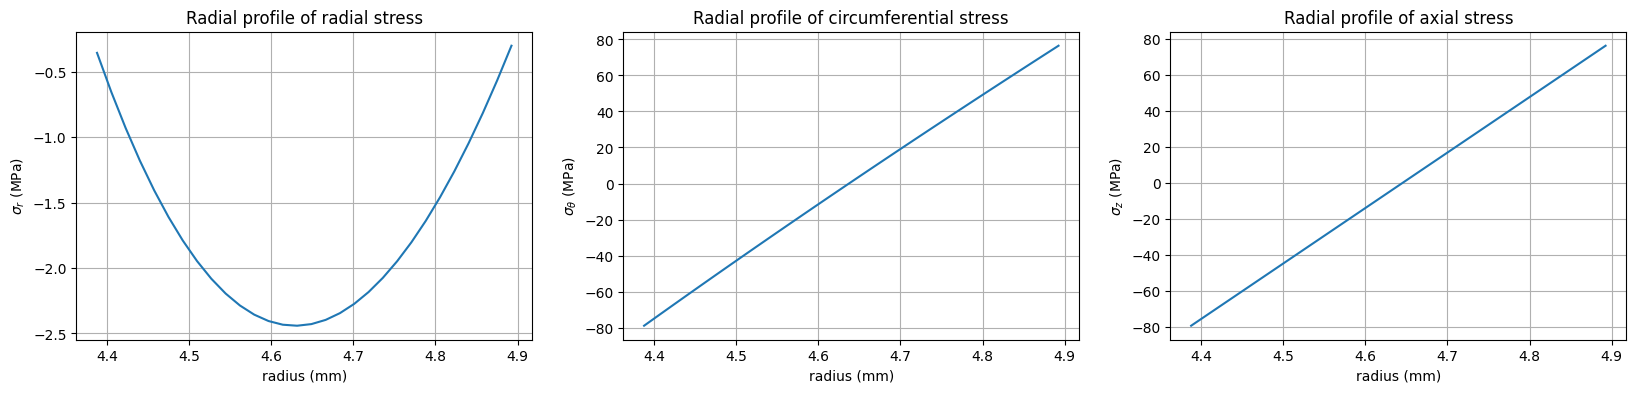

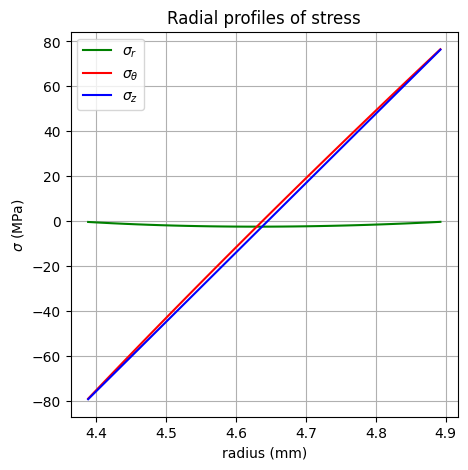

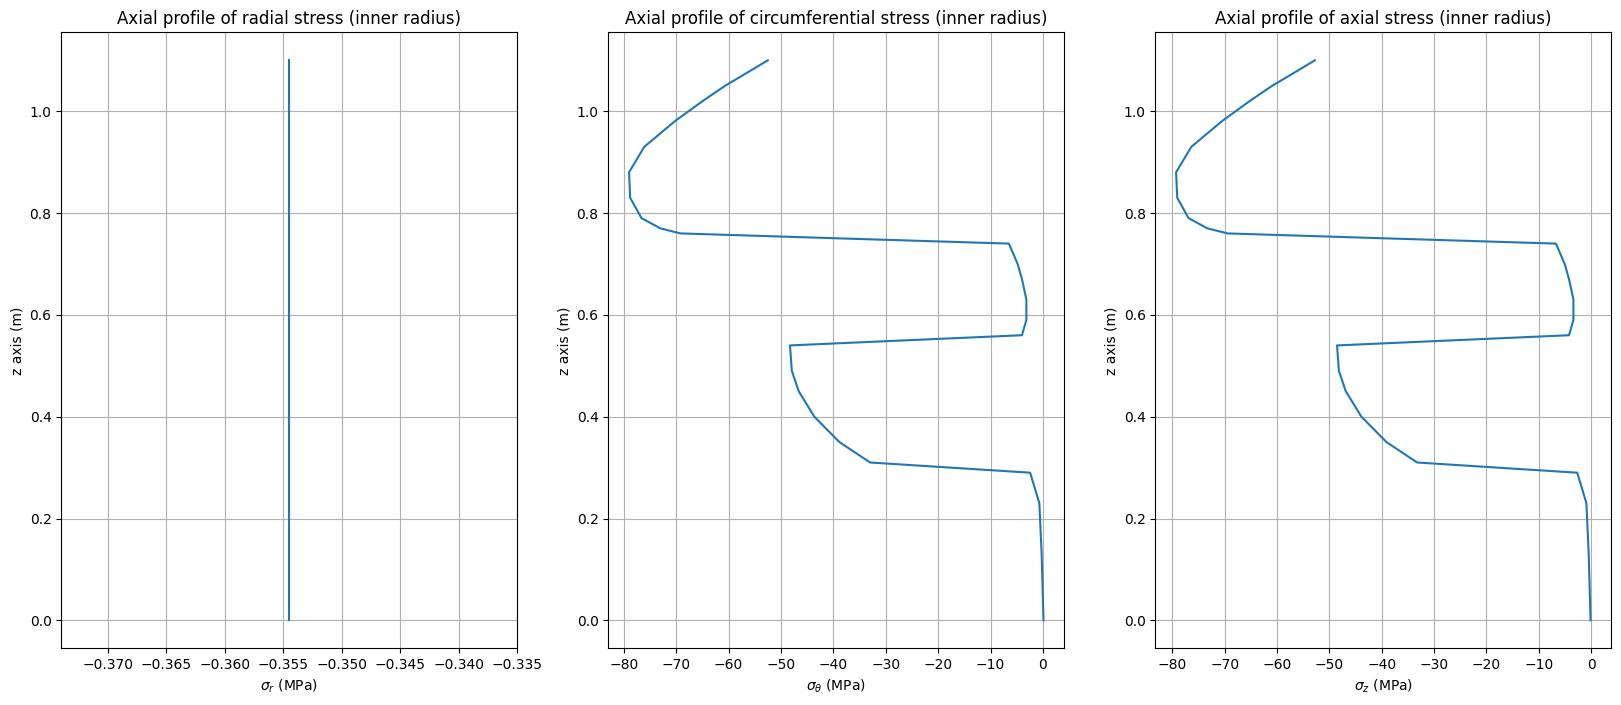

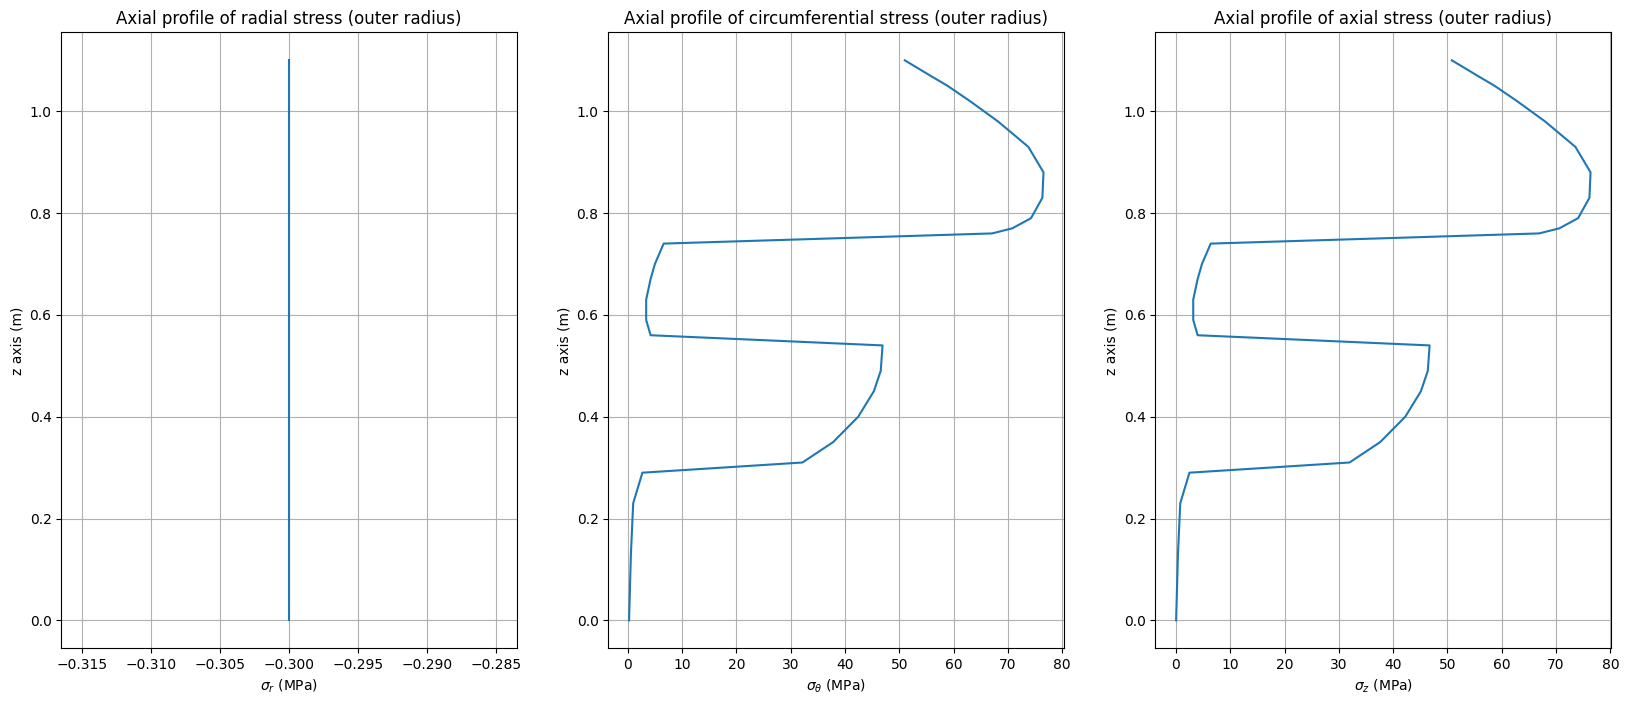

In [ ]:
# Plots

# radial plots

plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot(Points[index,:]*1e3, sigma_r_BOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{r}$ (MPa)')
plt.title('Radial profile of radial stress')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Points[index,:]*1e3, sigma_theta_BOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Radial profile of circumferential stress')
plt.grid()

plt.subplot(1,3,3)
plt.plot(Points[index,:]*1e3, sigma_z_BOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{z}$ (MPa)')
plt.title('Radial profile of axial stress')
plt.grid()

plt.figure(figsize=(5,5))

plt.plot(Points[index,:]*1e3, sigma_r_BOL[index,:]*1e-6, color='g', label='$\sigma_{r}$')
plt.plot(Points[index,:]*1e3, sigma_theta_BOL[index,:]*1e-6, color='r', label='$\sigma_{\\theta}$')
plt.plot(Points[index,:]*1e3, sigma_z_BOL[index,:]*1e-6, color='b', label='$\sigma_{z}$')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma$ (MPa)')
plt.title('Radial profiles of stress')
plt.legend()
plt.grid()


# axial plots


# inner radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (inner radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (inner radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_BOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (inner radius)')
plt.grid()

# outer radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (outer radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (outer radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_BOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (outer radius)')
plt.grid()

##Tresca criterion

In [ ]:
# SAFETY VERIFICATION USING TRESCA CRITERION

# Tresca criterion compares the Sy and max{|sigma_r-sigma_theta|,|sigma_r-sigma_z|,|sigma_z-sigma_theta|}

# Maximum Tresca stress matrix

sigma_tresca_BOL = np.zeros((z.size,N_radial))
Delta_1 = np.zeros((z.size,N_radial))
Delta_2 = np.zeros((z.size,N_radial))
Delta_3 = np.zeros((z.size,N_radial))

for k in range(z.size):

  for j in range(N_radial):

    Delta_1[k][j] = np.abs(sigma_r_BOL[k][j]-sigma_theta_BOL[k][j])
    Delta_2[k][j] = np.abs(sigma_z_BOL[k][j]-sigma_theta_BOL[k][j])
    Delta_3[k][j] = np.abs(sigma_r_BOL[k][j]-sigma_z_BOL[k][j])

    sigma_tresca_BOL[k][j] = max(Delta_1[k][j], Delta_2[k][j], Delta_3[k][j])


# Sa matrix

def sigma_yield(T):
  if T<=600:
    sigma_y = 555.5-0.25*T
  elif T>600:
    sigma_y = 405.5-0.775*(T-600)
  return sigma_y*1e6 #Pa

Sa = np.zeros((z.size, N_radial))

for k in range(z.size):
  for j in range(N_radial):

    Sa[k][j] = 2/3*sigma_yield(T_clad_rad(k,Points[k][j]))

# Comparison between Tresca parameter and safety limit

comparison_matrix = sigma_tresca_BOL<Sa
flag = 0

for k in range(z.size):
  for j in range(N_radial):

    if comparison_matrix[k][j]==False:
      flag = flag+1
      print(f'we exced the limit in axial node {k}')

if flag==0:
  print('\n\nThe stress is under the safety limit in all the points of the cladding\n\n')




The stress is under the safety limit in all the points of the cladding




#Fission Gas Production

## All fuel


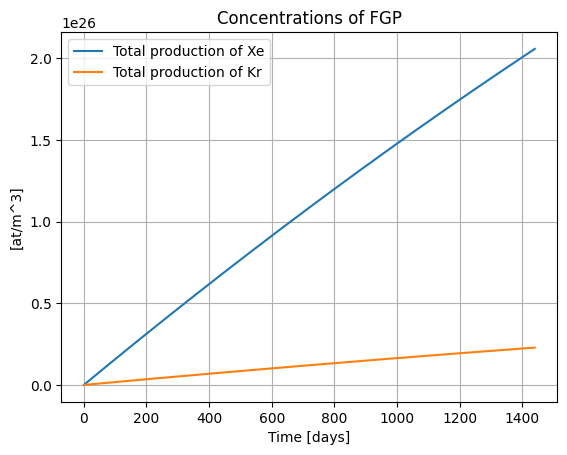

The total atoms of fission gas produced is: 2.235244205232001e+22


In [ ]:
# ALL FUEL

# Q_tot_pin = np.sum(q_pin) #W
V_fertile1 = np.pi*np.max(R_fo_th2[0:5])**2*0.3
V_fissile1 = ((np.pi*np.max(R_fo_th2[5:12])**2)-(np.pi*np.max(R_fi_th2[5:12])**2))*0.25
V_fertile2 = np.pi*np.max(R_fo_th2[12:19])**2*0.2
V_fissile2 = (np.pi*np.max(R_fo_th2[19:30])**2)-(np.pi*np.max(R_fi_th2[19:30])**2)*0.35
V_tot = V_fertile1+V_fertile2+V_fissile1+V_fissile2

# Fission_rate = (Q_tot_pin)/(1.6e-19*200e6*V_tot) #fission/m^3s

def q_fertile1(t):
  return np.sum(q_pin[0:5])-0.025*np.sum(q_pin[0:5])*t/(24*360*3600)
def q_fissile1(t):
  return np.sum(q_pin[5:12])-0.025*np.sum(q_pin[5:12])*t/(24*360*3600)
def q_fertile2(t):
  return np.sum(q_pin[12:19])-0.025*np.sum(q_pin[12:19])*t/(24*360*3600)
def q_fissile2(t):
  return np.sum(q_pin[19:30])-0.025*np.sum(q_pin[19:30])*t/(24*360*3600)
def Q_tot_pin(t):
  return q_fertile1(t)+q_fertile2(t)+q_fissile1(t)+q_fissile2(t)
def Fission_rate(t):
  return (Q_tot_pin(t))/(1.6e-19*200e6*V_tot) #fission/m^3s

y_Xe = 0.27
y_Kr = 0.03
a = 1e-5 # m

# Time points
t = np.linspace(0, 4*24*3600*360,1440)
P0 = 0

# def Prod(t,P,Fission_rate,y):
#   dPdt = y*Fission_rate(t)
#   return dPdt

# #TOTAL PRODUCTION
# prod_Xe = odeint(Prod,P0,t,args=(Fission_rate,y_Xe))
# prod_Kr = odeint(Prod,P0,t,args=(Fission_rate,y_Kr))
# PROD_Xe = prod_Xe[:,0]
# PROD_Kr = prod_Kr[:,0]
# PROD_TOT = (PROD_Xe[-1]+PROD_Kr[-1])*V_tot

PROD_Xe = y_Xe*Fission_rate(t)*t
PROD_Kr = y_Kr*Fission_rate(t)*t
PROD_TOT = (PROD_Xe+PROD_Kr)*V_tot

# Plot the solution
plt.plot(t/86400, PROD_Xe, label = 'Total production of Xe')
plt.plot(t/86400, PROD_Kr, label = 'Total production of Kr')
plt.xlabel('Time [days]')
plt.ylabel('[at/m^3]')
plt.title('Concentrations of FGP')
plt.grid()
plt.legend()
plt.show()

#This is the total fission gas concentration due to the upper pellet after the 1440 days

#DESIGN OF THE PLENUM CONSIDERING 100% RELEASE

print('The total atoms of fission gas produced is:',PROD_TOT[-1])

In [ ]:
#To find the concentration for the single grain and evaluate diffusion AND "ACTUAL RELEASE"
#DIFFUSION

def Deff(T):
  return (5e-8)*np.exp(-40262/T) # m^2/s

def model(G, t, kk, Fission_rate,y):
    dGdt = -kk * G + y*Fission_rate(t)
    return dGdt

<ipython-input-30-1cbae85b0024>:5: RuntimeWarning: divide by zero encountered in divide
  return (5e-8)*np.exp(-40262/T) # m^2/s


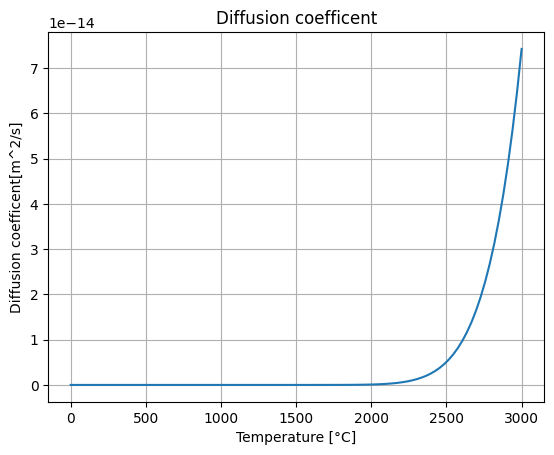

In [ ]:
#PLOT OF THE DIFFUSION COEFFICENT
T = np.linspace(0,3000,100)

plt.plot(T, Deff(T))
plt.ylabel('Diffusion coefficent[m^2/s]')
plt.xlabel('Temperature [°C]')
plt.title('Diffusion coefficent')
plt.grid()
plt.show()

## Fission Gas Release for each pellet

In [ ]:
#EACH PELLET
Q_fertile1 = np.sum(q_pin[0:5]) #W
Q_fissile1 = np.sum(q_pin[5:12]) # W
Q_fertile2 = np.sum(q_pin[12:19]) # W
Q_fissile2 = np.sum(q_pin[19:30]) # W

T_fertile1 = np.mean(T_max_th2[0:5])
T_fissile1 = np.mean(T_max_th2[5:12])
T_fertile2 = np.mean(T_max_th2[12:19])
T_fissile2 = np.mean(T_max_th2[19:30])

In [ ]:
def FGR(V,Q,T):
  Fission_rate = (Q)/(1.6e-19*200e6*V) #fission/m^3s
  # Time points
  t = np.linspace(0, 124*10**6,1000)
  P0 = 0

  def Prod(t,P,Fission_rate,y):
    dPdt = y*Fission_rate
    return dPdt

  #TOTAL PRODUCTION
  prod_Xe = odeint(Prod,P0,t,args=(Fission_rate,y_Xe))
  prod_Kr = odeint(Prod,P0,t,args=(Fission_rate,y_Kr))
  PROD_Xe = prod_Xe[:,0]
  PROD_Kr = prod_Kr[:,0]

  #DIFFUSION

  def model(G, t, kk, Fission_rate,y):
      dGdt = -kk * G + y*Fission_rate
      return dGdt

  # Initial condition
  G0 = 0

  #Coefficent
  kk = Deff(T)*((np.pi)**2)/(a)**2

  g_Xe = odeint(model,G0,t,args=(kk,Fission_rate,y_Xe))
  g_Kr = odeint(model,G0,t,args=(kk,Fission_rate,y_Kr))
  G_Xe = g_Xe[:,0]
  G_Kr = g_Kr[:,0]

  #TOTAL RELEASE

  REL_Xe = PROD_Xe - G_Xe
  REL_Kr = PROD_Kr - G_Kr

  # Plot the solution
  plt.figure()
  plt.plot(t/86400, G_Xe, label = 'Grain concentration of Xe')
  plt.plot(t/86400, PROD_Xe, label = 'Total production of Xe')
  plt.plot(t/86400, REL_Xe, label = 'Release of Xe')
  plt.xlabel('Time (days)')
  plt.ylabel('(at/m^3)')
  plt.title('Concentrations of FGP')
  plt.grid()
  plt.legend()
  plt.show()

  plt.figure()
  plt.plot(t/86400, G_Kr, label = 'Grain concentration of Kr')
  plt.plot(t/86400, PROD_Kr, label = 'Total production of Kr')
  plt.plot(t/86400, REL_Kr, label = 'Release of Kr')
  plt.xlabel('Time (days)')
  plt.ylabel('(at/m^3)')
  plt.title('Concentrations of FGP')
  plt.grid()
  plt.legend()
  plt.show()

  return PROD_Xe,PROD_Kr,REL_Xe,REL_Kr

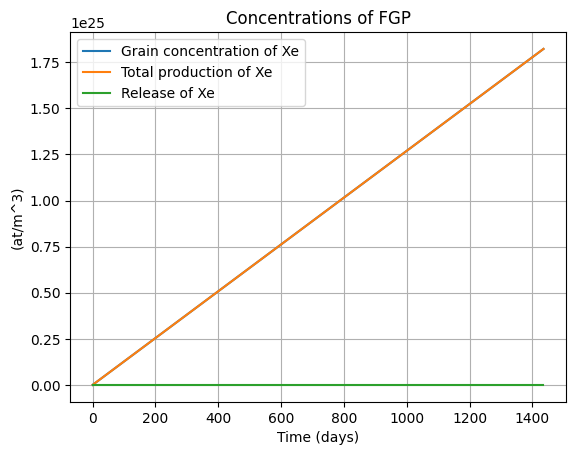

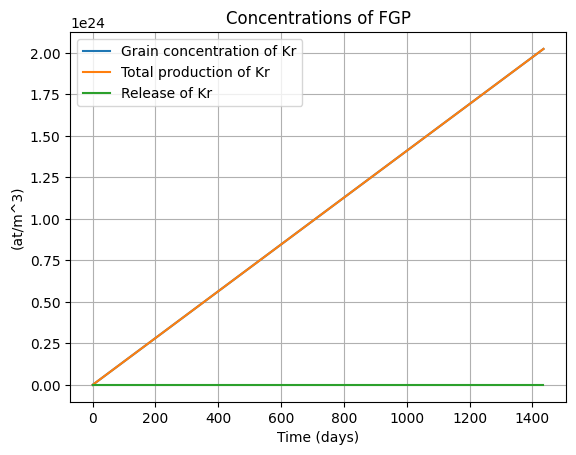

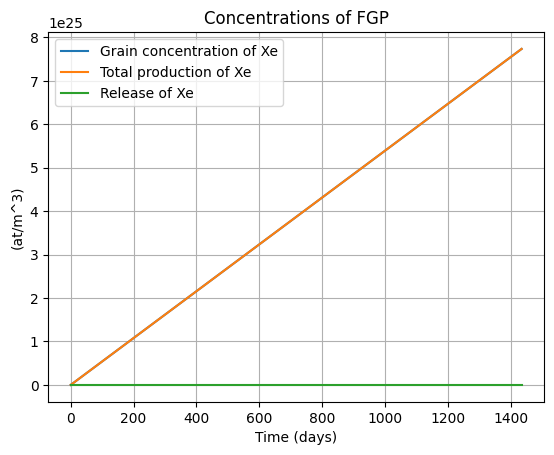

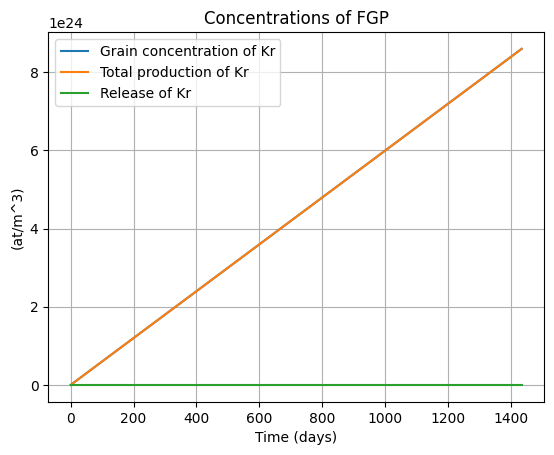

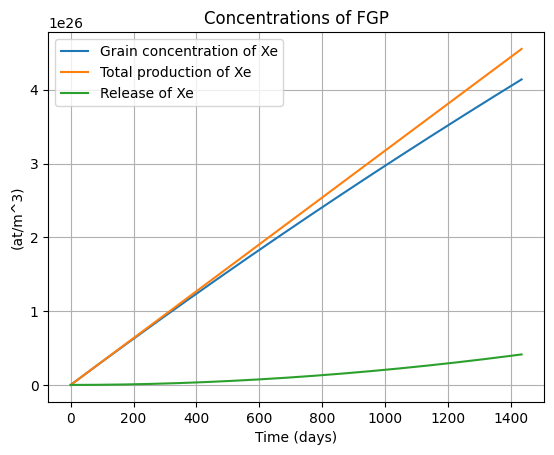

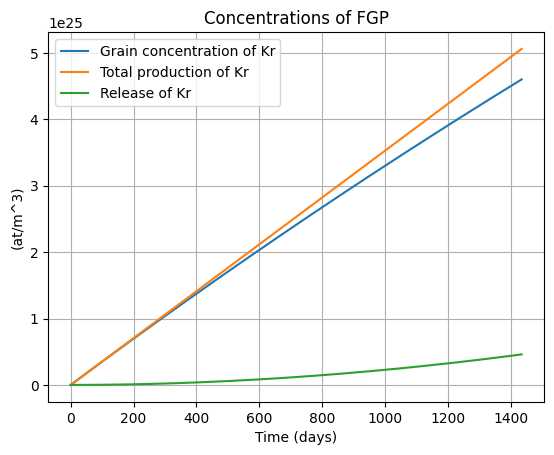

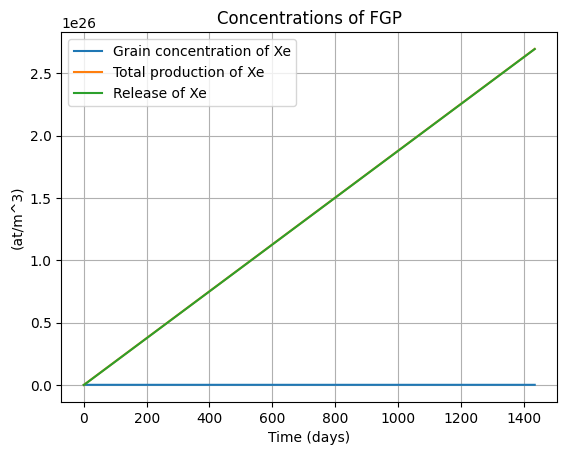

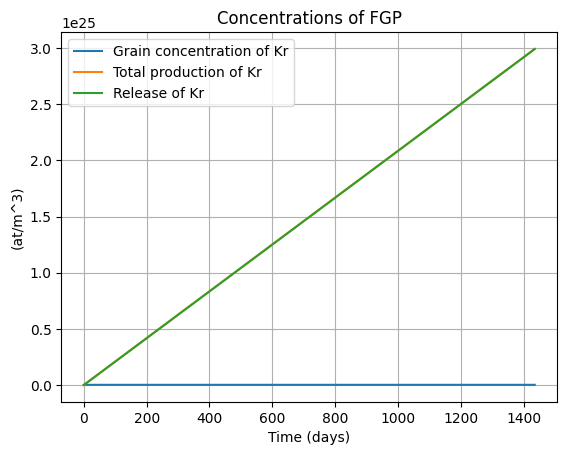

In [ ]:
FGR_fertile1 = FGR(V_fertile1,Q_fertile1,T_fertile1)
FGR_fertile2 = FGR(V_fertile2,Q_fertile2,T_fertile2)
FGR_fissile1 = FGR(V_fissile1,Q_fissile1,T_fissile1)
FGR_fissile2 = FGR(V_fissile2,Q_fissile2,T_fissile2)

# The fission gases are released only by the fissile pellets
# While the fertile pellets would

## Plenum design

In [ ]:
# 100% release
N_av = 6.023e23
V_gap = ((np.pi*R_ci**2)-(np.pi*R_fo**2))*H_a
T_He = 20+273 # (K)
p_He = 0.1e6 # (Pa)
R = 8.314 # (J/mol*K)
h_guess = 0.5 # m

V_guess = h_guess*np.pi*np.min(R_ci_th2)**2
V_plenum = h_guess*np.pi*R_ci**2
n_He = p_He*(V_gap+V_plenum)/(R*T_He)
n_FG = PROD_TOT[-1]/N_av

# We choose as the temperature of the plenum the coolant temperature at the inlet
T_plenum = T_in

p_plenum = (n_FG+n_He)*R*T_plenum/(V_guess+V_gap)/(1e6)

print('The pressure inside the plenum is:',p_plenum)


The pressure inside the plenum is: 3.801875008734204


In [ ]:
V_gap = ((np.pi*R_ci**2)-(np.pi*R_fo**2))*H_a
V_plenum = h_guess*np.pi*R_ci**2
T_He = 20+273 # (K)
p_He = 0.1e6 # (Pa)
M_mol_He = 4 # (g/mol)
M_mol_Xe = 131 # (g/mol)
M_mol_Kr = 83.8 # (g/mol)

n_He = p_He*(V_gap+V_plenum)/(R*T_He)
at_He = n_He*N_av
mass_He = n_He*M_mol_He
at_Xe = PROD_Xe*V_tot
n_Xe = at_Xe/N_av
at_Kr = PROD_Kr*V_tot
n_Kr = at_Kr/N_av
mass_Xe = n_Xe*M_mol_Xe
mass_Kr = n_Kr*M_mol_Kr
print('The atoms of He in the gap are:',at_He,'atoms')
print('The atoms of fission gas release:',n_FG*N_av,'atoms')
print('The mass of He in the gap is:', mass_He,'g')
print('The mass of Xe in the gap is:', mass_Xe[-1],'g')
print('The mass of Kr in the gap is:', mass_Kr[-1],'g')

The atoms of He in the gap are: 8.228814550955026e+20 atoms
The atoms of fission gas release: 2.235244205232001e+22 atoms
The mass of He in the gap is: 0.005464927478635249 g
The mass of Xe in the gap is: 4.375482181584807 g
The mass of Kr in the gap is: 0.31099695234674024 g


In [ ]:
#To demonstrate that the energy released per seconds by fission gas is much lower than the energy removed by the sodium coolant
R_star_He = 8314/M_mol_He
R_star_Xe = 8314/M_mol_Xe
R_star_Kr = 8314/M_mol_Kr
cv_He = 5/2*R_star_He
cv_Xe = 5/2*R_star_Xe
cv_Kr = 5/2*R_star_Kr
cp_Xe = 7/2*R_star_Xe
T_He = 400+273 #(K)
T_fuel = 2000+273 #(K)
T_eq = ((mass_Kr+mass_Xe+mass_He)*cp_Xe*(T_fuel-T_He) + (mass_He)*cv_He*T_He)/((mass_He*cv_He+mass_Kr*cv_Kr+cv_Xe*mass_Xe))
T_eq-273.15;

time_four_years = 4*360*24*60*60
gas_energy_released = (mass_Kr+mass_Xe)*cp_Xe*(T_fuel - T_He)
power_energy_released = gas_energy_released/time_four_years
T_plenum_fin = power_energy_released/(m*cp(T_in)) + T_in
print('The plenum temperature after the exchange of heat between fission gas released and the coolant is:',T_plenum_fin)

The plenum temperature after the exchange of heat between fission gas released and the coolant is: [400.         400.00000009 400.00000018 ... 400.00011547 400.00011554
 400.00011561]


## Axial thermal expansion

In [ ]:
# Let's evaluate the axial thermal expansion for designing the upper plenum needed
# FUEL

# Linear Thermal Expansion Coefficient (°C^-1)
alpha_L = 1.2e-5
T_ref = 25 # °C

# Length of each pellet

L_fertile1 = 0.3 # m
L_fissile1 = 0.25 # m
L_fertile2 = 0.2 # m
L_fissile2 = 0.35 # m

# Avarage temperatures for each pellet

L_fertile1_th = L_fertile1 + L_fertile1*alpha_L*(T_fertile1-T_ref)
L_fertile2_th = L_fertile2 + L_fertile2*alpha_L*(T_fertile2-T_ref)
L_fissile1_th = L_fissile1 + L_fissile1*alpha_L*(T_fissile1-T_ref)
L_fissile2_th = L_fissile2 + L_fissile2*alpha_L*(T_fissile2-T_ref)

# Total axial expansion
H_a_th = L_fertile1_th+L_fertile2_th+L_fissile1_th+L_fissile2_th
print('The axial expansion is:',H_a_th-H_a,'m')

The axial expansion is: 0.016041130925715574 m


# Burnup Analysis

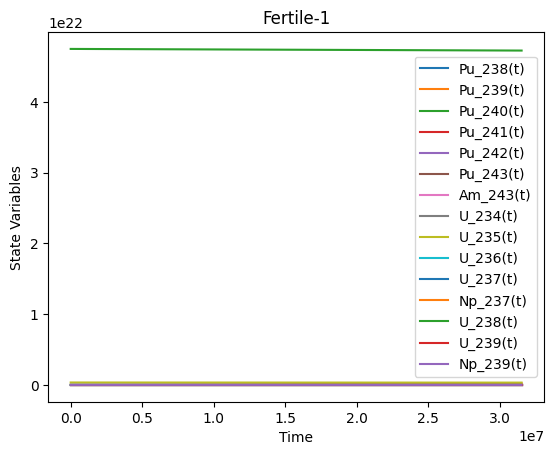

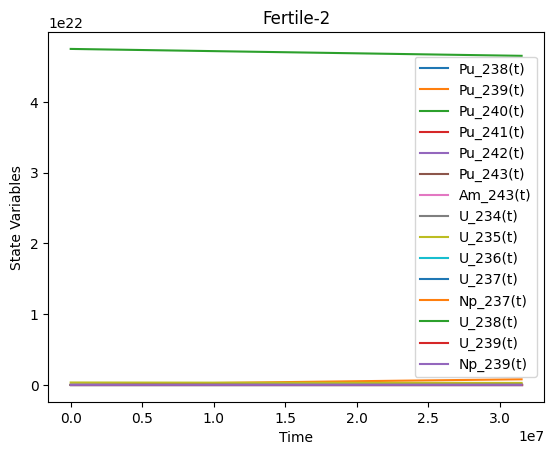

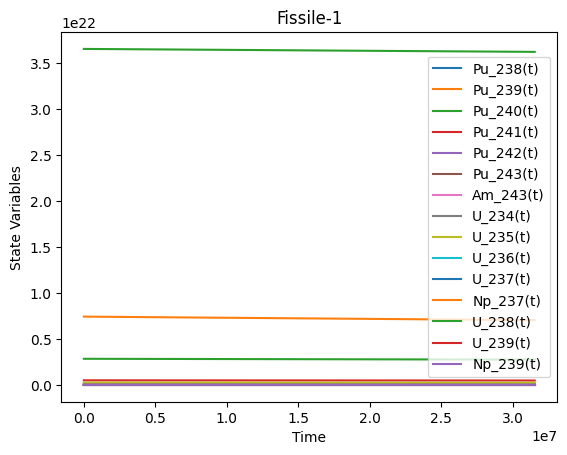

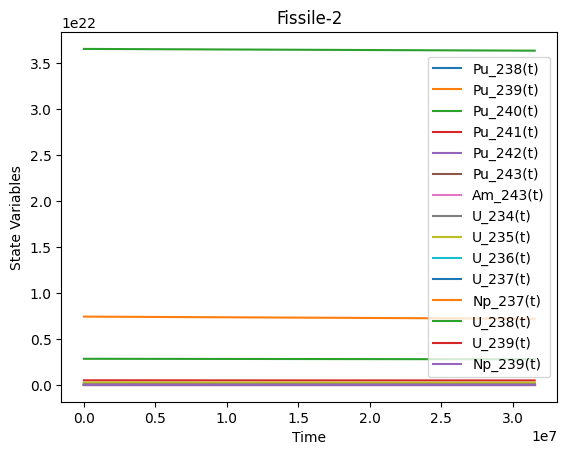

Concentration after 1 year for FERTILE 1 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.67560192e+18
 3.44410518e+20 1.68822648e+18 0.00000000e+00 0.00000000e+00
 4.74853320e+22 0.00000000e+00 0.00000000e+00]
Concentration 0 year for FERTILE 1 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.67560192e+18
 3.44410518e+20 1.68822648e+18 0.00000000e+00 0.00000000e+00
 4.74853320e+22 0.00000000e+00 0.00000000e+00]
Concentration 0 year for FERTILE 2 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.67560192e+18
 3.44410518e+20 1.68822648e+18 0.00000000e+00 0.00000000e+00
 4.74853320e+22 0.00000000e+00 0.00000000e+00]
Concentration after 1 year for FERTILE 2 [0.00000000e+00 7.92541666e+20 7.11729585e+18 6.00738016e+16
 4.08568784e+14 1.54044651e+11 1.55400906e+12 2.43367482e+18
 2.80450193e+20 1.14972956e+19 8.443

In [ ]:
#Fission & (n,gamma) cross sections.
#Most of the Neutrons are in the 0.1 to 1 Mev range (This was done based on a spectrum found for sodium fast reactors).
#(Taken from this link:)
# https://www-nds.iaea.org/exfor/endf.htm

#Cross sections:
fission_pu_238 = 10**-24*(0.66+1.99)/2
capture_pu_238 = 10**-24*(9.44+0.22)/2
fission_pu_239 = 10**-24*(1.55+1.72)/2
capture_pu_239 = 10**-24*(0.247+0.0459)/2
fission_pu_240 = 10**-24*(0.0537+1.51)/2
capture_pu_240 = 10**-24*(0.340+0.08614)/2
fission_pu_241 = 10**-24*(2.136+1.557)/2
capture_pu_241 = 10**-24*(0.3211+0.111)/2
fission_pu_242 = 10**-24*(0.0176+0.1489)/2
capture_pu_242 = 10**-24*(0.217+0.116)/2
fission_u_234 = 10**-24*(0.020+1.09)/2
capture_u_234 = 10**-24*(0.2966+0.122)/2
fission_u_235 = 10**-24*(1.587+1.204)/2
capture_u_235 = 10**-24*(0.419+0.107)/2
fission_u_236 = 10**-24*(0.0036+0.358)/2
capture_u_236 = 10**-24*(0.279+0.1746)/2
fission_u_238 = 10**-24*(0.01459)
capture_u_238 = 10**-24*(0.178+0.12781)/2


#Decay constants
lam_np_239 = 3.4*10**-6
lam_pu_243 = 1.61*10**-6
lam_u_237 = 1.19*10**-6
lam_u_239 = 4.92*10**-4

#Height of the pellet parts
lower_fertile_height = 300/1000 #[m]
upper_fertile_height = 200/1000 #[m]
lower_fissile_height = 250/1000 #[m]
upper_fissile_height = 350/1000 #[m]

#Density of the Uo2 and MOX
density_Uo2 = 11 #g/cm3
density_mox = 10 #g/cm3

#Mass of the parts: (These calculations are kinda useless)
m_fertile_1 = np.pi*(lower_fertile_height)*(R_fo)**2*density_Uo2 #Total mass of the fertile 1 pellet part
m_fertile_2 = np.pi*(upper_fertile_height)*(R_fo)**2*density_Uo2 #Total mass of the fertile 2 pellet part
m_fissile_1 = density_mox*0.95*np.pi*(R_fo**2-0.001225**2)*upper_fissile_height #Total mass of the fissile 1 pellet part
m_fissile_2 = density_mox*0.95*np.pi*(R_fo**2-0.001225**2)*lower_fissile_height #Total mass of the fissile 1 pellet part


#Fissile pellet atomic percentages
atomic_Pu = 23/100 #[Pu/Pu+U]
atomic_U = 77/100 #[U/Pu+U]

#Fertile pellet atomic percentages
nat_234=0.0055/100
nat_235=0.711/100
nat_238=99.28/100
nat_236=1-(nat_238+nat_235+nat_234)

#Weight percentage of the Isotopic compositions
gamma_pu_238_fissile = 0.24/100*atomic_Pu #Total Percentage of Pu-238 in the fissile pellet
gamma_pu_239_fissile = 67.87/100*atomic_Pu #Total Percentage of Pu-239 in the fissile pellet
gamma_pu_240_fissile = 26.07/100*atomic_Pu #Total Percentage of Pu-240 in the fissile pellet
gamma_pu_241_fissile = 4.62/100*atomic_Pu #Total Percentage of Pu-241 in the fissile pellet
gamma_pu_242_fissile = 1.2/100*atomic_Pu #Total Percentage of Pu-242 in the fissile pellet

gamma_u_234_fissile = 0.0055/100*atomic_U #Total Percentage of U-234 in the fissile pellet
gamma_u_235_fissile = 0.71/100*atomic_U #Total Percentage of U-235 in the fissile pellet
gamma_u_236_fissile =  0.0006/100*atomic_U #Total Percentage of U-236 in the fissile pellet
gamma_u_238_fissile = 99.28/100*atomic_U #Total Percentage of U-238 in the fissile pellet

gamma_u_234_fertile = nat_234 #Total Percentage of U-234 in the fertile pellet
gamma_u_235_fertile = nat_235 #Total Percentage of U-235 in the fertile pellet
gamma_u_236_fertile = nat_236 #Total Percentage of U-236 in the fertile pellet
gamma_u_238_fertile = nat_238 #Total Percentage of U-238 in the fertile pellet

#Total power for each part of the pellet
Q_fertile1 = np.sum(q_pin[0:5]) #W
Q_fissile1 = np.sum(q_pin[5:12]) # W
Q_fertile2 = np.sum(q_pin[12:19]) # W
Q_fissile2 = np.sum(q_pin[19:30]) # W

#Volume of each part of the pellet
V_fertile1 = np.pi*np.max(R_fo_th2[0:5])**2*0.3 #m3
V_fissile1 = ((np.pi*np.max(R_fo_th2[5:12])**2)-(np.pi*np.max(R_fi_th2[5:12])**2))*0.25 #m3
V_fertile2 = np.pi*np.max(R_fo_th2[12:19])**2*0.2 #m3
V_fissile2 = (np.pi*np.max(R_fo_th2[19:30])**2)-(np.pi*np.max(R_fi_th2[19:30])**2)*0.35 #m3

#Density used for the Atomic_concentration = Nav*rho*gamma/MM [atoms/cm3]
r_fertile_1 = 18.9 #[g/cm3]
r_fertile_2 = 18.9
r_fissile_1 = 18.9
r_fissile_2 = 18.9

#Macroscopic fission cross sections for each part of the pellet

Sigma_f_fertile_1 = (fission_u_234*N_av*gamma_u_234_fertile*r_fertile_1/234+
                    fission_u_235*N_av*gamma_u_235_fertile*r_fertile_1/235+
                    fission_u_236*N_av*gamma_u_236_fertile*r_fertile_1/236+
                    fission_u_238*N_av*gamma_u_238_fertile*r_fertile_1/238)/2

Sigma_f_fertile_2 = (fission_u_234*N_av*gamma_u_234_fertile*r_fertile_2/234+
                    fission_u_235*N_av*gamma_u_235_fertile*r_fertile_2/235+
                    fission_u_236*N_av*gamma_u_236_fertile*r_fertile_2/236+
                    fission_u_238*N_av*gamma_u_238_fertile*r_fertile_2/238)/2

Sigma_f_fissile_1 = (fission_u_234*N_av*gamma_u_234_fissile*r_fissile_1/234+
                    fission_u_235*N_av*gamma_u_235_fissile*r_fissile_1/235+
                    fission_u_236*N_av*gamma_u_236_fissile*r_fissile_1/236+
                    fission_u_238*N_av*gamma_u_238_fissile*r_fissile_1/238+
                    fission_pu_238*N_av*gamma_pu_238_fissile*r_fissile_1/238+
                    fission_pu_239*N_av*gamma_pu_239_fissile*r_fissile_1/239+
                    fission_pu_240*N_av*gamma_pu_240_fissile*r_fissile_1/240+
                    fission_pu_241*N_av*gamma_pu_241_fissile*r_fissile_1/241+
                    fission_pu_242*N_av*gamma_pu_242_fissile*r_fissile_1/242)/2

Sigma_f_fissile_2 = (fission_u_234*N_av*gamma_u_234_fissile*r_fissile_2/234+
                    fission_u_235*N_av*gamma_u_235_fissile*r_fissile_2/235+
                    fission_u_236*N_av*gamma_u_236_fissile*r_fissile_2/236+
                    fission_u_238*N_av*gamma_u_238_fissile*r_fissile_2/238+
                    fission_pu_238*N_av*gamma_pu_238_fissile*r_fissile_2/238+
                    fission_pu_239*N_av*gamma_pu_239_fissile*r_fissile_2/239+
                    fission_pu_240*N_av*gamma_pu_240_fissile*r_fissile_2/240+
                    fission_pu_241*N_av*gamma_pu_241_fissile*r_fissile_2/241+
                    fission_pu_242*N_av*gamma_pu_242_fissile*r_fissile_2/242)/2

f = 1e6 #Conversion factor from m3--->cm3
#Fluxes for each part of the pellet
flux_fertile_1 = Q_fertile1/(200e6*1.6e-19*V_fertile1*Sigma_f_fertile_1*f)
flux_fertile_2 = Q_fertile2/(200e6*1.6e-19*V_fertile2*Sigma_f_fertile_2*f)
flux_fissile_1 = Q_fissile1/(200e6*1.6e-19*V_fissile1*Sigma_f_fissile_1*f)
flux_fissile_2 = Q_fissile2/(200e6*1.6e-19*V_fissile2*Sigma_f_fissile_2*f)



#Bateman equations FERTILE 1

def system_of_odes(t, state):

    # State vector
    Pu_238, Pu_239, Pu_240, Pu_241, Pu_242, Pu_243, Am_243, U_234, U_235, U_236, U_237, Np_237, U_238, U_239, Np_239 = state

    # ODEs
    dPu_238_dt = -fission_pu_238 * Pu_238 * flux_fertile_1 - capture_pu_238 * Pu_238 * flux_fertile_1
    dPu_239_dt = -fission_pu_239 * Pu_239 * flux_fertile_1 + capture_pu_238 * Pu_238 * flux_fertile_1 - capture_pu_239 * Pu_239 * flux_fertile_1 + lam_np_239 * Np_239
    dPu_240_dt = -fission_pu_240 * Pu_240 * flux_fertile_1 + capture_pu_239 * Pu_239 * flux_fertile_1 - capture_pu_240 * Pu_240 * flux_fertile_1
    dPu_241_dt = -fission_pu_241 * Pu_241 * flux_fertile_1 + capture_pu_240 * Pu_240 * flux_fertile_1 - capture_pu_241 * Pu_241 * flux_fertile_1
    dPu_242_dt = -fission_pu_242 * Pu_242 * flux_fertile_1 + capture_pu_241 * Pu_241 * flux_fertile_1 - capture_pu_242 * Pu_242 * flux_fertile_1
    dPu_243_dt = capture_pu_242 * Pu_242 * flux_fertile_1 - lam_pu_243 * Pu_243
    dAm_243_dt = lam_pu_243 * Pu_243
    dU_234_dt = -fission_u_234 * U_234 * flux_fertile_1 - capture_u_234 * U_234 * flux_fertile_1
    dU_235_dt = -fission_u_235 * U_235 * flux_fertile_1 + capture_u_234 * U_234 * flux_fertile_1 - capture_u_235 * U_235 * flux_fertile_1
    dU_236_dt = -fission_u_236 * U_236 * flux_fertile_1 + capture_u_235 * U_235 * flux_fertile_1 - capture_u_236 * U_236 * flux_fertile_1
    dU_237_dt = capture_u_236 * U_236 * flux_fertile_1 - lam_u_237 * U_237
    dNp_237_dt = lam_u_237 * U_237
    dU_238_dt = -fission_u_238 * U_238 * flux_fertile_1 - capture_u_238 * U_238 * flux_fertile_1
    dU_239_dt = capture_u_238 * U_238 * flux_fertile_1 - lam_u_239 * U_239
    dNp_239_dt = lam_u_239 * U_239 - lam_np_239 * Np_239

    return [dPu_238_dt, dPu_239_dt, dPu_240_dt, dPu_241_dt, dPu_242_dt, dPu_243_dt, dAm_243_dt,
            dU_234_dt, dU_235_dt, dU_236_dt, dU_237_dt, dNp_237_dt, dU_238_dt, dU_239_dt, dNp_239_dt]

# Set initial conditions
initial_conditions = [0, 0, 0, 0, 0, 0, 0,
                      N_av * gamma_u_234_fertile * r_fertile_1 / 234,
                      N_av * gamma_u_235_fertile * r_fertile_1 / 235,
                      N_av * gamma_u_236_fertile * r_fertile_1 / 236, 0, 0,
                      N_av * gamma_u_238_fertile * r_fertile_1 / 238, 0, 0]

# Set time span for the simulation
final_time = 3600*24*365
t_span = (0, final_time)

# Solve the system using solve_ivp
solution_1 = solve_ivp(system_of_odes, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 100))

# Plot the results
plt.figure(1)
for i in range(15):
    plt.plot(solution_1.t, solution_1.y[i], label=f'{["Pu_238", "Pu_239", "Pu_240", "Pu_241", "Pu_242", "Pu_243", "Am_243", "U_234", "U_235", "U_236", "U_237", "Np_237", "U_238", "U_239", "Np_239"][i]}(t)')

plt.title('Fertile-1')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.show()


#Bateman equations FERTILE 2

def system_of_odes_2(t, state):

    # State vector
    Pu_238, Pu_239, Pu_240, Pu_241, Pu_242, Pu_243, Am_243, U_234, U_235, U_236, U_237, Np_237, U_238, U_239, Np_239 = state

    # ODEs
    dPu_238_dt = -fission_pu_238 * Pu_238 * flux_fertile_2 - capture_pu_238 * Pu_238 * flux_fertile_2
    dPu_239_dt = -fission_pu_239 * Pu_239 * flux_fertile_2 + capture_pu_238 * Pu_238 * flux_fertile_2 - capture_pu_239 * Pu_239 * flux_fertile_2 + lam_np_239 * Np_239
    dPu_240_dt = -fission_pu_240 * Pu_240 * flux_fertile_2 + capture_pu_239 * Pu_239 * flux_fertile_2 - capture_pu_240 * Pu_240 * flux_fertile_2
    dPu_241_dt = -fission_pu_241 * Pu_241 * flux_fertile_2 + capture_pu_240 * Pu_240 * flux_fertile_2 - capture_pu_241 * Pu_241 * flux_fertile_2
    dPu_242_dt = -fission_pu_242 * Pu_242 * flux_fertile_2 + capture_pu_241 * Pu_241 * flux_fertile_2 - capture_pu_242 * Pu_242 * flux_fertile_2
    dPu_243_dt = capture_pu_242 * Pu_242 * flux_fertile_2 - lam_pu_243 * Pu_243
    dAm_243_dt = lam_pu_243 * Pu_243
    dU_234_dt = -fission_u_234 * U_234 * flux_fertile_2 - capture_u_234 * U_234 * flux_fertile_2
    dU_235_dt = -fission_u_235 * U_235 * flux_fertile_2 + capture_u_234 * U_234 * flux_fertile_2 - capture_u_235 * U_235 * flux_fertile_2
    dU_236_dt = -fission_u_236 * U_236 * flux_fertile_2 + capture_u_235 * U_235 * flux_fertile_2 - capture_u_236 * U_236 * flux_fertile_2
    dU_237_dt = capture_u_236 * U_236 * flux_fertile_2 - lam_u_237 * U_237
    dNp_237_dt = lam_u_237 * U_237
    dU_238_dt = -fission_u_238 * U_238 * flux_fertile_2 - capture_u_238 * U_238 * flux_fertile_2
    dU_239_dt = capture_u_238 * U_238 * flux_fertile_2 - lam_u_239 * U_239
    dNp_239_dt = lam_u_239 * U_239 - lam_np_239 * Np_239

    return [dPu_238_dt, dPu_239_dt, dPu_240_dt, dPu_241_dt, dPu_242_dt, dPu_243_dt, dAm_243_dt,
            dU_234_dt, dU_235_dt, dU_236_dt, dU_237_dt, dNp_237_dt, dU_238_dt, dU_239_dt, dNp_239_dt]

# Set initial conditions
initial_conditions_2 = [0, 0, 0, 0, 0, 0, 0,
                        N_av * gamma_u_234_fertile * r_fertile_2 / 234,
                        N_av * gamma_u_235_fertile * r_fertile_2 / 235,
                        N_av * gamma_u_236_fertile * r_fertile_2 / 236, 0, 0,
                        N_av * gamma_u_238_fertile * r_fertile_2 / 238, 0, 0]



# Solve the system using solve_ivp
solution_2 = solve_ivp(system_of_odes_2, t_span, initial_conditions_2, t_eval=np.linspace(t_span[0], t_span[1], 100))

# Plot the results
plt.figure(2)
for i in range(15):
    plt.plot(solution_2.t, solution_2.y[i], label=f'{["Pu_238", "Pu_239", "Pu_240", "Pu_241", "Pu_242", "Pu_243", "Am_243", "U_234", "U_235", "U_236", "U_237", "Np_237", "U_238", "U_239", "Np_239"][i]}(t)')

plt.title('Fertile-2')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.show()

#Bateman equations FISSILE 1

def system_of_odes(t, state):

    # State vector
    Pu_238, Pu_239, Pu_240, Pu_241, Pu_242, Pu_243, Am_243, U_234, U_235, U_236, U_237, Np_237, U_238, U_239, Np_239 = state

    # ODEs
    dPu_238_dt = -fission_pu_238 * Pu_238 * flux_fissile_1 - capture_pu_238 * Pu_238 * flux_fissile_1
    dPu_239_dt = -fission_pu_239 * Pu_239 * flux_fissile_1 + capture_pu_238 * Pu_238 * flux_fissile_1 - capture_pu_239 * Pu_239 *flux_fissile_1 + lam_np_239 * Np_239
    dPu_240_dt = -fission_pu_240 * Pu_240 * flux_fissile_1 + capture_pu_239 * Pu_239 * flux_fissile_1 - capture_pu_240 * Pu_240 * flux_fissile_1
    dPu_241_dt = -fission_pu_241 * Pu_241 * flux_fissile_1 + capture_pu_240 * Pu_240 * flux_fissile_1 - capture_pu_241 * Pu_241 * flux_fissile_1
    dPu_242_dt = -fission_pu_242 * Pu_242 * flux_fissile_1 + capture_pu_241 * Pu_241 * flux_fissile_1 - capture_pu_242 * Pu_242 * flux_fissile_1
    dPu_243_dt = capture_pu_242 * Pu_242 * flux_fissile_1 - lam_pu_243 * Pu_243
    dAm_243_dt = lam_pu_243 * Pu_243
    dU_234_dt = -fission_u_234 * U_234 * flux_fissile_1 - capture_u_234 * U_234 * flux_fissile_1
    dU_235_dt = -fission_u_235 * U_235 * flux_fissile_1 + capture_u_234 * U_234 * flux_fissile_1 - capture_u_235 * U_235 * flux_fissile_1
    dU_236_dt = -fission_u_236 * U_236 * flux_fissile_1 + capture_u_235 * U_235 * flux_fissile_1 - capture_u_236 * U_236 * flux_fissile_1
    dU_237_dt = capture_u_236 * U_236 * flux_fissile_1- lam_u_237 * U_237
    dNp_237_dt = lam_u_237 * U_237
    dU_238_dt = -fission_u_238 * U_238 * flux_fissile_1 - capture_u_238 * U_238 *flux_fissile_1
    dU_239_dt = capture_u_238 * U_238 * flux_fissile_1 - lam_u_239 * U_239
    dNp_239_dt = lam_u_239 * U_239 - lam_np_239 * Np_239

    return [dPu_238_dt, dPu_239_dt, dPu_240_dt, dPu_241_dt, dPu_242_dt, dPu_243_dt, dAm_243_dt,
            dU_234_dt, dU_235_dt, dU_236_dt, dU_237_dt, dNp_237_dt, dU_238_dt, dU_239_dt, dNp_239_dt]


# Set initial conditions
initial_conditions = [N_av*gamma_pu_238_fissile*r_fissile_1/238,
                      N_av*gamma_pu_239_fissile*r_fissile_1/239,
                      N_av*gamma_pu_240_fissile*r_fissile_1/240,
                      N_av*gamma_pu_241_fissile*r_fissile_1/241,
                      N_av*gamma_pu_242_fissile*r_fissile_1/242,
                      0,0,
                      N_av*gamma_u_234_fissile*r_fissile_1/234,
                      N_av*gamma_u_235_fissile*r_fissile_1/235,
                      N_av*gamma_u_236_fissile*r_fissile_1/236,0,0,
                      N_av*gamma_u_238_fissile*r_fissile_1/238,0,0]



# Solve the system using solve_ivp
solution_3 = solve_ivp(system_of_odes, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 100))

# Plot the results
plt.figure(3)
for i in range(15):
    plt.plot(solution_3.t, solution_3.y[i], label=f'{["Pu_238", "Pu_239", "Pu_240", "Pu_241", "Pu_242", "Pu_243", "Am_243", "U_234", "U_235", "U_236", "U_237", "Np_237", "U_238", "U_239", "Np_239"][i]}(t)')

plt.title('Fissile-1')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.show()

#Bateman equations FISSILE 2

def system_of_odes(t, state):

    # State vector
    Pu_238, Pu_239, Pu_240, Pu_241, Pu_242, Pu_243, Am_243, U_234, U_235, U_236, U_237, Np_237, U_238, U_239, Np_239 = state

    # ODEs
    dPu_238_dt = -fission_pu_238 * Pu_238 * flux_fissile_2 - capture_pu_238 * Pu_238 * flux_fissile_2
    dPu_239_dt = -fission_pu_239 * Pu_239 * flux_fissile_2 + capture_pu_238 * Pu_238 * flux_fissile_2 - capture_pu_239 * Pu_239 *flux_fissile_2 + lam_np_239 * Np_239
    dPu_240_dt = -fission_pu_240 * Pu_240 * flux_fissile_2 + capture_pu_239 * Pu_239 * flux_fissile_2 - capture_pu_240 * Pu_240 * flux_fissile_2
    dPu_241_dt = -fission_pu_241 * Pu_241 * flux_fissile_2 + capture_pu_240 * Pu_240 * flux_fissile_2 - capture_pu_241 * Pu_241 * flux_fissile_2
    dPu_242_dt = -fission_pu_242 * Pu_242 * flux_fissile_2 + capture_pu_241 * Pu_241 * flux_fissile_2 - capture_pu_242 * Pu_242 * flux_fissile_2
    dPu_243_dt = capture_pu_242 * Pu_242 * flux_fissile_2 - lam_pu_243 * Pu_243
    dAm_243_dt = lam_pu_243 * Pu_243
    dU_234_dt = -fission_u_234 * U_234 * flux_fissile_2 - capture_u_234 * U_234 * flux_fissile_2
    dU_235_dt = -fission_u_235 * U_235 * flux_fissile_2 + capture_u_234 * U_234 * flux_fissile_2 - capture_u_235 * U_235 * flux_fissile_2
    dU_236_dt = -fission_u_236 * U_236 * flux_fissile_2 + capture_u_235 * U_235 * flux_fissile_2 - capture_u_236 * U_236 * flux_fissile_2
    dU_237_dt = capture_u_236 * U_236 * flux_fissile_2- lam_u_237 * U_237
    dNp_237_dt = lam_u_237 * U_237
    dU_238_dt = -fission_u_238 * U_238 * flux_fissile_2 - capture_u_238 * U_238 *flux_fissile_2
    dU_239_dt = capture_u_238 * U_238 * flux_fissile_2 - lam_u_239 * U_239
    dNp_239_dt = lam_u_239 * U_239 - lam_np_239 * Np_239

    return [dPu_238_dt, dPu_239_dt, dPu_240_dt, dPu_241_dt, dPu_242_dt, dPu_243_dt, dAm_243_dt,
            dU_234_dt, dU_235_dt, dU_236_dt, dU_237_dt, dNp_237_dt, dU_238_dt, dU_239_dt, dNp_239_dt]




# Set initial conditions
initial_conditions = [N_av*gamma_pu_238_fissile*r_fissile_2/238,
                      N_av*gamma_pu_239_fissile*r_fissile_2/239,
                      N_av*gamma_pu_240_fissile*r_fissile_2/240,
                      N_av*gamma_pu_241_fissile*r_fissile_2/241,
                      N_av*gamma_pu_242_fissile*r_fissile_2/242,
                      0,0,
                      N_av*gamma_u_234_fissile*r_fissile_2/234,
                      N_av*gamma_u_235_fissile*r_fissile_2/235,
                      N_av*gamma_u_236_fissile*r_fissile_2/236,0,0,
                      N_av*gamma_u_238_fissile*r_fissile_2/238,0,0]

# Solve the system using solve_ivp
solution_4 = solve_ivp(system_of_odes, t_span, initial_conditions, t_eval=np.linspace(t_span[0], t_span[1], 100))

# Plot the results
plt.figure(4)
for i in range(15):
    plt.plot(solution_4.t, solution_4.y[i], label=f'{["Pu_238", "Pu_239", "Pu_240", "Pu_241", "Pu_242", "Pu_243", "Am_243", "U_234", "U_235", "U_236", "U_237", "Np_237", "U_238", "U_239", "Np_239"][i]}(t)')

plt.title('Fissile-2')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.show()





#After 1 year for fertile 1
initial_values_fertile_1 = solution_1.y[:, 0]
print("Concentration after 1 year for FERTILE 1",initial_values_fertile_1)
final_values_fertile_1 = solution_1.y[:, -1]
print("Concentration 0 year for FERTILE 1",initial_values_fertile_1)

#After 1 year for fertile 2
initial_values_fertile_2 = solution_2.y[:, 0]
print("Concentration 0 year for FERTILE 2",initial_values_fertile_2)
final_values_fertile_2 = solution_2.y[:, -1]
print("Concentration after 1 year for FERTILE 2",final_values_fertile_2)

#After 1 year for fissile 1
initial_values_fissile_1 = solution_3.y[:, 0]
print("Concentration 0 year for FISSILE 1",initial_values_fissile_1)
final_values_fissile_1 = solution_3.y[:, -1]
print("Concentration after 1 year for FISSILE 1",final_values_fissile_1)

#After 1 year for fissile 2
initial_values_fissile_2 = solution_4.y[:, 0]
print("Concentration 0 year for FISSILE 2",initial_values_fissile_2)
final_values_fissile_2 = solution_4.y[:, -1]
print("Concentration after 1 year for FISSILE 2",final_values_fissile_2)


# New temperature profile after 4 years

In [ ]:
#GAP-FUEL OUTER
def k_gas(T,fracHe,fracXe,fracKr):
    T_k = T_kelvin(T)
    return ((15.8E-4)**fracHe)*((0.72E-4)**fracXe)*((1.15E-4 )**fracKr)*(T_k)**0.79

def q_time(t):
    return q_lin - 0.1/4*q_lin*t/360

po = po*np.ones(z.size)

def Temp_time(time):

  T_cool_time = T_cool*1
  T_co_time = T_co*1
  T_ci_time = T_ci*1
  T_fo_time = T_fo*1
  T_fi_time = T_max*1
  R_co_time = R_co*np.ones(z.size)
  R_ci_time = R_ci*np.ones(z.size)
  R_fo_time = R_fo*np.ones(z.size)
  R_fi_time = R_fi*1
  R_fi_time_th = R_fi*1
  R_fo_time_th = R_fo*np.ones(z.size)
  t_gap_time_th = t_gap*np.ones(z.size)
  t_clad_time_th = t_clad*np.ones(z.size)
  deltat_time_th = np.zeros(z.size)
  T_co_time_th = T_co*1
  T_ci_time_th = T_ci*1
  T_fo_time_th = T_fo*1
  T_fi_time_th = T_max*1
  contact_time = np.zeros(z.size)
  t_gap_tempo = np.zeros(int(time))
  tempo = range(0,time)
  F_v_time_th = np.ones(z.size)
  k_gas_controllo = np.zeros((time,z.size))
  k_fuel_controllo = np.zeros((time,z.size))
  T_mean_int_fuel_time = np.zeros(z.size)
  T_test = np.zeros(z.size)

  for t in range(0,time,5):
    # CLADDING

    def eps_clad(T):
      return -3.101E-4 + 1.545E-5*T + 2.75E-9*T**2

    R_ci_time_th = R_ci_time + R_ci_time*eps_clad((T_ci_time+T_co_time)/2)
    R_co_time_th = R_co_time + R_co_time*eps_clad((T_ci_time+T_co_time)/2)

    for i in range(z.size):
      if t_gap_time_th[i]>0:
        #AXIAL TEMPERATURE PROFILE CUMULATIVE
        # THERMAL EXPANSION after t days of irradiation
        # FUEL
        # Linear Thermal Expansion Coefficient (°C^-1)
        alpha_L = 1.2e-5
        T_ref = 25 # °C

        errore = 100
        counts = 0
        while errore>10 and counts<15:
          # Mean value of temperature in fuel
          T_mean_int_fuel_time[i] = (T_fo_time_th[i] + T_fi_time_th[i])/2

          if R_fi_time_th[i]!=0:
            R_fi_time_th[i] = R_fi_time[i]+R_fi_time[i]*alpha_L*((T_mean_int_fuel_time[i]-T_ref))

          R_fo_time_th[i] = R_fo_time[i] + R_fo_time[i]*alpha_L*(T_mean_int_fuel_time[i]-T_ref)

          t_gap_time_th[i] = R_ci_time_th[i]-R_fo_time_th[i]
          t_clad_time_th[i] = R_co_time_th[i]-R_ci_time_th[i]
          deltat_time_th[i] = t_clad_time_th[i]-t_clad

          # AXIAL TEMPERATURE PROFILE AFTER FISSION GAS RELEASE AND THERMAL EXPANSION
          # PROFILE TEMPERATURE UP TO CLADDING INNER

          d_time_th = R_co_time_th[i]*2 #outer cladding diameter after thermal expansion
          D_h_time_th = d_time_th*((2*np.sqrt(3)*(p)**2)/((np.pi)*(d_time_th)**2) -1) # Hydraulic diameter (m)

          A_time_th = 2*((np.sqrt(3)/4)*p**2 - (np.pi * d_time_th**2)/8)
          v_time_th = m/(A_time_th*rho(T_cool_time[i])) # Velocity profile of the coolant (m/s)
          Re_time_th = (rho(T_cool_time[i])*v_time_th*D_h_time_th)/mu(T_cool_time[i]) #Reynolds profile of the coolant
          Pr = (cp(T_cool_time[i])*mu(T_cool_time[i])/k_cool(T_cool_time[i])) #Prandlt profile of the coolant
          Nu_time_th = 7 + 0.025*(Re_time_th*Pr)**0.8 #Nusselt profile of the coolant
          h = Nu_time_th*(k_cool(T_cool_time[i])/D_h_time_th) # Heat transfer coefficient profile of the coolant (W/m^2 K) after thermal expansion

          #CLADDING OUTER

          q_lin_time = q_time(t)
          DT_time_th = (q_lin_time[i])/(2*np.pi*R_co_time_th[i]*h) #Temperature difference between the coolant and the outside of the claddig in each section
          T_co_time_th[i] = T_cool_time[i]+DT_time_th

          #CLADDING INNER

          DeltaT_clad_time_th = q_lin_time[i]*t_clad_time_th[i]/(2*np.pi*k_clad(T_co_time_th[i])*(R_ci_time_th[i] +R_co_time_th[i])/2)
          T_ci_time_th[i] = T_co_time_th[i]+DeltaT_clad_time_th

          # GAP WITH FISSION GAS ANALYSIS
          n_tot = n_He + n_Xe[t] + n_Kr[t]
          fracHe = n_He / n_tot
          fracXe = n_Xe[t] / n_tot
          fracKr = n_Kr[t] / n_tot

          # Funzione da risolvere
          def equation_T_fo(T_fo, T_ci, t_gap, R_fo, He, Xe, Kr, q_lin):
              return T_fo - T_ci - q_lin * (t_gap / (2 * np.pi * R_fo * k_gas((T_fo + T_ci) / 2, He, Xe, Kr)))

          # Fornisci una stima iniziale per T_fo_time[i]
          initial_guess_T_fo = T_fo_time_th[i]

          # Utilizza fsolve per risolvere l'equazione
          T_fo_time_th[i] = fsolve(equation_T_fo, initial_guess_T_fo, args=(T_ci_time_th[i], t_gap_time_th[i], R_fo_time_th[i], fracHe, fracXe, fracKr, q_lin_time[i]))

          # Aggiorna T_av_gas_time_th
          T_av_gas_time_th = (T_ci_time_th[i] + T_fo_time_th[i]) / 2

          k_gas_controllo[t,i] = k_gas(T_av_gas_time_th,fracHe,fracXe,fracKr)
          F_v_time_th[i] = F_va(R_fi_time_th[i],R_fo_time_th[i],i)

          # Inizializza il valore iniziale
          T_fi_time_init = T_fo_time_th + 1000

          # Definisci la funzione delle equazioni
          def equation(T_fi_time, T_fo_time, F_v_time, q_lin_time):
              R_fuel = (1 / (4 * np.pi * k_av_fuel(T_fi_time, T_fo_time))) * F_v_time
              T_fi_iter = T_fo_time + q_lin_time * R_fuel
              return T_fi_iter - T_fi_time

          # Risolvi l'equazione utilizzando fsolve
          result = fsolve(equation, T_fi_time_init, args=(T_fo_time_th, F_v_time_th[i], q_lin_time[i]))

          # Estrai il valore specifico
          T_fi_time_th[i] = result[i]

          k_fuel_controllo[t,i] = k_av_fuel(T_fi_time_th,T_fo_time_th)[i]
          T_test[i] = (T_fo_time_th[i] + T_fi_time_th[i])/2
          errore = np.abs(T_test[i]-T_mean_int_fuel_time[i])
          counts = counts + 1

      else :
        R_fo_time_th[i] = R_ci_time_th[i]
        if contact_time[i]==0:
          contact_time[i] = t

    T_co_time = T_co_time_th*1
    T_ci_time = T_ci_time_th*1
    T_fo_time = T_fo_time_th*1
    T_fi_time = T_fi_time_th*1
    t_gap_tempo[t] = t_gap_time_th[23]
    print('sono passati 5 giorni',t)

  plt.figure(figsize=(18,8))

  plt.subplot(1,4,1)
  plt.plot(R_fi_time_th*1000,z,label='After thermal expansion')
  plt.plot(R_fi*1000,z,label='As fabricated')
  plt.grid()
  plt.xlabel('Radius (mm)')
  plt.ylabel('Axial length (m)')
  plt.title('Fuel inner radius after thermal expansion')
  plt.legend()

  plt.subplot(1,4,2)
  plt.plot(R_fo_time_th*1000,z,label='After thermal expansion')
  plt.plot(R_fo*np.ones(z.size)*1000,z,label='As fabricated')
  plt.grid()
  plt.xlabel('Radius (mm)')
  plt.ylabel('Axial length (m)')
  plt.title('Fuel outer radius after thermal expansion')
  plt.legend()

  plt.subplot(1,4,3)
  plt.plot(R_ci_time_th*1000,z,label='After thermal expansion')
  plt.plot(R_ci*np.ones(z.size)*1000,z,label='As fabricated')
  plt.grid()
  plt.xlabel('Radius (mm)')
  plt.ylabel('Axial length (m)')
  plt.legend()
  plt.title('Cladding inner radius after thermal expansion')

  plt.subplot(1,4,4)
  plt.plot(R_co_time_th*1000,z,label='After thermal expansion')
  plt.plot(R_co*np.ones(z.size)*1000,z,label='As fabricated')
  plt.grid()
  plt.xlabel('Radius (mm)')
  plt.ylabel('Axial length (m)')
  plt.legend()
  plt.title('Cladding outer radius after thermal expansion')

  plt.figure(figsize=(8,8))

  plt.subplot(1,2,1)
  plt.plot((R_ci_time_th-R_fo_time_th)*1000,z,label='After thermal expansion')
  plt.plot(t_gap*np.ones(z.size)*1000,z,label='As fabricated')
  plt.grid()
  plt.legend()
  plt.xlabel('Thickness (mm)')
  plt.ylabel('Axial length (m)')
  plt.title('Thickness of the gap')

  plt.subplot(1,2,2)
  plt.plot((R_co_time_th-R_ci_time_th)*1000,z,label='After thermal expansion')
  plt.plot(t_clad*np.ones(z.size)*1000,z,label='As fabricated')
  plt.grid()
  plt.xlabel('Thickness (mm)')
  plt.ylabel('Axial length (m)')
  plt.legend()
  plt.title('Thickness of the cladding')

  plt.figure(figsize=(8,8))
  plt.plot(R_fi_time_th*1000,z)
  plt.plot(R_fi*1000,z,'-.',color='gray')
  plt.plot(R_fo_time_th*1000,z)
  plt.plot(R_fo*np.ones(z.size)*1000,z,'-.',color='gray')
  plt.plot(R_ci_time_th*1000,z)
  plt.plot(R_ci*np.ones(z.size)*1000,z,'-.',color='gray')
  plt.plot(R_co_time_th*1000,z)
  plt.plot(R_co*np.ones(z.size)*1000,z,'-.',color='gray')
  plt.grid()
  plt.title('Radius after irradiation')
  plt.xlabel('Radius (mm)')
  plt.ylabel('Axial length (m)')

  plt.figure(figsize=(8,8))
  plt.plot(T_cool,z,label='Coolant')
  plt.plot(T_co_time,z,label='Outer cladding')
  plt.plot(T_ci_time,z,label='Inner cladding')
  plt.plot(T_fo_time,z,label='Outer fuel')
  plt.plot(T_fi_time,z,label='Maximum fuel')
  plt.grid()
  plt.legend()
  plt.xlabel('T (°C)')
  plt.ylabel('z (m)')

  plt.figure()
  plt.plot(tempo,t_gap_tempo)

  plt.figure()
  plt.plot(tempo,k_gas_controllo[tempo,23])

  plt.figure()
  plt.plot(tempo,k_fuel_controllo[tempo,23])
  return contact_time,R_fo_time_th,T_co_time_th,T_ci_time_th,R_co_time_th,R_fi_time_th,R_ci_time_th

sono passati 5 giorni 0
sono passati 5 giorni 5
sono passati 5 giorni 10
sono passati 5 giorni 15
sono passati 5 giorni 20
sono passati 5 giorni 25
sono passati 5 giorni 30
sono passati 5 giorni 35
sono passati 5 giorni 40
sono passati 5 giorni 45
sono passati 5 giorni 50
sono passati 5 giorni 55
sono passati 5 giorni 60
sono passati 5 giorni 65
sono passati 5 giorni 70
sono passati 5 giorni 75
sono passati 5 giorni 80
sono passati 5 giorni 85
sono passati 5 giorni 90
sono passati 5 giorni 95
sono passati 5 giorni 100
sono passati 5 giorni 105
sono passati 5 giorni 110
sono passati 5 giorni 115
sono passati 5 giorni 120
sono passati 5 giorni 125
sono passati 5 giorni 130
sono passati 5 giorni 135
sono passati 5 giorni 140
sono passati 5 giorni 145
sono passati 5 giorni 150
sono passati 5 giorni 155
sono passati 5 giorni 160
sono passati 5 giorni 165
sono passati 5 giorni 170
sono passati 5 giorni 175
sono passati 5 giorni 180
sono passati 5 giorni 185
sono passati 5 giorni 190
sono pas

<ipython-input-40-b26baf9cdd01>:4: RuntimeWarning: invalid value encountered in power
  return ((15.8E-4)**fracHe)*((0.72E-4)**fracXe)*((1.15E-4 )**fracKr)*(T_k)**0.79
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


sono passati 5 giorni 260
sono passati 5 giorni 265
sono passati 5 giorni 270
sono passati 5 giorni 275
sono passati 5 giorni 280
sono passati 5 giorni 285
sono passati 5 giorni 290
sono passati 5 giorni 295
sono passati 5 giorni 300
sono passati 5 giorni 305
sono passati 5 giorni 310
sono passati 5 giorni 315
sono passati 5 giorni 320
sono passati 5 giorni 325
sono passati 5 giorni 330
sono passati 5 giorni 335
sono passati 5 giorni 340
sono passati 5 giorni 345
sono passati 5 giorni 350
sono passati 5 giorni 355
sono passati 5 giorni 360
sono passati 5 giorni 365
sono passati 5 giorni 370
sono passati 5 giorni 375
sono passati 5 giorni 380
sono passati 5 giorni 385
sono passati 5 giorni 390
sono passati 5 giorni 395
sono passati 5 giorni 400
sono passati 5 giorni 405
sono passati 5 giorni 410
sono passati 5 giorni 415
sono passati 5 giorni 420
sono passati 5 giorni 425
sono passati 5 giorni 430
sono passati 5 giorni 435
sono passati 5 giorni 440
sono passati 5 giorni 445
sono passati

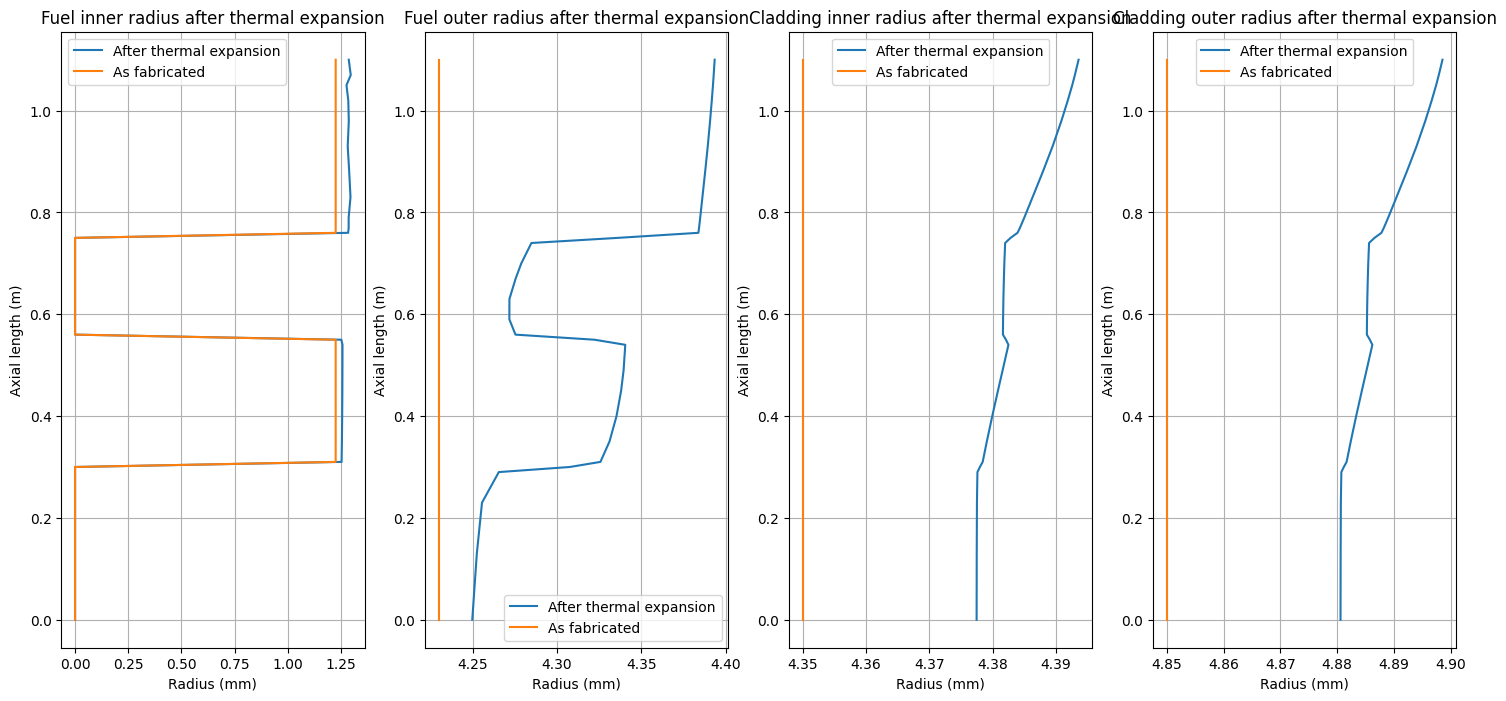

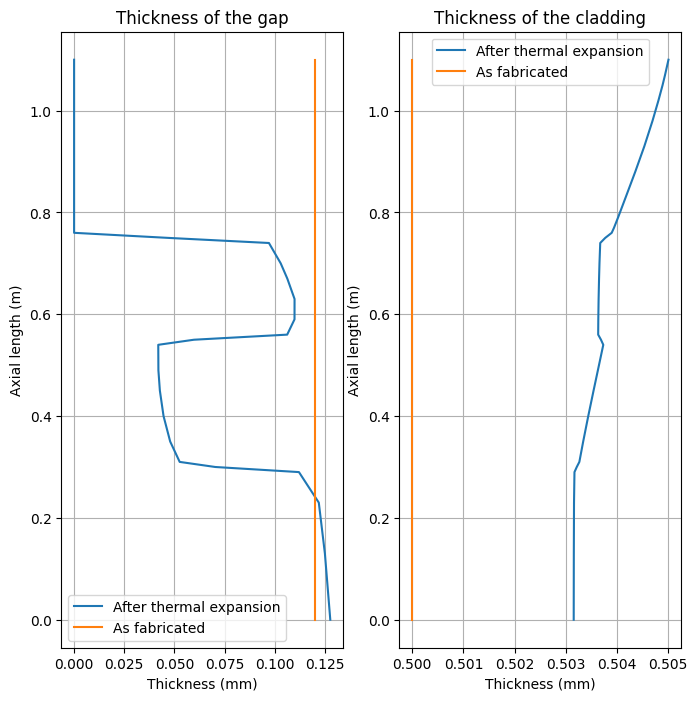

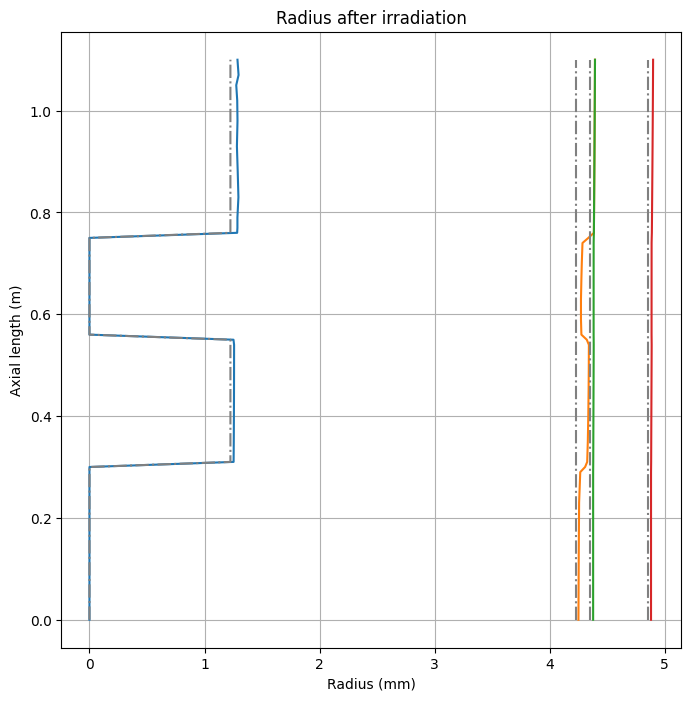

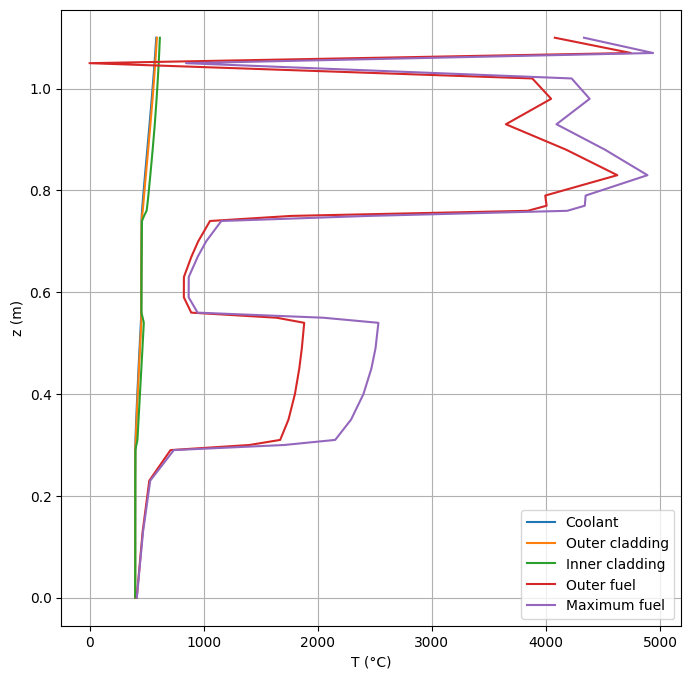

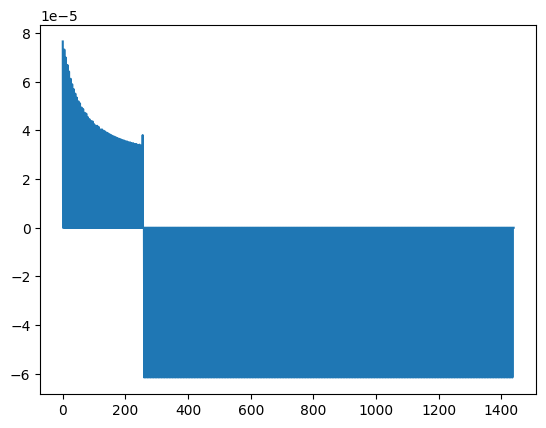

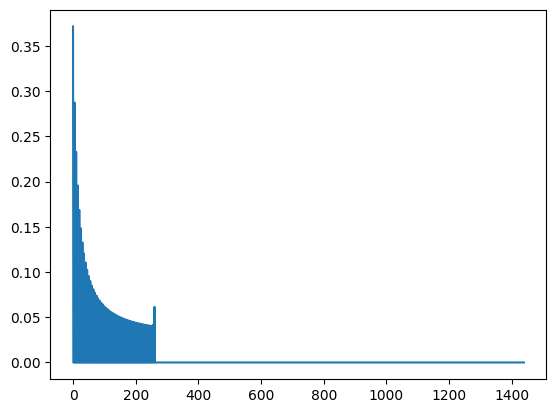

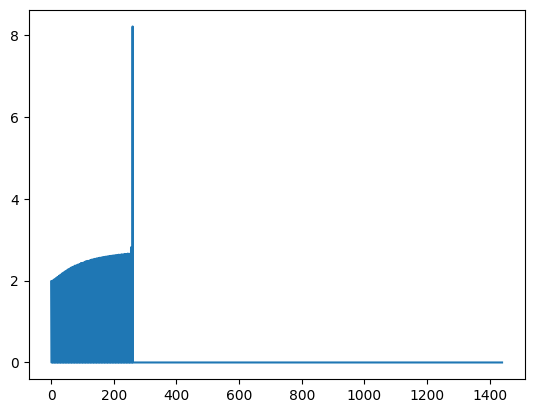

In [ ]:
contact_time,R_fo_time_th,T_co_time_th,T_ci_time_th,R_co_time_th,R_fi_time_th,R_ci_time_th = Temp_time(1440)


## Contact pressure

In [ ]:
# EVALUATION of the contact pressure
import sympy as sp
tempo = range(0,1440,5)
Sigma_r = np.zeros((1440,z.size))
Sigma_theta = np.zeros((1440,z.size))
Sigma_z = np.zeros((1440,z.size))
delta_adapt = np.zeros(z.size)

R_co_4y = np.zeros(z.size)
R_ci_4y = np.zeros(z.size)
R_fo_4y = np.zeros(z.size)
R_fi_4y = np.zeros(z.size)

# SWELLING CLAD
def clad_swelling_strain(T,phi,t):
  deltaV_V = (1.5e-3)*np.exp(-2.5*((T-450)/100)**2)*(phi*t*86400/1e22)**2.75
  return deltaV_V/3/10000

# SWELLING FUEL
def fuel_swelling_strain(bu): # bu in GWd/tHM
  return 0.07*bu/3/10000

# BURNUP BEHAVIOUR as a function of time
bu_initial = 0
bu_target = 135 # GWd/tHM
def bu_time(time): # time in days
  return 135/(4*360)*time

phi_tot = 3.38e15 # n/(s cm2)
flux = phi_tot*peak_factors*0.7

for i in range(z.size):
  if int(contact_time[i])!=0:
    for t in range(0,1440-int(contact_time[i]),5):
      delta_adapt[i] = R_fo_time_th[i]*(fuel_swelling_strain(bu_time(t))-clad_swelling_strain((T_co_time_th+T_ci_time_th)/2,flux,t)[i])
      # Definisci le variabili simboliche
      r, Rci, Rco, a, b, T_ci_time = sp.symbols('r Rci Rco a b T_ci_time')

      # Definisci la soluzione con i coefficienti da trovare
      y = a / r + b * r

      # Imposta le condizioni al contorno
      boundary_conditions = [y.subs(r, R_co_time_th[i]) - delta_adapt[i], y.subs(r, R_fo_time_th[i]) - delta_adapt[i]]

      # Risolvi il sistema di equazioni dato dalle condizioni al contorno
      coefficients = sp.solve(boundary_conditions, (a, b))

      # Aggiungi il coefficiente b alla soluzione
      u_r = y.subs([(a, coefficients[a]), (b, coefficients[b])])

      # Derivata di u_r per trovare eps_r
      strain_r = sp.diff(u_r, r)

      # Definizione delle variabili
      sigma_r, sigma_theta, sigma_z = sp.symbols('sigma_r sigma_theta sigma_z')

      # Definizione delle equazioni
      equation1 = 1 / E_clad(T_ci_time) * sigma_r - nu_clad(T_ci_time) / E_clad(T_ci_time) * sigma_theta \
                  - nu_clad(T_ci_time) / E_clad(T_ci_time) * sigma_z - strain_r
      equation2 = - nu_clad(T_ci_time) / E_clad(T_ci_time) * sigma_r + 1 / E_clad(T_ci_time) * sigma_theta \
                  - nu_clad(T_ci_time) / E_clad(T_ci_time) * sigma_z - u_r / r
      equation3 = - nu_clad(T_ci_time) * sigma_r - nu_clad(T_ci_time) * sigma_theta + sigma_z

      # Risoluzione del sistema
      solution = sp.solve([equation1, equation2, equation3], (sigma_r, sigma_theta, sigma_z))
      solution = {symbol: expr.subs(T_ci_time, T_ci_time_th[i]) for symbol, expr in solution.items()}

      # Lambdify le espressioni risultanti
      fun_r = sp.lambdify(r, solution[sigma_r], 'numpy')
      fun_theta = sp.lambdify(r, solution[sigma_theta], 'numpy')
      fun_z = sp.lambdify(r, solution[sigma_z], 'numpy')

      Sigma_r[t,i] = fun_r(R_ci_time_th[i])
      Sigma_theta[t,i] = fun_theta(R_ci_time_th[i])
      Sigma_z[t,i] = fun_z(R_ci_time_th[i])
    print(i)
    R_fo_4y[i]=R_fo_time_th[i]+delta_adapt[i]
    R_co_4y[i]=R_co_time_th[i]+delta_adapt[i]
    R_fi_4y[i]=R_fi_time_th[i]+R_fi_time_th[i]*fuel_swelling_strain(bu_time(1440))
    R_ci_4y[i]=R_ci_time_th[i]+delta_adapt[i]
  else:
    R_ci_4y[i]=R_ci_time_th[i]+R_ci_time_th[i]*clad_swelling_strain((T_co_time_th+T_ci_time_th)/2,flux,1440)[i]
    R_co_4y[i]=R_co_time_th[i]+R_co_time_th[i]*clad_swelling_strain((T_co_time_th+T_ci_time_th)/2,flux,1440)[i]
    R_fi_4y[i]=R_fi_time_th[i]+R_fi_time_th[i]*fuel_swelling_strain(bu_time(1440))
    R_fo_4y[i]=R_fo_time_th[i]+R_fo_time_th[i]*fuel_swelling_strain(bu_time(1440))

19
20
21
22
23
24
25
26
27
28
29


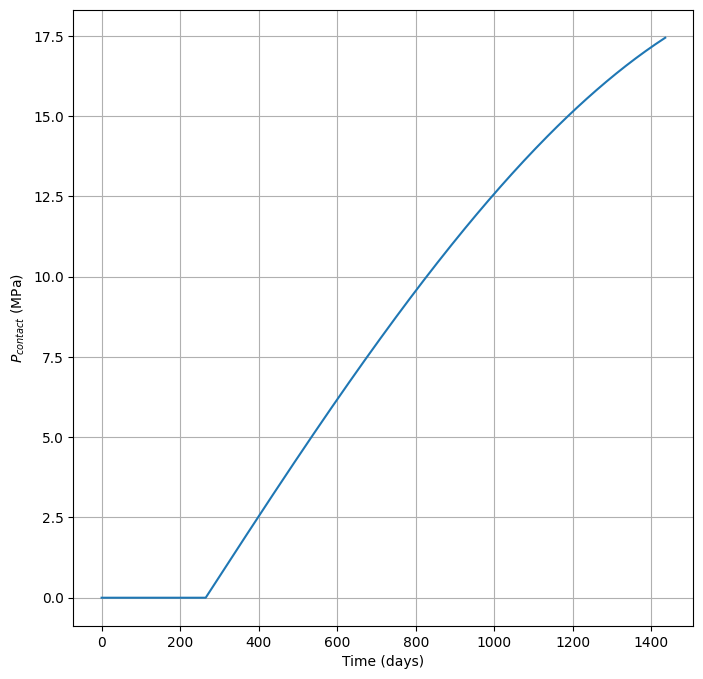

In [ ]:
tempo_23 = range(0,1440-int(contact_time[23]),5)
Sigma_r_23 = np.concatenate((
    np.zeros(int(contact_time[23]/5)),
    Sigma_r[tempo_23,23]
))

plt.figure(figsize=(8,8))
plt.plot(tempo,Sigma_r_23/1e6)
plt.grid()
plt.xlabel('Time (days)')
plt.ylabel('$P_{contact}$ (MPa)')

P_contact = np.zeros(contact_time[contact_time!=0].size)

first_axial_contact = np.argmax(contact_time==contact_time[contact_time!=0][0])

for i in range(contact_time[contact_time!=0].size):
  P_contact[i] = Sigma_r[range(0,1440-int(contact_time[contact_time!=0][i]),5),first_axial_contact+i][-1]


# New profile temp

In [ ]:
T_cool_4y = np.zeros(z.size)
T_co_4y = np.zeros(z.size)
T_ci_4y = np.zeros(z.size)
T_fo_4y = np.zeros(z.size)
T_fi_4y = np.zeros(z.size)
t_gap_4y = np.zeros(z.size)
F_v_4y = np.zeros(z.size)

#COOLANT

d_4y = 2*R_co_4y
D_h_4y = d_4y*((2*np.sqrt(3)*(p)**2)/((np.pi)*(d_4y)**2) -1) # Hydraulic diameter (m)
Delta_T_4y = np.zeros(z.size)
q_pin_4y = np.zeros(z.size)
T_cool_4y[0] = T_in
q_4y = q_time(1440)

def cp(T):
  return 971.34 - 3.69*0.1*(T) + 3.43E-4*(T)**2

for i in range (z.size-1):
    q_pin_4y[i] = (z[i+1]-z[i])*(q_4y[i+1]+q_4y[i])*0.5
    Delta_T_4y[i] = q_pin_4y[i]/(m*cp(T_cool_4y[i]))
    T_cool_4y[i+1] = T_cool_4y[i]+Delta_T_4y[i]

# OUTER CLADDING

def k_cool(T): # Thermal conductivity of the coolant(W/m K)
  T_f = T_far(T)
  return 94 - 3.25E-2 * T_f + 3.62E-6 * T_f**2

def mu(T): # Viscosity (Pa s)
  T_k = T_kelvin(T)
  return 1.0E-3*np.exp(2.3*(0.5108+(220.65/T_k)-0.2139*np.log(T_k)))

def rho(T): # Density (kg/m^3)
  T_f = T_far(T)
  return 954.1579 + T_f*(T_f*(T_f*0.9667E-9 - 0.46E-5)-0.1273534)

d_4y = 2*R_co_4y
Area_4y = 2*((np.sqrt(3)/4)*p**2 - (np.pi * d_4y**2)/8)
v_4y = m/(Area_4y*rho(T_cool_4y)) # Velocity profile of the coolant (m/s)
Re_4y = (rho(T_cool_4y)*v_4y*D_h_4y)/mu(T_cool_4y) #Reynolds profile of the coolant
Pr_4y = (cp(T_cool_4y)*mu(T_cool_4y)/k_cool(T_cool_4y)) #Prandlt profile of the coolant
Nu_4y = 7 + 0.025*(Re_4y*Pr_4y)**0.8 #Nusselt profile of the coolant
h_4y = Nu_4y*(k_cool(T_cool_4y)/D_h_4y) # Heat transfer coefficient profile of the coolant (W/m^2 K)

DT_4y = q_4y/(2*np.pi*R_co_4y*h_4y) #Temperature difference between the coolant and the outside of the claddig in each section
T_co_4y = T_cool_4y+DT_4y

#CLADDING

def cp_c(T):
  T_k = T_kelvin(T)
  return 431+0.77*T_k+8.72E-5*(T_k)**-2

def k_clad(T):
  return 13.95+0.01163*T # T in Celsius

t_clad_4y = R_co_4y-R_ci_4y
DeltaT_clad_4y = q_4y*t_clad_4y/(2*np.pi*k_clad(T_co_4y)*R_ci_4y)
T_ci_4y = T_co_4y+DeltaT_clad_4y

# GAP

for i in range(z.size):
  if int(contact_time[i])==0:
    t_gap_4y[i] = R_ci_4y[i]-R_fo_4y[i]
    n_tot =(n_He + n_Xe[1439] + n_Kr[1439])*0.3
    fracHe = n_He*0.3 / n_tot
    fracXe = n_Xe[1439]*0.3 / n_tot
    fracKr = n_Kr[1439]*0.3 / n_tot

    # Funzione da risolvere
    def equation_T_fo(T_fo, T_ci, t_gap, R_fo, He, Xe, Kr, q_lin):
        return T_fo - T_ci - q_lin * (t_gap / (2 * np.pi * R_fo * k_gas((T_fo + T_ci) / 2, He, Xe, Kr)))

    # Fornisci una stima iniziale per T_fo_time
    initial_guess_T_fo = T_fo_4y[i]

    # Utilizza fsolve per risolvere l'equazione
    T_fo_4y[i] = fsolve(equation_T_fo, initial_guess_T_fo, args=(T_ci_4y[i], t_gap_4y[i], R_fo_4y[i], fracHe, fracXe, fracKr, q_4y[i]))

  else:

    h_gap = 1e4 #W/m2 K Olander, chapter 10, pg. 139
    R_contact = 1/(2*np.pi*R_fo_4y[i]*h_gap)
    T_fo_4y[i] = T_ci_4y[i]+q_4y[i]*R_contact

# FUEL

def k_av_fuel(T_max,T_fo,Bu):

    k_av_fuel=np.concatenate((
            (I_UO2(T_max[0:5],Bu,po[0:5])-I_UO2(T_fo[0:5],Bu,po[0:5]))/(T_max[0:5]-T_fo[0:5]),          # fertile pellet nodes 1-5
            (I_MOX(T_max[5:12],Bu,x_fuel[5:12],po[5:12])-I_MOX(T_fo[5:12],Bu,x_fuel[5:12],po[5:12]))/(T_max[5:12]-T_fo[5:12]),    # fissile pellet nodes 6-12
            (I_UO2(T_max[12:19],Bu,po[12:19])-I_UO2(T_fo[12:19],Bu,po[12:19]))/(T_max[12:19]-T_fo[12:19]),    # fertile pellet nodes 13-19
            (I_MOX(T_max[19:30],Bu,x_fuel[19:30],po[19:30])-I_MOX(T_fo[19:30],Bu,x_fuel[19:30],po[19:30]))/(T_max[19:30]-T_fo[19:30])   # fissile pellet nodes 20-30
                  ))

    return k_av_fuel
# Inizializza il valore iniziale
T_fi_time_init = T_fo_4y + 1000
for i in range(z.size):
  F_v_4y[i] = F_va(R_fi_4y[i],R_fo_4y[i],i)

  # Definisci la funzione delle equazioni
  def equation(T_fi_time, T_fo_time, F_v_time, q_lin_time):
      R_fuel = (1 / (4 * np.pi * k_av_fuel(T_fi_time, T_fo_time,135/950))) * F_v_time
      T_fi_iter = T_fo_time + q_lin_time * R_fuel
      return T_fi_iter - T_fi_time

  # Risolvi l'equazione utilizzando fsolve
  result = fsolve(equation, T_fi_time_init, args=(T_fo_4y, F_v_4y[i], q_4y[i]))

  # Estrai il valore specifico
  T_fi_4y[i] = result[i]

# correction of unphysical phenomenon in the plot
T_fo_4y[18] = T_fo_4y[19]
T_fi_4y[18] = T_fi_4y[19]


Text(0, 0.5, 'Axial length (m)')

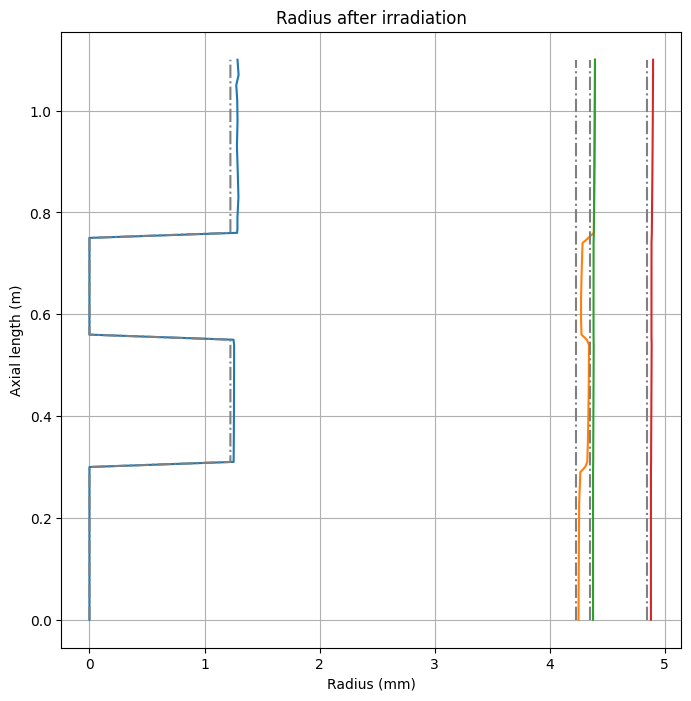

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(R_fi_4y*1000,z)
plt.plot(R_fi*1000,z,'-.',color='gray')
plt.plot(R_fo_4y*1000,z)
plt.plot(R_fo*np.ones(z.size)*1000,z,'-.',color='gray')
plt.plot(R_ci_4y*1000,z)
plt.plot(R_ci*np.ones(z.size)*1000,z,'-.',color='gray')
plt.plot(R_co_4y*1000,z)
plt.plot(R_co*np.ones(z.size)*1000,z,'-.',color='gray')
plt.grid()
plt.title('Radius after irradiation')
plt.xlabel('Radius (mm)')
plt.ylabel('Axial length (m)')

Text(0, 0.5, 'z (m)')

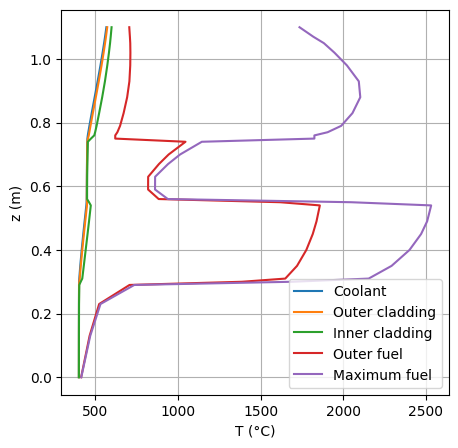

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(T_cool_4y,z,label='Coolant')
plt.plot(T_co_4y,z,label='Outer cladding')
plt.plot(T_ci_4y,z,label='Inner cladding')
plt.plot(T_fo_4y,z,label='Outer fuel')
plt.plot(T_fi_4y,z,label='Maximum fuel')
plt.grid()
plt.legend()
plt.xlabel('T (°C)')
plt.ylabel('z (m)')


The equiaxed grains region has radius:
 [0.00445699 0.00459855 0.00467947 0.00472644 0.00475342 0.0047813
 0.00438221]


The columnar grains region has radius:
 [0.00380514 0.00407364 0.00422806 0.00431365 0.00435805 0.00439537
 0.00356414]


The void region has radius:
 [0.00165917 0.00170922 0.00174173 0.00176146 0.00177228 0.00178145
 0.00162528]


The new maximum temperature for the fuel is:
 [ 414.33369039  468.61470603  530.62979924  735.40777982 1690.31731516
 2046.22905918 2143.1496815  2220.454099   2270.94852415 2297.24576477
 2314.39667001 1971.19116067  938.3180832   860.86514098  861.36274518
  939.79126492 1012.42835352 1144.10209031 1825.40136614 1825.40136614
 1905.56916426 1987.55986328 2055.8541649  2103.22561997 2094.19555777
 2022.29033174 1946.82998556 1882.65153426 1819.35834659 1735.29290536]




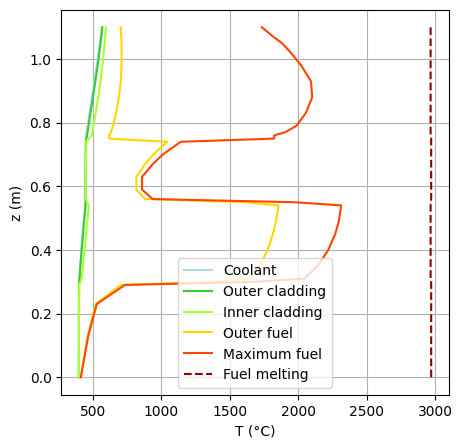

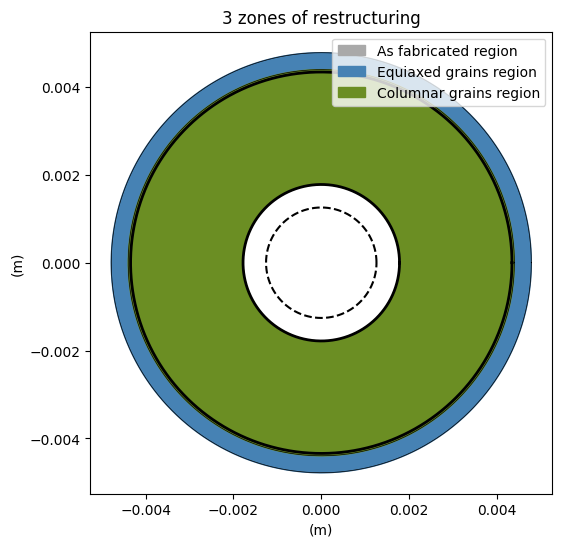

In [ ]:
# FUEL RESTRUCTURING - only on fissile pellets
#                      because are the only one in which the temperature goes
#                      above 1800°C, so the only one in which there is the
#                      formation of the central void

# Data

rho_0=0.95*np.ones(7) #units of TD
rho_eqax=0.95*np.ones(7) #units of TD
rho_clmn=0.98*np.ones(7) #units of TD

po_eqax=1-rho_eqax
po_clmn=1-rho_clmn

T_fo_th_first_fissile_4y=T_fo_4y[5:12]
x_fuel_restruct=x_fuel[5:12]
T_eqax=np.ones(7)*1600 # °C
T_clmn=np.ones(7)*1800 # °C
R_fo_th_first_fissile_4y=R_fo_4y[5:12]
R_fi_th_first_fissile_4y=R_fi_4y[5:12]
R_fo_first_fissile=R_fo*np.ones(7)
R_fi_first_fissile=R_fi_fissile*np.ones(7)


# density as fabricated zone after thermal expansion

rho_as_fabricated_4y=rho_0*(R_fo_first_fissile**2-R_fi_first_fissile**2)/(R_fo_th_first_fissile_4y**2-R_fi_th_first_fissile_4y**2)

# porosity as fabricated after thermal expansion

po_as_fabricated_4y=1-rho_as_fabricated_4y

# As fabricated region: find R equiaxed region

R_eqax_4y=R_fo_th_first_fissile_4y*(np.sqrt(1-(4*np.pi*(I_MOX(T_eqax,135/950,x_fuel_restruct,po_as_fabricated_4y)-I_MOX(T_fo_th_first_fissile_4y,135/950,x_fuel_restruct,po_as_fabricated_4y)))/q_4y[5:12]))

print(f'The equiaxed grains region has radius:\n {R_eqax_4y}\n\n')

# Equiaxed grains region: find R columnar region

def equiaxed_equation(R_clmn):

    return I_MOX(T_clmn,135/950,x_fuel_restruct,po_eqax)-I_MOX(T_eqax,135/950,x_fuel_restruct,po_eqax)-((q_4y[5:12]/(4*np.pi))*(rho_eqax/rho_as_fabricated_4y)*((R_eqax_4y/R_fo_th_first_fissile_4y)**2)*(1-((R_clmn/R_eqax_4y)**2)-(1-rho_as_fabricated_4y/rho_eqax)*np.log((R_eqax_4y/R_clmn)**2)))

R_clmn_4y=fsolve(equiaxed_equation, R_eqax_4y)

print(f'The columnar grains region has radius:\n {R_clmn_4y}\n\n')

# Mass balance(3 regions model): find R of the void

R_void_4y=np.sqrt(((rho_eqax-rho_as_fabricated_4y)*R_eqax_4y**2+(rho_clmn-rho_eqax)*R_clmn_4y**2+rho_as_fabricated_4y*R_fi_th_first_fissile_4y**2)/rho_clmn)

print(f'The void region has radius:\n {R_void_4y}\n\n')


# Columnar grains region: find T max fuel

Conductivity_int_Tmax_restruct=I_MOX(T_clmn,135/950,x_fuel_restruct,po_clmn)+(q_4y[5:12]/(4*np.pi))*(rho_clmn/rho_as_fabricated_4y)*((R_clmn_4y/R_fo_th_first_fissile_4y)**2)*(1-((R_void_4y/R_clmn_4y)**2)-((R_void_4y/R_clmn_4y)**2)*np.log((R_clmn_4y/R_void_4y)**2))

def columnar_equation(T_max):

    return I_MOX(T_max,135/950,x_fuel_restruct,po_clmn)-Conductivity_int_Tmax_restruct

T_max_restruct_4y=fsolve(columnar_equation, T_fi_4y[5:12])

T_max_restruct_4y=np.concatenate(( T_fi_4y[0:5],
                                T_max_restruct_4y,
                                   T_fi_4y[12:30]
                                ))

print(f'The new maximum temperature for the fuel is:\n {T_max_restruct_4y}\n\n')

# plot of the new temperature profiles (thermal expansion+restructuring)

# Melting Temperature in Kelvin
def T_melt(Pu,x,bu):
    return 2964.92 + ((3147 - 364.85*Pu - 1014.15*x) -2964.92) *np.exp(-bu/(40.43))

T_melting_4y = T_melt(Pu_conc,x_fuel,135)
plt.figure(figsize=(5,5))
plt.plot(T_cool_4y,z,label='Coolant', color='lightblue')
plt.plot(T_co_4y,z,label='Outer cladding', color='limegreen')
plt.plot(T_ci_4y,z,label='Inner cladding', color='greenyellow')
plt.plot(T_fo_4y,z,label='Outer fuel', color='gold')
plt.plot(T_max_restruct_4y,z,label='Maximum fuel', color='orangered')
plt.plot(T_melting_4y,z,label='Fuel melting', color='darkred', linestyle='--')
plt.grid()
plt.legend()
plt.xlabel('T (°C)')
plt.ylabel('z (m)')

### Plot of the fuel regions

# Generate theta values for the circles

theta = np.linspace(0, 2*np.pi, 5000)

# Radius in correspondence of the maximum axial temperature

axial_position_4y=np.argmax(T_max_restruct_4y)-12

# x,y coordinates fuel out

x_fo_4y=R_fo_th_first_fissile_4y[axial_position_4y]*np.cos(theta)
y_fo_4y=R_fo_th_first_fissile_4y[axial_position_4y]*np.sin(theta)

# x,y coordinates equiaxed grains boundary

x_eqax_4y=R_eqax_4y[axial_position_4y]*np.cos(theta)
y_eqax_4y=R_eqax_4y[axial_position_4y]*np.sin(theta)

# x,y coordinates columnar grains boundary

x_clmn_4y=R_clmn_4y[axial_position_4y]*np.cos(theta)
y_clmn_4y=R_clmn_4y[axial_position_4y]*np.sin(theta)

# x,y coordinates void boundary

x_void_4y=R_void_4y[axial_position_4y]*np.cos(theta)
y_void_4y=R_void_4y[axial_position_4y]*np.sin(theta)

# x,y coordinates initial central hole

x_fi_4y=R_fi_th_first_fissile_4y[axial_position_4y]*np.cos(theta)
y_fi_4y=R_fi_th_first_fissile_4y[axial_position_4y]*np.sin(theta)

# Plot

plt.figure(figsize=(6,6))

plt.plot(x_fo_4y, y_fo_4y, color='k', linewidth=2)
plt.plot(x_eqax_4y, y_eqax_4y, color='k', linewidth=0.5)
plt.plot(x_clmn_4y, y_clmn_4y, color='k', linewidth=0.5)
plt.plot(x_void_4y, y_void_4y, color='k', linewidth=2)
plt.plot(x_fi_4y, y_fi_4y, color='k', linestyle='--')


# Create the boundary and fill regions
x_as_fabricated_boundary_4y = np.concatenate((x_eqax_4y, x_fo_4y[::-1]))
y_as_fabricated_boundary_4y = np.concatenate((y_eqax_4y, y_fo_4y[::-1]))

plt.fill(x_as_fabricated_boundary_4y, y_as_fabricated_boundary_4y, color='darkgray', alpha=1)

x_eqax_boundary_4y = np.concatenate((x_clmn_4y, x_eqax_4y[::-1]))
y_eqax_boundary_4y = np.concatenate((y_clmn_4y, y_eqax_4y[::-1]))

plt.fill(x_eqax_boundary_4y, y_eqax_boundary_4y, color='steelblue', alpha=1)

x_clmn_boundary_4y = np.concatenate((x_void_4y, x_clmn_4y[::-1]))
y_clmn_boundary_4y = np.concatenate((y_void_4y, y_clmn_4y[::-1]))

plt.fill(x_clmn_boundary_4y, y_clmn_boundary_4y, color='olivedrab', alpha=1)


# Set aspect of the plot to be equal, so the circles look like circles
plt.gca().set_aspect('equal', adjustable='box')

# Set labels and title

plt.title('3 zones of restructuring')
plt.xlabel('(m)')
plt.ylabel('(m)')
as_fabricated_patch = mpatches.Patch(color='darkgray', alpha=1, label='As fabricated region')
eqax_patch = mpatches.Patch(color='steelblue', alpha=1, label='Equiaxed grains region')
clmn_patch = mpatches.Patch(color='olivedrab', alpha=1, label='Columnar grains region')
plt.legend(handles=[as_fabricated_patch, eqax_patch, clmn_patch], loc='best')



#Cladding volumetric swelling

In [ ]:
# SWELLING CLADDING

def clad_swelling_strain(T,phi,t):
  deltaV_V = (1.5e-3)*np.exp(-2.5*((T-450)/100)**2)*(phi*t*86400/1e22)**2.75
  return deltaV_V/3/10000

phi_tot = 3.38e15 # n/(s cm2)
flux = phi_tot*peak_factors*0.7

Mean_T_clad = (T_ci_4y+T_co_4y)/2

#swelling EOL
Clad_swelling = clad_swelling_strain(Mean_T_clad, flux, 1440)

print(Clad_swelling)

limit_swelling = np.ones(z.size)*0.06

verification = Clad_swelling<limit_swelling

for i in range(z.size):
  if verification[i]==False:
    print('\n\nThe cladding volumetric swelling is over the limit')
if verification.all()==True:
  print('\n\nThe cladding volumetric swelling is under the limit')

[1.64923564e-12 1.38724199e-10 9.42660791e-10 1.98065308e-08
 4.40220870e-06 2.70125272e-05 4.90280781e-05 7.83483272e-05
 1.03818134e-04 1.16701185e-04 1.19085302e-04 2.27005047e-05
 1.44665639e-07 7.83295622e-08 7.83504569e-08 1.44736773e-07
 2.38887100e-07 5.26171941e-07 6.16862809e-05 2.85104714e-04
 3.13753153e-04 3.17995745e-04 2.53444572e-04 1.51116945e-04
 7.14281714e-05 2.83240454e-05 1.26516626e-05 6.75589941e-06
 4.38287442e-06 2.29374143e-06]


The cladding volumetric swelling is under the limit


#Mechanical analysis EOL

##Definition of quantities

In [ ]:
# QUANTITIES FOR MECHANICAL ANALYSYS

### Material properties

# Linear thermal expansion coefficient

# writing the quadratic correlation of eps_clad as eps=alpha(T)*(T_Tref) with alpha(T)=a+b*T we find
def alpha_clad(T):
  return 1.55e-5+2.75e-9*T

# Thermal expansion coefficient (radial mean value)
def alpha_clad_mean_4y(i):
   return (alpha_clad(T_ci_4y[i])+alpha_clad(T_co_4y[i]))/2 # use arithmetic mean because alpha_clad is a linear function

# Young's modulus (radial mean value)
def E_clad(T):
  return (202.7-(81.67e-3)*T)*1e9 # in Pa

def E_clad_mean_4y(i):
  return (E_clad(T_ci_4y[i])+E_clad(T_co_4y[i]))/2 # use arithmetic mean because E_clad is a linear function

# Poisson ratio (radial mean value)
def nu_clad(T):
  return 0.277+(6e-5)*T

def nu_clad_mean_4y(i):
  return (nu_clad(T_ci_4y[i])+nu_clad(T_co_4y[i]))/2 # use arithmetic mean because E_clad is a linear function


### Mesh

N_radial = 30
Points_4y = np.zeros((z.size, N_radial))

for i in range(z.size):
  Points_4y[i][:] = np.linspace(R_ci_4y[i], R_co_4y[i], N_radial)


### Inner and outer pressure cladding


P_coolant = 0.3e6 #Pa     # not considering pressure losses and gravity


P_in_4y = np.concatenate((
         np.ones(5)*p_plenum,
         np.ones(7)*p_plenum,
         np.ones(7)*p_plenum,
         np.ones(11)*P_contact
         ))

P_out_4y = P_coolant
P_4y = P_in_4y - P_out_4y

print(f'\nInner pressure = {np.round(P_in_4y,-3)} Pa\n')
print(f'\nOuter pressure = {np.round(P_out_4y,-3)} Pa\n')


### axial point where to evaluate stress

# the axial coordinate in which makes sense evaluating the stress is the one
# in which the cladding suffers the highest temperature jump
deltaT_clad_4y = T_ci_4y-T_co_4y
index_4y=np.argmax(deltaT_clad_4y)

print(f'\nRadial profiles evaluated in axial node {index}\n')




Inner pressure = [       0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0.        0.        0.
        0.        0.        0.        0.        0. 10535000.  9148000.
  9551000. 12862000. 17445000. 20298000. 20456000. 18640000. 17775000.
 16388000. 14423000.] Pa


Outer pressure = 300000.0 Pa


Radial profiles evaluated in axial node 23



##Cladding thermal stress

In [ ]:
# CLADDING THERMAL STRESS (NO MECHANICAL LOAD)


# Radial temperature profile in cladding as function of axial node i and position r
def T_clad_rad_4y(i,r):
  m = (T_ci_4y[i]-T_co_4y[i])/(R_ci_4y[i]-R_co_4y[i])
  return T_co_4y[i]+m*(r-R_co_4y[i])

# Thermal stress matrices

sigma_r_th_EOL = np.zeros((z.size, N_radial))
sigma_theta_th_EOL = np.zeros((z.size, N_radial))
sigma_z_th_EOL = np.zeros((z.size, N_radial))

integral_1_4y = np.zeros(z.size)
integral_2_4y = np.zeros((z.size,N_radial))

for k in range(z.size):

  integral_1_4y[k] = quad(lambda r: T_clad_rad_4y(k,r)*r, R_ci_4y[k], R_co_4y[k])[0]

  for j in range(N_radial):

    integral_2_4y[k][j] = quad(lambda r: T_clad_rad_4y(k,r)*r, R_ci_4y[k], Points_4y[k][j])[0]

    sigma_r_th_EOL[k][j] = (alpha_clad_mean_4y(k)*E_clad_mean_4y(k))/((1-nu_clad_mean_4y(k))*Points_4y[k][j]**2)*((Points_4y[k][j]**2-R_ci_4y[k]**2)/(R_co_4y[k]**2-R_ci_4y[k]**2)*integral_1_4y[k]-integral_2_4y[k][j])
    sigma_theta_th_EOL[k][j] = (alpha_clad_mean_4y(k)*E_clad_mean_4y(k))/((1-nu_clad_mean_4y(k))*Points_4y[k][j]**2)*((Points_4y[k][j]**2+R_ci_4y[k]**2)/(R_co_4y[k]**2-R_ci_4y[k]**2)*integral_1_4y[k]+integral_2_4y[k][j]-T_clad_rad(k,Points_4y[k][j])*Points_4y[k][j]**2)
    sigma_z_th_EOL[k][j] = sigma_r_th_EOL[k][j]+sigma_theta_th_EOL[k][j]




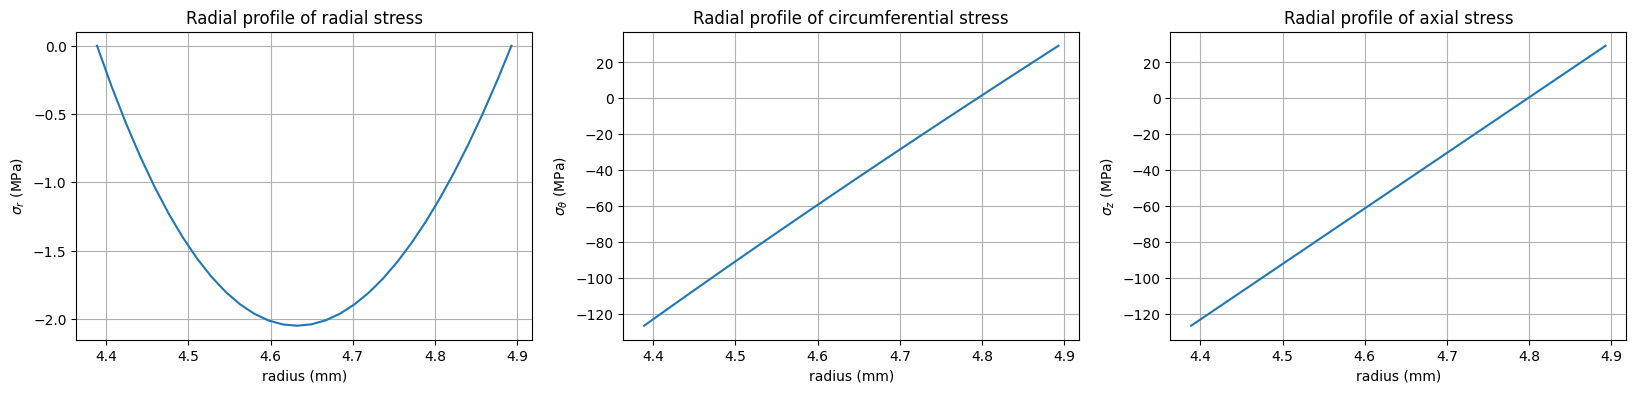

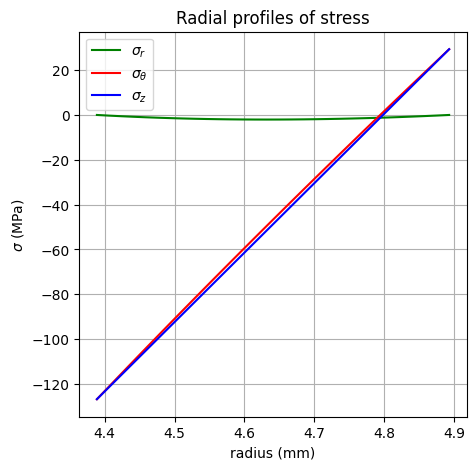

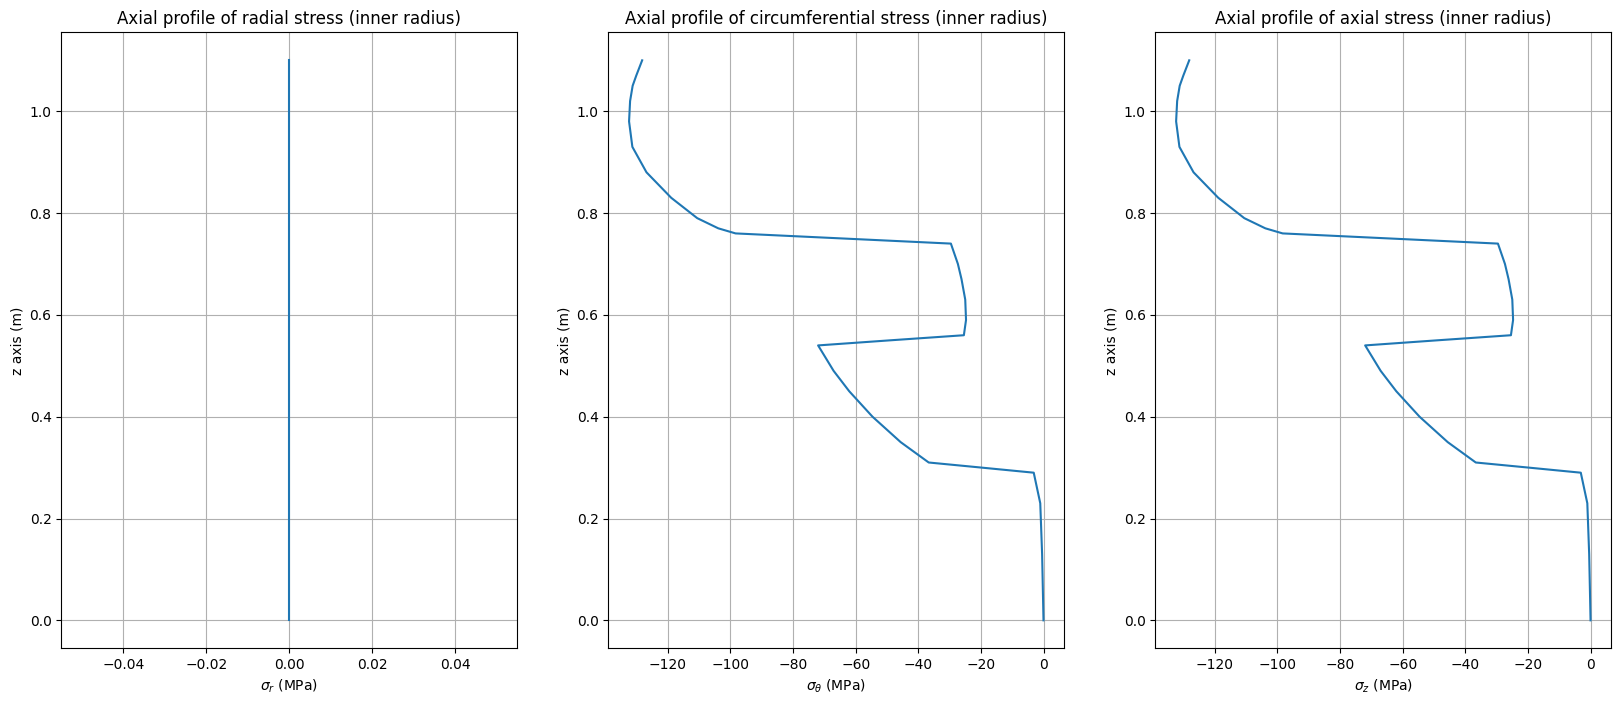

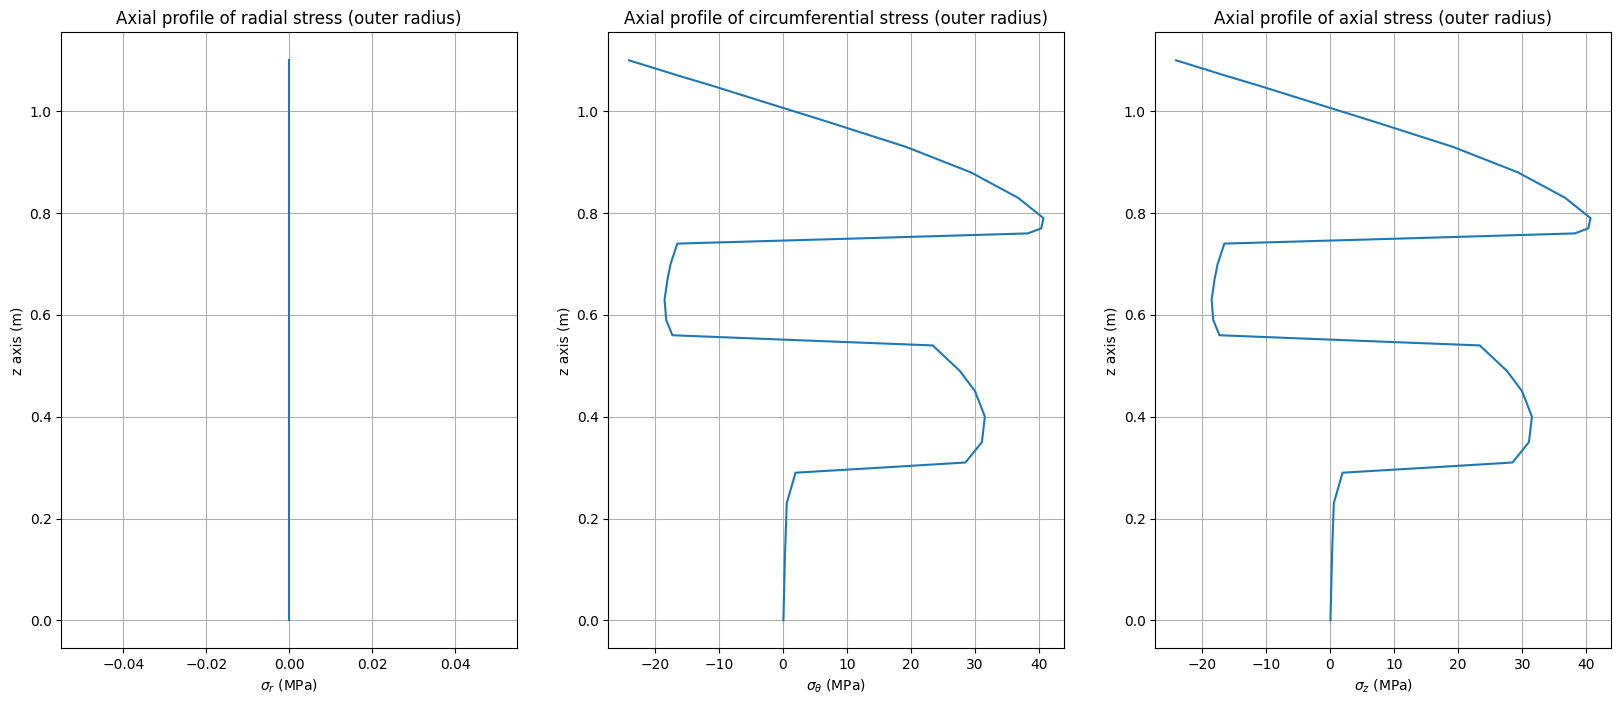

In [ ]:
# Plots

# radial plots

plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot(Points_4y[index,:]*1e3, sigma_r_th_EOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{r}$ (MPa)')
plt.title('Radial profile of radial stress')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Points_4y[index,:]*1e3, sigma_theta_th_EOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Radial profile of circumferential stress')
plt.grid()

plt.subplot(1,3,3)
plt.plot(Points_4y[index,:]*1e3, sigma_z_th_EOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{z}$ (MPa)')
plt.title('Radial profile of axial stress')
plt.grid()

plt.figure(figsize=(5,5))

plt.plot(Points_4y[index,:]*1e3, sigma_r_th_EOL[index,:]*1e-6, color='g', label='$\sigma_{r}$')
plt.plot(Points_4y[index,:]*1e3, sigma_theta_th_EOL[index,:]*1e-6, color='r', label='$\sigma_{\\theta}$')
plt.plot(Points_4y[index,:]*1e3, sigma_z_th_EOL[index,:]*1e-6, color='b', label='$\sigma_{z}$')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma$ (MPa)')
plt.title('Radial profiles of stress')
plt.legend()
plt.grid()


# axial plots


# inner radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_th_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (inner radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_th_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (inner radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_th_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (inner radius)')
plt.grid()

# outer radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_th_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (outer radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_th_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (outer radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_th_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (outer radius)')
plt.grid()


##Cladding mechanical stress

In [ ]:
# CLADDING MECHANICAL LOAD (NO TEMPERATURE GRADIENT)


# Mechanical stress matrices with Lamè profiles

sigma_r_mec_EOL = np.zeros((z.size, N_radial))
sigma_theta_mec_EOL = np.zeros((z.size, N_radial))
sigma_z_mec_EOL = np.zeros((z.size, N_radial))

C1_4y = np.zeros(z.size)
C2_4y = np.zeros(z.size)

for k in range(z.size):

  C1_4y[k] = P_4y[k]*(R_co_4y[k]**2*R_ci_4y[k]**2)/(R_co_4y[k]**2-R_ci_4y[k]**2)
  C2_4y[k]=  P_4y[k]*(R_ci_4y[k]**2)/(R_co_4y[k]**2-R_ci_4y[k]**2)

  for j in range(N_radial):

    sigma_r_mec_EOL[k][j] = -C1_4y[k]/Points_4y[k][j]**2+C2_4y[k]-P_out_4y
    sigma_theta_mec_EOL[k][j] = C1_4y[k]/Points_4y[k][j]**2+C2_4y[k]-P_out_4y
    sigma_z_mec_EOL[k][j] = nu_clad_mean_4y(k)*2*(C2_4y[k]-P_out_4y)  # hypothesis of plane strain eps_z=0


# Mechanical stress matrices with Mariotte profiles

sigma_r_mec_Mar_EOL = np.zeros((z.size, N_radial))
sigma_theta_mec_Mar_EOL = np.zeros((z.size, N_radial))
sigma_z_mec_Mar_EOL = np.zeros((z.size, N_radial))

R_4y = np.zeros(z.size)
t_4y = np.zeros(z.size)

for k in range(z.size):

  R_4y[k] = (R_co_4y[k]+R_ci_4y[k])/2
  t_4y[k] = R_co_4y[k]-R_ci_4y[k]

  for j in range(N_radial):

    sigma_r_mec_Mar_EOL[k][j] = -P_4y[k]/2-P_out_4y
    sigma_theta_mec_Mar_EOL[k][j] = P_4y[k]*R_4y[k]/t_4y[k]-P_out_4y
    sigma_z_mec_Mar_EOL[k][j] = P_4y[k]*R_4y[k]/(2*t_4y[k])-P_out_4y

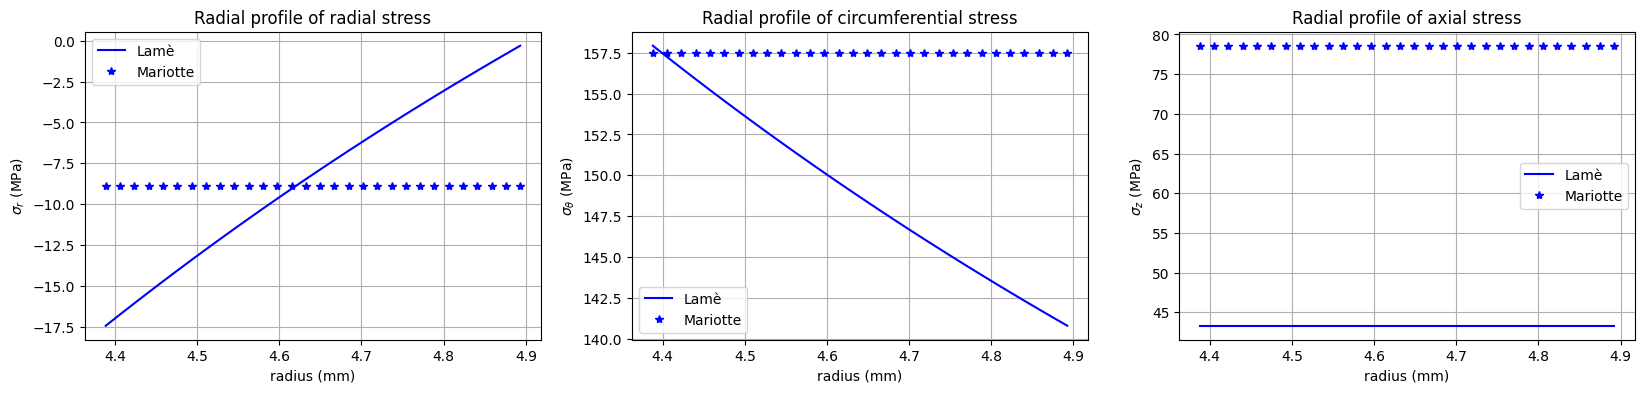

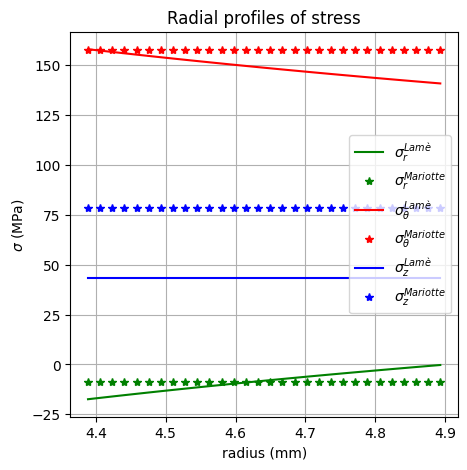

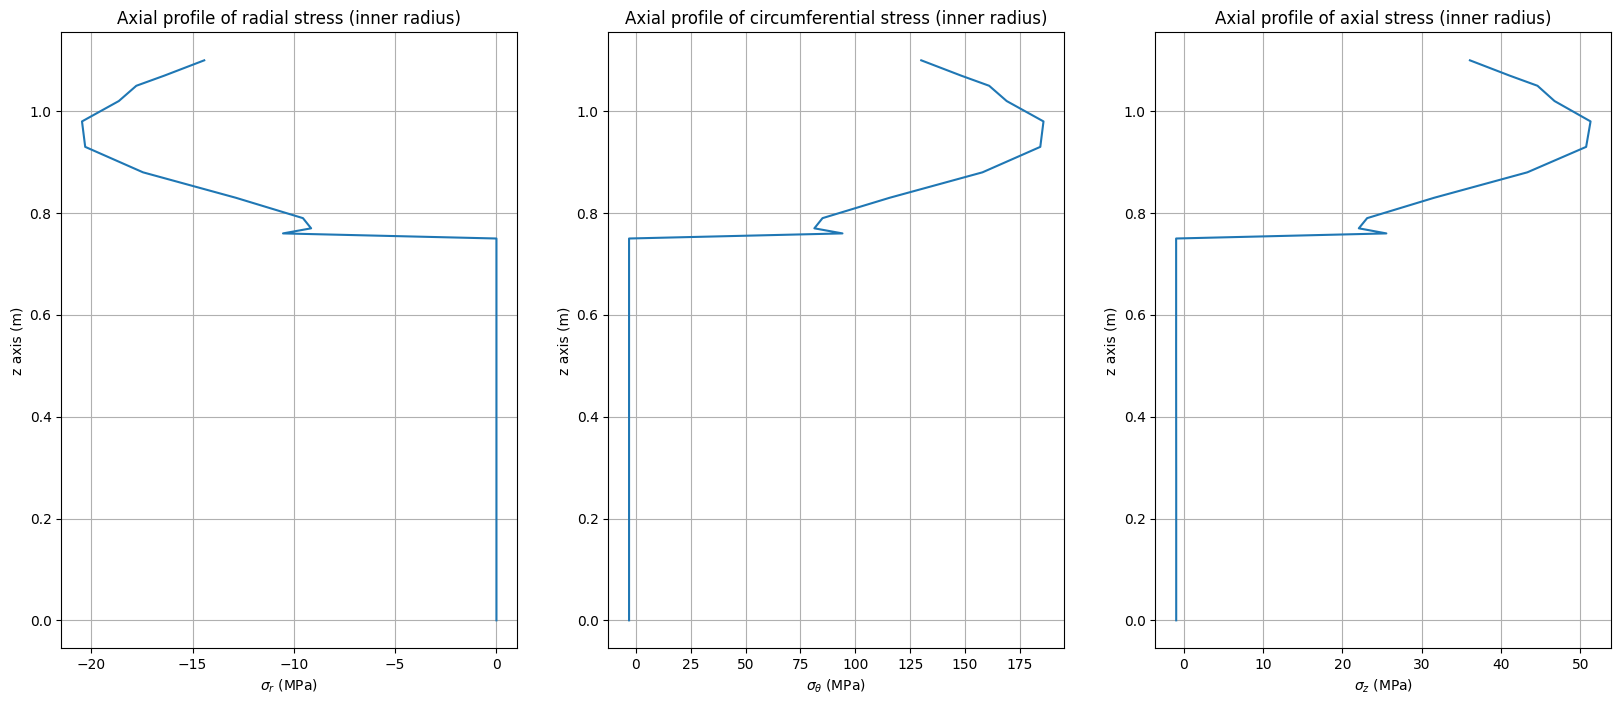

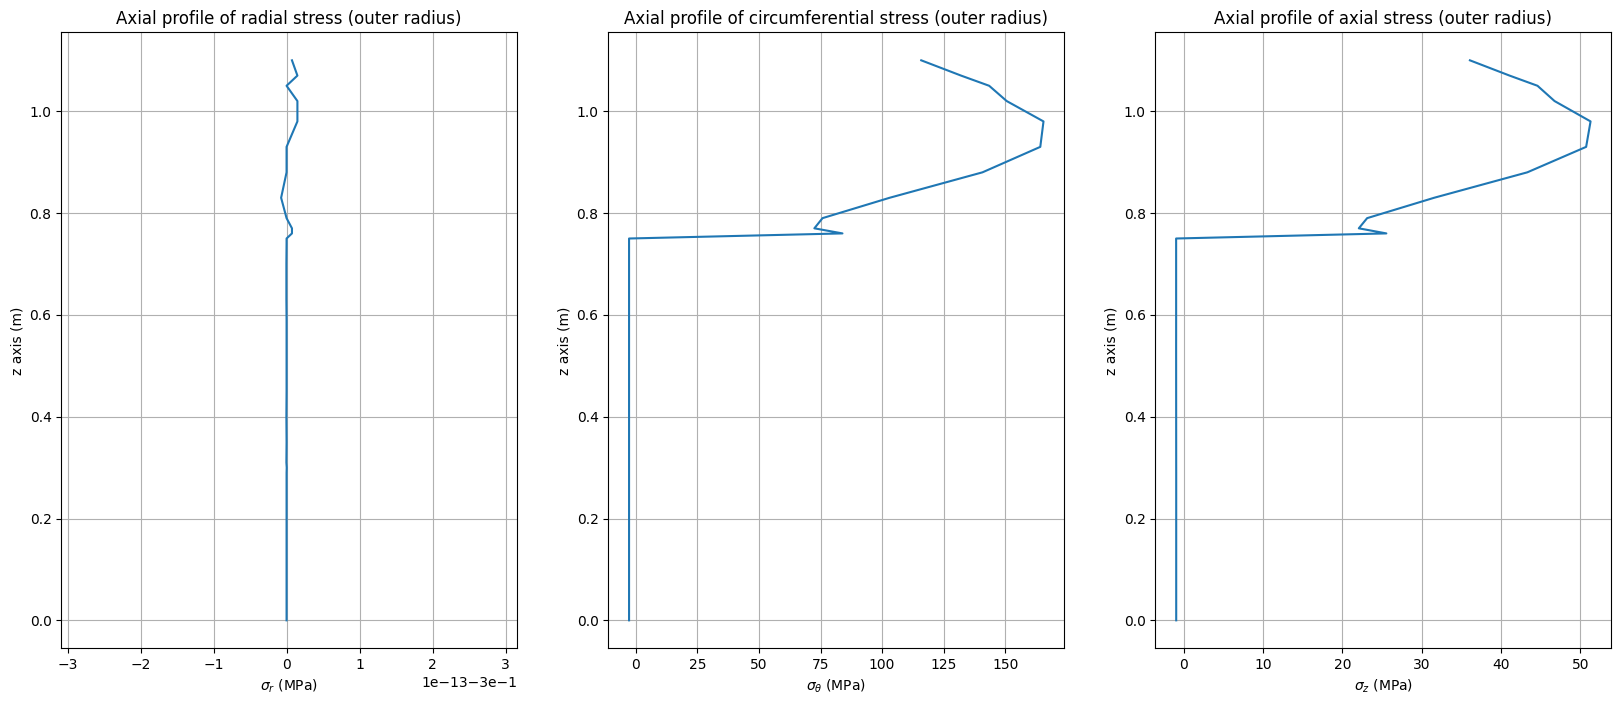

In [ ]:
# Plots

# radial plots

plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot(Points_4y[index,:]*1e3, sigma_r_mec_EOL[index,:]*1e-6, 'b-',  label='Lamè')
plt.plot(Points_4y[index,:]*1e3, sigma_r_mec_Mar_EOL[index,:]*1e-6, 'b*',  label='Mariotte')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{r}$ (MPa)')
plt.title('Radial profile of radial stress')
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(Points[index_4y,:]*1e3, sigma_theta_mec_EOL[index,:]*1e-6, 'b-',  label='Lamè')
plt.plot(Points[index_4y,:]*1e3, sigma_theta_mec_Mar_EOL[index,:]*1e-6, 'b*',  label='Mariotte')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Radial profile of circumferential stress')
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(Points[index_4y,:]*1e3, sigma_z_mec_EOL[index,:]*1e-6, 'b-',  label='Lamè')
plt.plot(Points[index_4y,:]*1e3, sigma_z_mec_Mar_EOL[index,:]*1e-6, 'b*',  label='Mariotte')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{z}$ (MPa)')
plt.title('Radial profile of axial stress')
plt.legend()
plt.grid()

plt.figure(figsize=(5,5))

plt.plot(Points_4y[index,:]*1e3, sigma_r_mec_EOL[index,:]*1e-6, color='g', label='$\sigma_{r}^{Lamè}$')
plt.plot(Points_4y[index,:]*1e3, sigma_r_mec_Mar_EOL[index,:]*1e-6, 'g*',  label='$\sigma_{r}^{Mariotte}$')
plt.plot(Points_4y[index,:]*1e3, sigma_theta_mec_EOL[index,:]*1e-6, color='r', label='$\sigma_{\\theta}^{Lamè}$')
plt.plot(Points_4y[index,:]*1e3, sigma_theta_mec_Mar_EOL[index,:]*1e-6, 'r*',  label='$\sigma_{\\theta}^{Mariotte}$')
plt.plot(Points_4y[index,:]*1e3, sigma_z_mec_EOL[index,:]*1e-6, color='b', label='$\sigma_{z}^{Lamè}$')
plt.plot(Points_4y[index,:]*1e3, sigma_z_mec_Mar_EOL[index,:]*1e-6, 'b*',  label='$\sigma_{z}^{Mariotte}$')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma$ (MPa)')
plt.title('Radial profiles of stress')
plt.legend()
plt.grid()


# axial plots


# inner radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_mec_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (inner radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_mec_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (inner radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_mec_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (inner radius)')
plt.grid()

# outer radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_mec_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (outer radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_mec_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (outer radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_mec_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (outer radius)')
plt.grid()

##Cladding total stress

In [ ]:
# CLADDING WITH PRESSURE AND TEMPERATURE GRADIENT

#Since we are deling with a linear equation the sum of the 2 previous
#solutions is still solution of the problem

# Total stress matrices (for the mechanical part use Lamè profiles)

sigma_r_EOL = np.zeros((z.size, N_radial))
sigma_theta_EOL = np.zeros((z.size, N_radial))
sigma_z_EOL = np.zeros((z.size, N_radial))


for k in range(z.size):

  for j in range(N_radial):

    sigma_r_EOL[k][j] = sigma_r_mec_EOL[k][j]+sigma_r_th_EOL[k][j]
    sigma_theta_EOL[k][j] = sigma_theta_mec_EOL[k][j]+sigma_theta_th_EOL[k][j]
    sigma_z_EOL[k][j] = sigma_z_mec_EOL[k][j]+sigma_z_th_EOL[k][j]


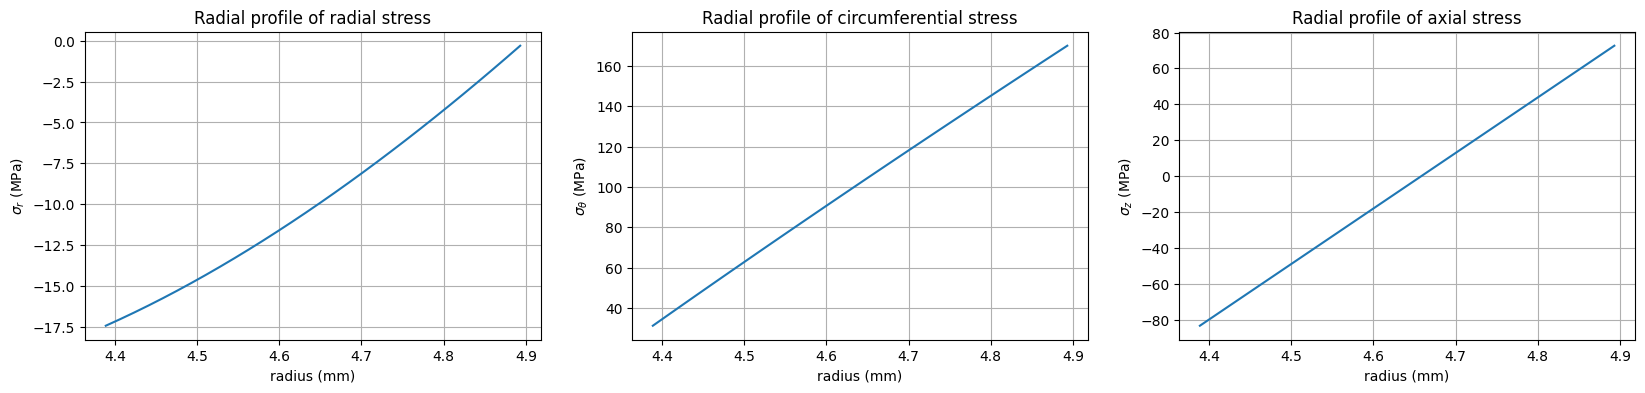

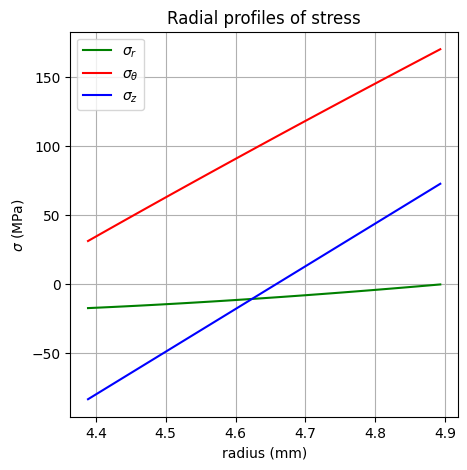

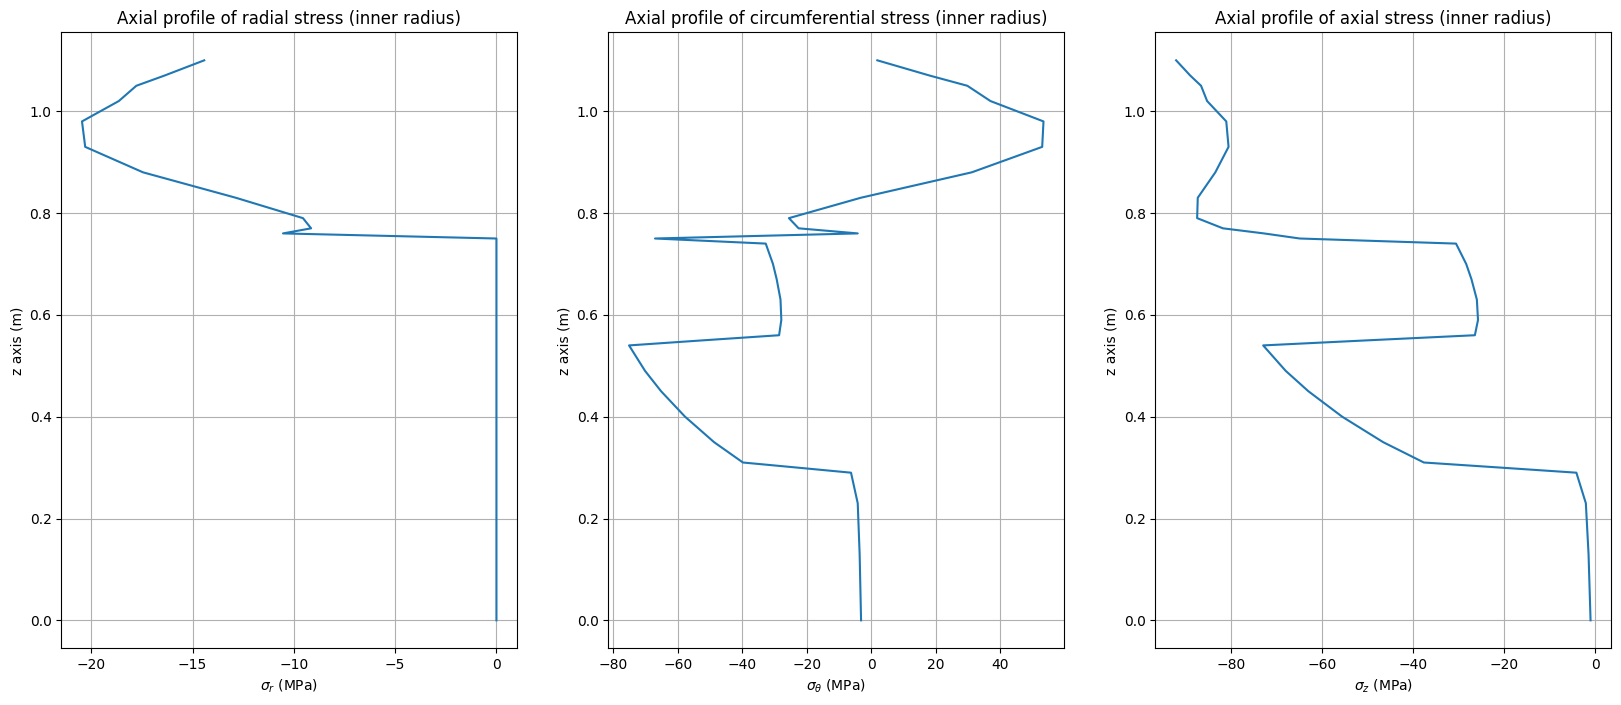

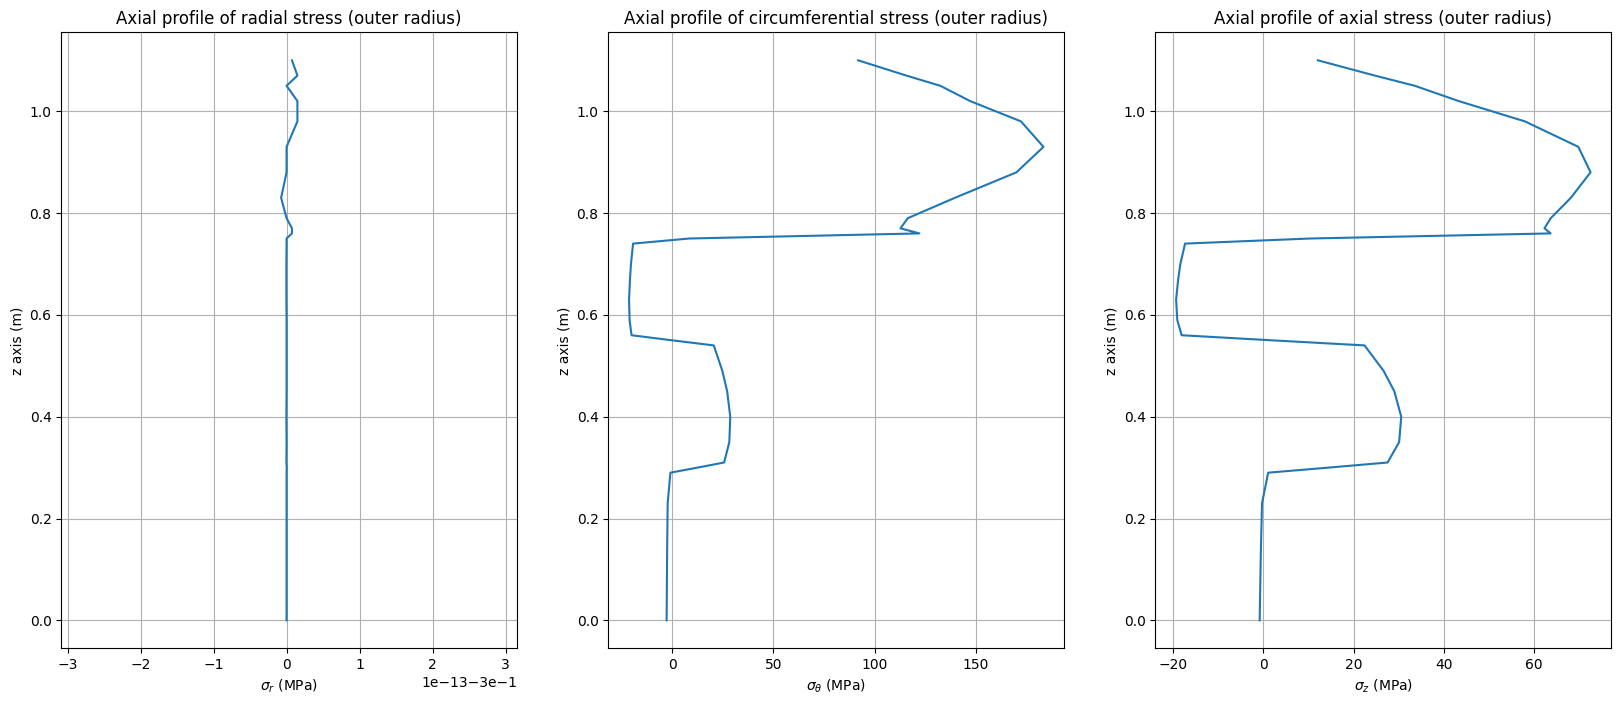

In [ ]:
# Plots

# radial plots

plt.figure(figsize=(20,4))

plt.subplot(1,3,1)
plt.plot(Points_4y[index,:]*1e3, sigma_r_EOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{r}$ (MPa)')
plt.title('Radial profile of radial stress')
plt.grid()

plt.subplot(1,3,2)
plt.plot(Points_4y[index,:]*1e3, sigma_theta_EOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Radial profile of circumferential stress')
plt.grid()

plt.subplot(1,3,3)
plt.plot(Points_4y[index,:]*1e3, sigma_z_EOL[index,:]*1e-6)
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma_{z}$ (MPa)')
plt.title('Radial profile of axial stress')
plt.grid()

plt.figure(figsize=(5,5))

plt.plot(Points_4y[index,:]*1e3, sigma_r_EOL[index,:]*1e-6, color='g', label='$\sigma_{r}$')
plt.plot(Points_4y[index,:]*1e3, sigma_theta_EOL[index,:]*1e-6, color='r', label='$\sigma_{\\theta}$')
plt.plot(Points_4y[index,:]*1e3, sigma_z_EOL[index,:]*1e-6, color='b', label='$\sigma_{z}$')
plt.xlabel('radius (mm)')
plt.ylabel('$\sigma$ (MPa)')
plt.title('Radial profiles of stress')
plt.legend()
plt.grid()


# axial plots


# inner radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (inner radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (inner radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_EOL[:,0]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (inner radius)')
plt.grid()

# outer radius

plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
plt.plot(sigma_r_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{r}$ (MPa)')
plt.title('Axial profile of radial stress (outer radius)')
plt.grid()

plt.subplot(1,3,2)
plt.plot(sigma_theta_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{\\theta}$ (MPa)')
plt.title('Axial profile of circumferential stress (outer radius)')
plt.grid()

plt.subplot(1,3,3)
plt.plot(sigma_z_EOL[:,-1]*1e-6, z)
plt.ylabel('z axis (m)')
plt.xlabel('$\sigma_{z}$ (MPa)')
plt.title('Axial profile of axial stress (outer radius)')
plt.grid()

##Tresca criterion

In [ ]:
# SAFETY VERIFICATION USING TRESCA CRITERION

# Tresca criterion compares the Sy and max{|sigma_r-sigma_theta|,|sigma_r-sigma_z|,|sigma_z-sigma_theta|}

# Maximum Tresca stress matrix

sigma_tresca_EOL = np.zeros((z.size,N_radial))
Delta_1_4y = np.zeros((z.size,N_radial))
Delta_2_4y = np.zeros((z.size,N_radial))
Delta_3_4y = np.zeros((z.size,N_radial))

for k in range(z.size):

  for j in range(N_radial):

    Delta_1_4y[k][j] = np.abs(sigma_r_EOL[k][j]-sigma_theta_EOL[k][j])
    Delta_2_4y[k][j] = np.abs(sigma_z_EOL[k][j]-sigma_theta_EOL[k][j])
    Delta_3_4y[k][j] = np.abs(sigma_r_EOL[k][j]-sigma_z_EOL[k][j])

    sigma_tresca_EOL[k][j] = max(Delta_1_4y[k][j], Delta_2_4y[k][j], Delta_3_4y[k][j])


# Sa matrix

def sigma_yield(T):
  if T<=600:
    sigma_y = 555.5-0.25*T
  elif T>600:
    sigma_y = 405.5-0.775*(T-600)
  return sigma_y*1e6 #Pa

Sa_4y = np.zeros((z.size, N_radial))

for k in range(z.size):
  for j in range(N_radial):

    Sa_4y[k][j] = 2/3*sigma_yield(T_clad_rad(k,Points_4y[k][j]))

# Comparison between Tresca parameter and safety limit

comparison_matrix_4y = sigma_tresca_EOL<Sa_4y
flag = 0

for k in range(z.size):
  for j in range(N_radial):

    if comparison_matrix_4y[k][j]==False:
      flag = flag+1
      print(f'we exced the limit in axial node {k}')

if flag==0:
  print('\n\nThe stress is under the safety limit in all the points of the cladding\n\n')




The stress is under the safety limit in all the points of the cladding




##Thermal creep

####Beginning of life

In [ ]:
# CREEP VERIFICATION: to verify that my material will not fail under creep (in 3 directions: temperature, time and stress)
# Temperature and stress are not uniform along the component, so we need to know where the phenomeno is maximum

# Von Mises stress matrix

sigma_Vonmises_BOL = np.zeros((z.size,N_radial))
for k in range(z.size):
  for j in range(N_radial):
     sigma_Vonmises_BOL[k][j] = np.sqrt(1/2)*np.sqrt((Delta_1[k][j])**2 + (Delta_2[k][j])**2 + (Delta_3[k][j])**2)

# for each @z take the average across <r>

sigma_Vonmises_BOL_mean = np.zeros(z.size)
T_clad_mean = np.zeros(z.size)
for k in range(z.size):
  sigma_Vonmises_BOL_mean[k] = np.mean(sigma_Vonmises_BOL[k][:])
  T_clad_mean[k] = np.mean(T_clad_rad(k,Points[k][:]))

# thermal creep is relevant at T/Tm > 0.4

T_melting_clad = 1400+273    #K
creep = ((T_clad_mean+273)/T_melting_clad)>0.4
print(f'Thermal creep is relevant at indexes: {creep}')

# define Larson-Miller parameter, T_rupt, t_rupt, sigma_rupt and eps_rupt

def LMP_1(T,t):
  return T*(17.125 + np.log10(t))

def LMP_2(sigma):
  return (2060-sigma)/0.095

def T_rupt(t,sigma):
  return LMP_2(sigma)/(17.125 + np.log10(t))

def t_rupt(T,sigma):
  return 10**(LMP_2(sigma)/T-17.125)

def sigma_rupt(T,t):
  return 2060-LMP_1(T,t)*0.095

def eps_creep_rate(T,sigma):
  return 2.3*1e14*np.exp(-84600/(1.986*T))*np.sinh(34.54*sigma/(0.8075*1.986*T))

mean_energy = 1 #MeV
phi_tot = 3.38e15 # n/(s cm2)
phi_fast=np.zeros(len(peak_factors))
phi_thermal=np.zeros(len(peak_factors))

for i in range(len(peak_factors)):

    #flux

    phi_fast[i] = 0.7*phi_tot*peak_factors[i]
    phi_thermal[i] = 0*phi_tot*peak_factors[i]

def eps_creep_irr(sigma,phi):
  return 3.2*1e-24*mean_energy*phi*sigma

def LMP_prime(T,sigma,phi):
  return T*(10-np.log10(eps_creep_rate(T,sigma)+eps_creep_irr(sigma,phi)))

def eps_rupt(T,t,sigma,phi):
  return (10**(10-LMP_prime(T,sigma,phi)/T))*t

# design conditions

sigma_des = sigma_Vonmises_BOL_mean*1e-6   #MPa
T_des = T_clad_mean+273   #K
t_des = np.zeros(z.size)
for k in range(z.size):
  if contact_time[k]!=0:
    t_des[k] = contact_time[k]*24   #hours
  else:
    t_des[k] = 4*360*24  #hours
eps_max = 0.2   #%


# rupture values

T_rup = np.zeros(z.size)
t_rup = np.zeros(z.size)
sigma_rup = np.zeros(z.size)
eps_rup =np.zeros(z.size)

for k in range(z.size):

  # start with sigma_des and t_des, derive T_rup
  T_rup[k] = T_rupt(t_des[k],sigma_des[k])

  # start with sigma_des and T_des, derive t_rup
  t_rup[k] = t_rupt(T_des[k],sigma_des[k])

  # start with T_des and t_des, derive sigma_rup
  sigma_rup[k] = sigma_rupt(T_des[k],t_des[k])

  #start with T_des, t_des, sigma_des, derive eps_rup
  if contact_time[k]!=0:
    eps_rup[k] = eps_creep_rate(T_des[k],sigma_des[k])*t_des[k]
  else:
    eps_rup[k] = eps_creep_rate(T_des[k],sigma_des[k])*4*360*24

# compare design condition with rupture values

Xi_T = T_rup/T_des
Xi_t = t_rup/t_des
Xi_sigma = sigma_rup/sigma_des
Xi_eps = eps_max/eps_rup

comparison_T = Xi_T>1
comparison_t = Xi_t>1
comparison_sigma = Xi_sigma>1
comparison_eps = Xi_eps>1
flag_T = 0
flag_t = 0
flag_sigma = 0
flag_eps = 0

for k in range(z.size):

    if comparison_T[k]==False:
      flag_T = flag_T+1
      print(f'we exced the limit for Temperature in axial node {k}')
    if comparison_t[k]==False:
      flag_t = flag_t+1
      print(f'we exced the limit for time in axial node {k}')
    if comparison_sigma[k]==False:
      flag_sigma = flag_sigma+1
      print(f'we exced the limit for stress in axial node {k}')
    if comparison_eps[k]==False:
      flag_eps = flag_eps+1
      print(f'we exced the limit for strain in axial node {k}')

if flag_T==0:
  print('\n\nThe temperature is under the safety limit in all the points of the cladding\n')
  print(f'The temperature safety margin is {(T_rup-T_des)}°C\n\n')
if flag_t==0:
  print('\n\nThe time is under the safety limit in all the points of the cladding\n')
  print(f'The time safety margin is {(t_rup-t_des)/(24*360)}years\n\n')
if flag_sigma==0:
  print('\n\nThe stress is under the safety limit in all the points of the cladding\n')
  print(f'The stress safety margin is {(sigma_rup-sigma_des)}MPa\n\n')
if flag_eps==0:
  print('\n\nThe strain is under the safety limit in all the points of the cladding\n')
  print(f'The strain safety margin is {(eps_max-eps_rup)}%\n\n')


Thermal creep is relevant at indexes: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


The temperature is under the safety limit in all the points of the cladding

The temperature safety margin is [327.7118048  327.42710875 326.92266839 325.47129537 316.17262346
 306.19359946 296.12129516 283.65426265 271.21507901 261.38869082
 249.54603914 260.72922151 272.99298381 272.9395067  272.29751248
 271.08758087 269.93708869 267.83599846 248.19157038 253.63875317
 252.59657138 242.9884015  227.77605457 208.95189283 190.47976546
 170.33218625 152.78458358 142.98127074 135.64370984 126.114872  ]°C




The time is under the safety limit in all the points of the cladding

The time safety margin is [1.41417940e+11 1.37115171e+11 1.29990565e+11 1.12413960e+11
 4.67474284e+10 1.83520081e+10 6.75948931e+09 1.99650274e+09
 6.07152563e+08 2.42059289e+08 8.18900981e+07

####End of life

In [ ]:
# CREEP VERIFICATION: to verify that my material will not fail under creep (in 3 directions: temperature, time and stress)
# Temperature and stress are not uniform along the component, so we need to know where the phenomeno is maximum

# Von Mises stress matrix

sigma_Vonmises_EOL = np.zeros((z.size,N_radial))
for k in range(z.size):
  for j in range(N_radial):
     sigma_Vonmises_EOL[k][j] = np.sqrt(1/2)*np.sqrt((Delta_1_4y[k][j])**2 + (Delta_2_4y[k][j])**2 + (Delta_3_4y[k][j])**2)

# for each @z take the average across <r>

sigma_Vonmises_EOL_mean = np.zeros(z.size)
T_clad_mean_4y = np.zeros(z.size)
for k in range(z.size):
  sigma_Vonmises_EOL_mean[k] = np.mean(sigma_Vonmises_EOL[k][:])
  T_clad_mean_4y[k] = np.mean(T_clad_rad_4y(k,Points_4y[k][:]))

# thermal creep is relevant at T/Tm > 0.4

T_melting_clad = 1400+273    #K
creep = ((T_clad_mean_4y+273)/T_melting_clad)>0.4
print(f'Thermal creep is relevant at indexes: {creep}')

# define Larson-Miller parameter, T_rupt, t_rupt, sigma_rupt and eps_rupt

def LMP_1(T,t):
  return T*(17.125 + np.log10(t))

def LMP_2(sigma):
  return (2060-sigma)/0.095

def T_rupt(t,sigma):
  return LMP_2(sigma)/(17.125 + np.log10(t))

def t_rupt(T,sigma):
  return 10**(LMP_2(sigma)/T-17.125)

def sigma_rupt(T,t):
  return 2060-LMP_1(T,t)*0.095

def eps_creep_rate(T,sigma):
  return 2.3*1e14*np.exp(-84600/(1.986*T))*np.sinh(34.54*sigma/(0.8075*1.986*T))

mean_energy = 1 #MeV
phi_tot = 3.38e15 # n/(s cm2)
phi_fast=np.zeros(len(peak_factors))
phi_thermal=np.zeros(len(peak_factors))

for i in range(len(peak_factors)):

    #flux

    phi_fast[i] = 0.7*phi_tot*peak_factors[i]
    phi_thermal[i] = 0*phi_tot*peak_factors[i]

def eps_creep_irr(sigma,phi):
  return 3.2*1e-24*mean_energy*phi*sigma

def LMP_prime(T,sigma,phi):
  return T*(10-np.log10(eps_creep_rate(T,sigma)+eps_creep_irr(sigma,phi)))

def eps_rupt(T,t,sigma,phi):
  return (10**(10-LMP_prime(T,sigma,phi)/T))*t

# design conditions

sigma_des_4y = (sigma_Vonmises_EOL_mean+sigma_Vonmises_BOL_mean)/2*1e-6   #MPa
T_des_4y = T_clad_mean_4y+273   #K
t_des_4y = 4*360*24*np.ones(z.size)-contact_time   #hours
eps_max = 0.2   #%


# rupture values

T_rup_4y = np.zeros(z.size)
t_rup_4y = np.zeros(z.size)
sigma_rup_4y = np.zeros(z.size)
eps_rup_4y =np.zeros(z.size)

for k in range(z.size):

  # start with sigma_des and t_des, derive T_rup
  T_rup_4y[k] = T_rupt(t_des_4y[k],sigma_des_4y[k])+T_rup[k]

  # start with sigma_des and T_des, derive t_rup
  t_rup_4y[k] = t_rupt(T_des_4y[k],sigma_des_4y[k])+t_rup[k]

  # start with T_des and t_des, derive sigma_rup
  sigma_rup_4y[k] = sigma_rupt(T_des_4y[k],t_des_4y[k])+sigma_rup[k]

  #start with T_des, t_des, sigma_des, derive eps_rup
  if contact_time[k]!=0:
    eps_rup_4y[k] = eps_creep_rate(T_des_4y[k],sigma_des_4y[k])*t_des_4y[k]+eps_rup[k]
  else:
    eps_rup_4y[k] = eps_creep_rate(T_des[k],sigma_des[k])*4*360*24
  #eps_rup_4y[k] = eps_creep_rate(T_des_4y[k],sigma_des_4y[k])*4*360*24

# compare design condition with rupture values

Xi_T_4y = T_rup_4y/T_des_4y
Xi_t_4y = t_rup_4y/t_des_4y
Xi_sigma_4y = sigma_rup_4y/sigma_des_4y
Xi_eps_4y = eps_max/eps_rup_4y

comparison_T_4y = Xi_T_4y>1
comparison_t_4y = Xi_t_4y>1
comparison_sigma_4y = Xi_sigma_4y>1
comparison_eps_4y = Xi_eps_4y>1
flag_T_4y = 0
flag_t_4y = 0
flag_sigma_4y = 0
flag_eps_4y = 0

for k in range(z.size):

    if comparison_T_4y[k]==False:
      flag_T_4y = flag_T_4y+1
      print(f'we exced the limit for Temperature in axial node {k}')
    if comparison_t_4y[k]==False:
      flag_t_4y = flag_t_4y+1
      print(f'we exced the limit for time in axial node {k}')
    if comparison_sigma_4y[k]==False:
      flag_sigma_4y = flag_sigma_4y+1
      print(f'we exced the limit for stress in axial node {k}')
    if comparison_eps_4y[k]==False:
      flag_eps_4y = flag_eps_4y+1
      print(f'we exced the limit for strain in axial node {k}')

if flag_T_4y==0:
  print('\n\nThe temperature is under the safety limit in all the points of the cladding\n')
  print(f'The temperature safety margin is {(T_rup_4y-T_des_4y)}°C\n\n')
if flag_t_4y==0:
  print('\n\nThe time is under the safety limit in all the points of the cladding\n')
  print(f'The time safety margin is {(t_rup_4y-t_des_4y)/(24*360)}years\n\n')
if flag_sigma_4y==0:
  print('\n\nThe stress is under the safety limit in all the points of the cladding\n')
  print(f'The stress safety margin is {(sigma_rup_4y-sigma_des_4y)}MPa\n\n')
if flag_eps_4y==0:
  print('\n\nThe strain is under the safety limit in all the points of the cladding\n')
  print(f'The strain safety margin is {(eps_max-eps_rup_4y)}%\n\n')


Thermal creep is relevant at indexes: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]


The temperature is under the safety limit in all the points of the cladding

The temperature safety margin is [1327.96125333 1327.67597262 1327.14923974 1325.48357135 1313.02090778
 1299.71189702 1288.87415544 1276.07909795 1263.73628658 1254.20345613
 1242.94251536 1258.16954221 1273.14390838 1273.19230313 1272.55335832
 1271.2477493  1270.00086261 1267.70548697 1243.85921028 1235.77548282
 1236.59298975 1226.73385382 1208.24103426 1184.50301879 1164.27860114
 1147.42393178 1135.83515496 1129.45302613 1125.6769181  1120.91365575]°C




The time is under the safety limit in all the points of the cladding

The time safety margin is [2.77786805e+11 2.69562905e+11 2.56080249e+11 2.23222474e+11
 9.54584047e+10 3.83221156e+10 1.46515851e+10 4.53606254e+09
 1.44343921e+09


# [He] Embrittlment in cladding

In [ ]:

# HELIUM EMBRITTLEMENT

# data

phi_tot = 3.38e15 # n/(s cm2)
#                    Fe    Cr  Ni  Mo   Mn   Si   Ti    C
wt_conc = np.array([65.61, 15, 15, 1.5, 1.5, 0.9, 0.4, 0.09])/100
#               Fe     Cr     Ni     Mo     Mn    Si     Ti      C
M = np.array([55.84, 51.99, 58.69, 95.94, 54.93, 28.08, 47.87, 12.01]) #molar masses

N_av=6.022e23

B_conc_ppm = 60 #ppm

#abundance of isotopes

conc_Ni58 = 0.680
conc_B10 = 0.199

#cross sections ng=(n,gamma)  na=(n,alpha)

sig_B10_na_th = 3.837e3*1e-24 #cm2
sig_Ni58_ng_th = 4.4*1e-24 #cm2
sig_Ni59_na_th = 13*1e-24 #cm2

sig_B10_na_f = 0.623*1e-24 #cm2
sig_Fe_na_f = 0.23e-3*1e-24 #cm2
sig_Cr_na_f = 0.20e-3*1e-24 #cm2
sig_Ni_na_f = 4.20e-3*1e-24 #cm2


# to simplify the code use a for loop in order to calculate the He
# concentration at each axial node

He_conc=np.zeros(len(peak_factors))
phi_fast=np.zeros(len(peak_factors))
phi_thermal=np.zeros(len(peak_factors))

for i in range(len(peak_factors)):

    #flux

    phi_fast[i] = 0.7*phi_tot*peak_factors[i]
    phi_thermal[i] = 0*phi_tot*peak_factors[i]

    # atomic density

    rho_clad = 7.9*(1+eps_clad((T_ci_th2[i]+T_co_th2[i])/2))**-3 # g/cm3
    N_at = wt_conc*rho_clad*N_av/M #at/cm3

    N_at_clad = np.sum(N_at)
    N_B = N_at_clad*B_conc_ppm/1e6 #at/cm3

    # initial condition

    #                       Ni58          Ni59     Fe        Cr           B10        He
    N_at_0 = np.array([N_at[2]*conc_Ni58,  0,   N_at[0],  N_at[1],   N_B*conc_B10,   0])


    # time points

    t_0=0
    t_f=360*24*60*60 #s for 360 EFPD
    t_span = (t_0, t_f)
    t = np.linspace(t_0,t_f,1000)

    # Bateman equations

    def Bateman_equations(t, state):

        Ni58, Ni59, Fe, Cr, B10, He = state

        dNi58dt = -(sig_Ni58_ng_th*phi_thermal[i]+sig_Ni_na_f*phi_fast[i])*Ni58
        dNi59dt = sig_Ni58_ng_th*phi_thermal[i]*Ni58 -(sig_Ni59_na_th*phi_thermal[i]+sig_Ni_na_f*phi_fast[i])*Ni59
        dFedt = -sig_Fe_na_f*phi_fast[i]*Fe
        dCrdt = -sig_Cr_na_f*phi_fast[i]*Cr
        dB10dt = -(sig_B10_na_th*phi_thermal[i]+sig_B10_na_f*phi_fast[i])*B10
        dHedt = (sig_Ni59_na_th*phi_thermal[i])*Ni59 + (sig_Fe_na_f*phi_fast[i])*Fe + (sig_Cr_na_f*phi_fast[i])*Cr + (sig_Ni_na_f*phi_fast[i])*(Ni58+Ni59) + (sig_B10_na_th*phi_thermal[i]+sig_B10_na_f*phi_fast[i])*B10

        dXdt = [dNi58dt, dNi59dt, dFedt, dCrdt, dB10dt, dHedt]

        return dXdt

    # ODE solver
    sol = solve_ivp(Bateman_equations, t_span, N_at_0 , t_eval=t, method='RK45', rtol = 1e-6, atol = 1e-8)

    He_conc[i] = sol.y[-1][-1]




He_conc_ppm=He_conc/N_at_clad*10**6

print(f'The He concentration after 1 year in ppm is:\n\n {He_conc_ppm}')




The He concentration after 1 year in ppm is:

 [ 0.04404669  0.22022993  0.44044867  1.32126168  9.02535413 16.7232595
 19.79426948 22.41954486 24.16249569 25.028229   25.45118696 13.82833746
  2.19600709  1.75678858  1.75672825  2.19578319  2.63479576  3.51271453
 20.18219133 36.82243856 39.00325525 41.17426484 42.88743815 43.71391115
 42.79485547 40.13734649 37.49443716 35.29826032 33.54590496 30.92017779]
